# ✋**Introduction**
Hi, I'm Gil, and this notebook is my final project for the Data Science Workshop at the Open University of Israel.
I wanted to tackle a real-world, complex problem that would push me to apply advanced technologies and algorithms.

When I came across a kaggle competition about analyzing patient notes from Medical Licensing Exams, it felt like the perfect fit given my passion for NLP and medicine.

#📃 **Presenting The Problem**
The problem was published as a [kaggle competition](https://www.kaggle.com/competitions/nbme-score-clinical-patient-notes/overview), this presentation is my shortend version of the information appears in the competition web page.
## Background And Motivation

When a physician meets a patient. Her/His ability to interpret a patient symptoms is crucial for making an accurate diagnosis.
For that reason, before a physician is licensed, he/she spends a lot of time  practicing writing 'patient notes' - text detailing important information related by the patient during the physical exam and interview.

A well patient note documents:
- the history of the patient’s complaint
-  physical exam findings
- possible diagnoses, and follow-up care.

Learning and assessing the skill of writing patient notes requires feedback from other doctors, a time-intensive process.

Until recently, the Step 2 Clinical Skills examination was one component of the United States Medical Licensing Examination® (USMLE®):
- Test-takers interacted with Standardized Patients (individuals trained to simulate specific clinical cases) and then wrote a patient note summarizing their findings
- After then, trained physician raters scored patient notes with rubrics that outlined each case’s important concepts (referred to as features).The more such features found in a patient note, the higher the score (among other factors that contribute to the final score for the exam).


Having physicians score patient note exams requires significant time, along with human and financial resources.
## Goal Defenition
 Scoring patient notes computationally is challenging - features may be expressed in many ways, detecting features can sometimes require combining multiple text segments, cases of ambiguous negation, ect.

**My goal is to develop an automated method that extract key phrases from a given patient note, written by a medical student and map them to the correct (given) exam rubrics**.

Developing such method, can be used to score a patient note way more efficiently, while maintaining transparency and explainability.

## The Dataset
The dataset is from the Step 2 Clinical Skills examination described above. It contains three relevant files, which we will explore in more detail later:
1. patient_notes.csv - A collection of 40,000 Patient note history portions which only part of them have features annotated.
2. features.csv - Contains the rubrics for each clinical case.
3. train.csv - Feature annotations for 1000 patient notes, 100 for each of the 10 clinical cases.

## Evaluation Method
The solution is evaluated by a micro-averaged F1 score - it's calculated the following way:
1. For each instance (a pair of patient note and an exam rubric), we predict which characters indices are part of the key phrases.
2. We score each chararcter index as:
 - TP - if it's both a ground-truth and a prediction.
 - TN - if it's neither ground-truth nor a prediction.
 - FN -  if it's a ground-truth but not a prediction.
 - FP - if it's not a ground-truth but in a prediction.
3. Finally, we compute an overall F1 score from the TPs, FNs, and FPs aggregated across all instances:
 - F1 = 2TP/(2TP+FP+FN)



# 📊 **EDA**
- Examine the basic properties of each file.
- Analyze the entire dataset within a broader context.

In [148]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from wordcloud import WordCloud, STOPWORDS
from matplotlib_venn import venn3
import spacy
import matplotlib.gridspec as gridspec

In [149]:
BASE_DIRECTORY = "/content/drive/MyDrive/university/Data science workshop final project/"
BASE_FILE_PATH = BASE_DIRECTORY + r"{file_name}.csv"

In [150]:
train_df = pd.read_csv(BASE_FILE_PATH.format(file_name="train"))
pn_df = pd.read_csv(BASE_FILE_PATH.format(file_name="patient_notes"))
features_df = pd.read_csv(BASE_FILE_PATH.format(file_name="features"))

## Train Table
> Feature annotations for 1000 patient notes, 100 for each of the 10 clinical cases. Has 6 columns:
  - id - id for each patient note / feature pair.
  - pn_num - The id of the patient note annotated in this row.
  - feature_num - The id of the feature annotated in this row.
  - case_num - The id of the case to which this patient note belongs.
  - annotation - The text(s) within a patient note indicating a feature. A feature may be indicated multiple times within a single note.
  - location - Character spans indicating the location of each annotation within the note. Multiple spans may be needed to represent an annotation, in which case the spans are delimited by a semicolon ;.


In [151]:
train_df.sample(5, random_state=32)

id  case_num  pn_num  feature_num  \
1570  10183_110         1   10183          110   
7665  53039_509         5   53039          509   
187   00372_005         0     372            5   
6567  43451_407         4   43451          407   
3258  21051_212         2   21051          212   

                                             annotation  \
1570                                                 []   
7665  ['Three weeks ago more frequent', 'past 3 week...   
187   ['Denies hair changes', 'Denies heat/cold inot...   
6567                                              ['F']   
3258                             ['with variable flow']   

                                    location  
1570                                      []  
7665   ['233 248;286 299', '85 109;124 129']  
187   ['304 310;450 462', '304 310;464 485']  
6567                                 ['6 7']  
3258                             ['148 166']

In [152]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14300 entries, 0 to 14299
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           14300 non-null  object
 1   case_num     14300 non-null  int64 
 2   pn_num       14300 non-null  int64 
 3   feature_num  14300 non-null  int64 
 4   annotation   14300 non-null  object
 5   location     14300 non-null  object
dtypes: int64(3), object(3)
memory usage: 670.4+ KB


In [153]:
print(f"Is id column in unique per row? {train_df['id'].is_unique}")
is_comb_unique = train_df.groupby(['pn_num', 'feature_num']).size().max() == 1
print(f"Is the combination of pn_num and feature_num unique per row? {is_comb_unique}")

Is id column in unique per row? True
Is the combination of pn_num and feature_num unique per row? True


In [154]:
aggregate_by_case_num = train_df.groupby('case_num').agg(case_num_amount=('case_num', 'count'),amount_of_unique_patient_notes=('pn_num', 'nunique'),amount_of_unique_features=('feature_num','nunique'))
aggregate_by_case_num

case_num_amount  amount_of_unique_patient_notes  \
case_num                                                    
0                    1300                             100   
1                    1300                             100   
2                    1700                             100   
3                    1600                             100   
4                    1000                             100   
5                    1800                             100   
6                    1200                             100   
7                     900                             100   
8                    1800                             100   
9                    1700                             100   

          amount_of_unique_features  
case_num                             
0                                13  
1                                13  
2                                17  
3                                16  
4                                10  
5                                18  
6                                12  
7                                 9  
8                                18  
9                                17

In [155]:
aggregate_by_feature_num = train_df.groupby('feature_num').agg(amount_of_patient_notes=('pn_num','count'),amount_of_unique_cases=('case_num','nunique'))
print(f"Is there existing feature number that is used twice in different cases? {(aggregate_by_feature_num.amount_of_unique_cases != 1).any()}")
print(f"Is there a feature number that was not filled for one of the patient notes? {(aggregate_by_feature_num.amount_of_patient_notes != 100).any()}")
aggregate_by_feature_num.sample(5, random_state=32)

Is there existing feature number that is used twice in different cases? False
Is there a feature number that was not filled for one of the patient notes? False


amount_of_patient_notes  amount_of_unique_cases
feature_num                                                 
215                              100                       1
902                              100                       1
905                              100                       1
201                              100                       1
906                              100                       1

In [156]:
train_df['annotation'][0], train_df['location'][0]

("['dad with recent heart attcak']", "['696 724']")

Although they were loaded as strings, It seems like the annotation and the location are supposed to be lists.  Let's fix it:

In [157]:
string_to_list = lambda x: eval(x) # converts string representation of a list
train_df['annotation'] = train_df['annotation'].apply(string_to_list)
train_df['location'] = train_df['location'].apply(string_to_list)

In [158]:
train_df.sample(5, random_state=32)

id  case_num  pn_num  feature_num  \
1570  10183_110         1   10183          110   
7665  53039_509         5   53039          509   
187   00372_005         0     372            5   
6567  43451_407         4   43451          407   
3258  21051_212         2   21051          212   

                                             annotation  \
1570                                                 []   
7665  [Three weeks ago more frequent, past 3 weeks h...   
187   [Denies hair changes, Denies heat/cold inotler...   
6567                                                [F]   
3258                               [with variable flow]   

                                location  
1570                                  []  
7665   [233 248;286 299, 85 109;124 129]  
187   [304 310;450 462, 304 310;464 485]  
6567                               [6 7]  
3258                           [148 166]

In [159]:
is_the_list_lengths_corresponding = (train_df.annotation.apply(len) == train_df.location.apply(len)).all()
print(f"The amount of annotations in the annotaion column corresponds to the num of locations in the locations column for each row? {is_the_list_lengths_corresponding}")

The amount of annotations in the annotaion column corresponds to the num of locations in the locations column for each row? True


### Findings About The Train Table
  - No null values are present in the table.
  - Each row has a unique ID.
  - Each `(patient_num, feature_num)` pair is unique per row.
  - There are 10 distinct case numbers.
  - Each case contains exactly 100 patient notes.
  - We assume that all features for each case are represented in the table. This assumption will be validated further using additional tables:
   - Each feature has a unique `feature_num`, with no overlap between features from different cases.
   - Every feature is populated for each patient note, which we will verify in subsequent tables.
  - The `annotation` and `location` columns contain valid Python lists.
  - For each row, both `annotation` and `location` lists have matching lengths.

We’ll now examine the additional tables and later return to the training table to analyze it in a broader context.

## Features Table
> Contains the rubrics for each clinical case. Has 3 columns:
  - feature_num - An id for each feature.
  - case_num - An id for each case.
  - feature_text - A description of the feature.

In [160]:
features_df.sample(10, random_state=32)

feature_num  case_num                           feature_text
41           215         2  Sleep-disturbance-OR-Early-awakenings
128          902         9      1-day-duration-OR-2-days-duration
131          905         9                              Neck-pain
27           201         2              Last-Pap-smear-I-year-ago
132          906         9                               Vomiting
113          805         8                                67-year
34           208         2                                 Female
91           604         6    Worse-with-deep-breath-OR-pleuritic
12            12         0                                   Male
119          811         8   Diminished-energy-OR-feeling-drained

In [161]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   feature_num   143 non-null    int64 
 1   case_num      143 non-null    int64 
 2   feature_text  143 non-null    object
dtypes: int64(2), object(1)
memory usage: 3.5+ KB


Let's explore the ditributions of the lists lengths and the length of each annotation:

In [162]:
print(f"Is feature num column in unique per row? {features_df.feature_num.is_unique}")

Is feature num column in unique per row? True


In [163]:
feature_case_sym_diff = set(zip(features_df.feature_num, features_df.case_num)).symmetric_difference(set(zip(train_df.feature_num, train_df.case_num)))
print(f"Does the features table contain the exact same features as in the train table? {len(feature_case_sym_diff)==0}") # TODO - check also the case_num is equal

Does the features table contain the exact same features as in the train table? True


In [164]:
print(f"Do all the feature_text values are a none empty string? {(features_df.feature_num.astype(str).str.len()>0).all()}")

Do all the feature_text values are a none empty string? True


It seems that each feature text is a string containing alphanumeric chars
seperated by '-' ,
 let's validate it:

In [165]:
pattern = r'^[a-zA-Z0-9]+(?:-[a-zA-Z0-9]+)*$' # a regex matches the above criterias
format_check_result = features_df['feature_text'].str.match(pattern).all()
print(f"Does each feature text match the pattern of alphanumeric seperated by '-'? {format_check_result}")

Does each feature text match the pattern of alphanumeric seperated by '-'? True


Let's replace the `'-'` with regular spaces:

In [166]:
features_df['feature_text'] = features_df['feature_text'].str.replace('-', ' ')
features_df.head(5)

feature_num  case_num                                       feature_text
0            0         0  Family history of MI OR Family history of myoc...
1            1         0                 Family history of thyroid disorder
2            2         0                                     Chest pressure
3            3         0                              Intermittent symptoms
4            4         0                                        Lightheaded



### Findings About The Features Table
  - No null values are present in the table.
  - Each `feature_num` is unique per row.
   - We validated the assumption that all the features are represented in the train table and there are no features in the train table that do not present in the features table.
  - The feature text is a string containing alhpanumeric chars seperated by '-'

## Patient Note Table
> A collection of 40,000 Patient note history portions which only part of them have features annotated (and are in the train table). Has 3 columns:
 - pn_num - An id for each patient note.
 - case_num - An id for the clinical case the patient note representes.
 - pn_history - The text written by the test taker.

In [167]:
pn_df.sample(5, random_state=32)

pn_num  case_num                                         pn_history
4457    21505         2  44yo Female w/ a PMH of HTN who presents with ...
16633   41911         4  45 yo F with no past medical history comes in ...
22236   52103         5  Mrs Whelan is a 26 y/o F with no prior medical...
12153   37260         3  35 yo male with stomahc problems. For 2 months...
19587   44961         4  45 YO F with constant nervousness for weeks. I...

In [168]:
pn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42146 entries, 0 to 42145
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   pn_num      42146 non-null  int64 
 1   case_num    42146 non-null  int64 
 2   pn_history  42146 non-null  object
dtypes: int64(2), object(1)
memory usage: 987.9+ KB


In [169]:
print(f"Is pn_num column unique per row? {pn_df.pn_num.is_unique}")

Is pn_num column unique per row? True


In [170]:
is_pn_train_contained_in_pn_table = set(zip(train_df.pn_num, train_df.case_num)).issubset(set(zip(pn_df.pn_num, pn_df.case_num)))
all_pn_nums = set(pn_df.pn_num)
train_pn_nums = set(train_df.pn_num)
print(f"Does all the patient notes in the train table are in the patient notes table? {is_pn_train_contained_in_pn_table}")
print(f"{len(all_pn_nums) - len(train_pn_nums)} patient notes are unlabeled out of {len(pn_df)} which is {100*(len(all_pn_nums) - len(train_pn_nums))/len(all_pn_nums):.2f}%")
print(f"Are all patient note texts non-empty strings? {(pn_df.pn_history.astype(str).str.len()>0).all()}")

Does all the patient notes in the train table are in the patient notes table? True
41146 patient notes are unlabeled out of 42146 which is 97.63%
Are all patient note texts non-empty strings? True


### Findings About The Patient Notes Table
  - No null values are present in the table.
  - Each `pn_num` is unique per row.
  - All the patient notes are not empty.
  - All the patient notes in the train table are in the patient notes table.
  - 97.63% precent of the patient notes are unlabeled.

Having reviewed all the tables, we are now ready to begin exploring the data itself.

### Validating The Slicing From The Patient Notes
Let's ensure the locations and annotations align correctly with the patient notes text.

In [171]:
def get_patient_note_text(pn_num: int) -> str:
    return pn_df[pn_df['pn_num'] == pn_num]['pn_history'].item()

def parse_location_string(location: str) -> list[tuple[int, int]]:
    """
    Parses a location string into a list of (start, end) index pairs.

    Args:
        location: A string with start and end indices separated by spaces and `;`.

    Returns:
        A list of tuples representing character spans as (start, end) pairs.
    """
    return [tuple(map(int, str_slice.split())) for str_slice in location.split(';')]

def extract_text_from_indices(patient_note: str, indices: list[tuple[int, int]]) -> str:
    """
    Extracts text from a patient note based on a list of character spans.

    Args:
        patient_note: The text of the patient note.
        indices: A list of (start, end) index pairs.

    Returns:
        The extracted text as a single string.
    """
    return " ".join(patient_note[start:end] for start, end in indices)

def validate_row_slices(row: pd.Series) -> bool:
    """
    Validates that the character spans (locations) in a row match the actual text in the patient note.

    Args:
        row: A row from the train dataframe.

    Returns:
        True if all slices are valid, False if any mismatch is found.
    """
    pn_num = row['pn_num']
    feature_num = row['feature_num']
    patient_note = get_patient_note_text(pn_num)

    locations = row['location']
    annotations = row['annotation']

    for i, (location, annotation) in enumerate(zip(locations, annotations)):
        indices = parse_location_string(location)
        extracted_text = extract_text_from_indices(patient_note, indices)

        if extracted_text != annotation:
            print(f"Mismatch for pn_num {pn_num}, "
                  f"feature {feature_num}, "
                  f"location {location} number {i} in the locations list, "
                  f" annotation {list(annotation)}, "
                  f"extracted text: {list(extracted_text)}")
            return False

    return True

def validate_annotations(train_df: pd.DataFrame) -> None:
    """
    Validates that all annotations and locations in the train DataFrame
    are correctly aligned with the patient notes.

    Args:
        train_df: The DataFrame containing patient note annotations and locations.

    Prints:
        A message indicating whether all annotations and locations are correctly aligned.
    """
    validation_results = train_df.apply(validate_row_slices, axis=1)

    if validation_results.all():
        print("All annotations and locations are correctly aligned with patient notes.")
    else:
        print("There are mismatches between annotations and locations.")



In [172]:
validate_annotations(train_df)

Mismatch for pn_num 20747, feature 214, location 549 558 number 0 in the locations list,  annotation ['s', 'w', 'e', 'a', 't', 'i', 'n', 'g'], extracted text: ['s', 'w', 'e', 'a', 't', 'i', 'n', 'g', '\r']
Mismatch for pn_num 52512, feature 500, location 101 121 number 0 in the locations list,  annotation ['f', 'i', 'r', 's', 't', ' ', 's', 't', 'a', 'r', 't', 'e', 'd', ' ', '5', ' ', 'y', 'r', 's'], extracted text: [' ', 'f', 'i', 'r', 's', 't', ' ', 's', 't', 'a', 'r', 't', 'e', 'd', ' ', '5', ' ', 'y', 'r', 's']
Mismatch for pn_num 92385, feature 900, location 182 213;225 236 number 1 in the locations list,  annotation ['w', 'i', 't', 'h', 'o', 'u', 't', ' ', 'i', 'm', 'p', 'r', 'o', 'v', 'e', 'm', 'e', 'n', 't', ' ', 'w', 'h', 'e', 'n', ' ', 't', 'a', 'k', 'i', 'n', 'g', ' ', 'i', 'b', 'u', 'p', 'r', 'o', 'f', 'e', 'n'], extracted text: ['w', 'i', 't', 'h', 'o', 'u', 't', ' ', 'i', 'm', 'p', 'r', 'o', 'v', 'e', 'm', 'e', 'n', 't', ' ', 'w', 'h', 'e', 'n', ' ', 't', 'a', 'k', 'i', '

In most cases, all columns are well-aligned. A mismatch occurred only four times, and each case was due to the location capturing different types of spaces around the text. Since there are only four instances, we can address these manually.

In [173]:
corrections = [
    {"pn_num": 20747, "feature": 214, "corrected_location": "549 557", "index": 0},  # Removing the last \r character
    {"pn_num": 52512, "feature": 500, "corrected_location": "102 121", "index": 0},  # Adjusted start index by 1 to remove leading space
    {"pn_num": 92385, "feature": 900, "corrected_location": "182 213;225 234", "index": 1},  # Removing \r\n at end
    {"pn_num": 92385, "feature": 902, "corrected_location": "409 418", "index": 1}  # Removing \r\n at end
]

for correction in corrections:
    pn_num = correction["pn_num"]
    feature = correction["feature"]
    corrected_location = correction["corrected_location"]
    index = correction["index"]
    locations_list =  train_df.loc[(train_df['pn_num'] == pn_num) & (train_df['feature_num'] == feature), 'location'].iloc[0]
    locations_list[index]= corrected_location


Let's check that it worked correctly:

In [174]:
validate_annotations(train_df)

All annotations and locations are correctly aligned with patient notes.


In [175]:
def plot_histogram_with_stats(data: pd.Series, title: str, ax: plt.Axes, color: str, bins: int = 10, **kwargs) -> None:
    """Plot histogram and display statistics for given data.

    Args:
        data: A Pandas Series containing the data to plot.
        title: The title of the plot.
        ax: The matplotlib Axes object to draw the plot on.
        color: The color of the histogram bars.
    """
    sns.histplot(x=data, bins=bins, ax=ax, color=color, **kwargs)
    ax.set_title(title)
    ax.set_ylabel(kwargs.get("stat",'count').capitalize())
    # Display statistics
    ax.text(0.95, 0.95,
            f"Median: {data.median():.2f}\n"
            f"Std: {data.std():.2f}\n"
            f"Mean: {data.mean():.2f}\n"
            f"Min: {data.min():.2f}\n"
            f"Max: {data.max():.2f}",
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.5))

## Analyzing The Entire Dataset

### Train-Validation Split
Before diving into the full dataset analysis, let's first split the data into a training set and a validation set.

To prevent bias, we will visualize only the training set.

We will split the data by randomly partitioning the **patient note IDs** found in the training table.

In [176]:
from sklearn.model_selection import train_test_split
train_pn_nums, val_pn_nums = train_test_split(train_df.pn_num.drop_duplicates(), test_size=0.2, random_state=42)

dataset_type_to_pn_nums = {
    "train": train_pn_nums,
    "val": val_pn_nums,
}

def get_df_mask_by_dataset_type(df: pd.DataFrame, dataset_type: str) -> pd.Series:
  """
    Generates a boolean mask for filtering a DataFrame based on the dataset type.

    Parameters:
    - df (pd.DataFrame): The input DataFrame containing a 'pn_num' column.
    - dataset_type (str): The dataset type (e.g., 'train', 'val' - validation) used to filter the DataFrame.

    Returns:
    - pd.Series: A boolean mask indicating which rows belong to the specified dataset type.

    Example:
    >>> mask = get_df_mask_by_dataset_type(df, "train")
    >>> filtered_df = df[mask]
    """

  return df.pn_num.isin(dataset_type_to_pn_nums[dataset_type])

### Exploring Distributions of Text Size

In [177]:
pn_df["pn_length"] = pn_df['pn_history'].str.len()
pn_df["pn_word_amount"] = pn_df['pn_history'].str.split().str.len()
pn_df['in_train'] = pn_df['pn_num'].isin(train_df['pn_num'])

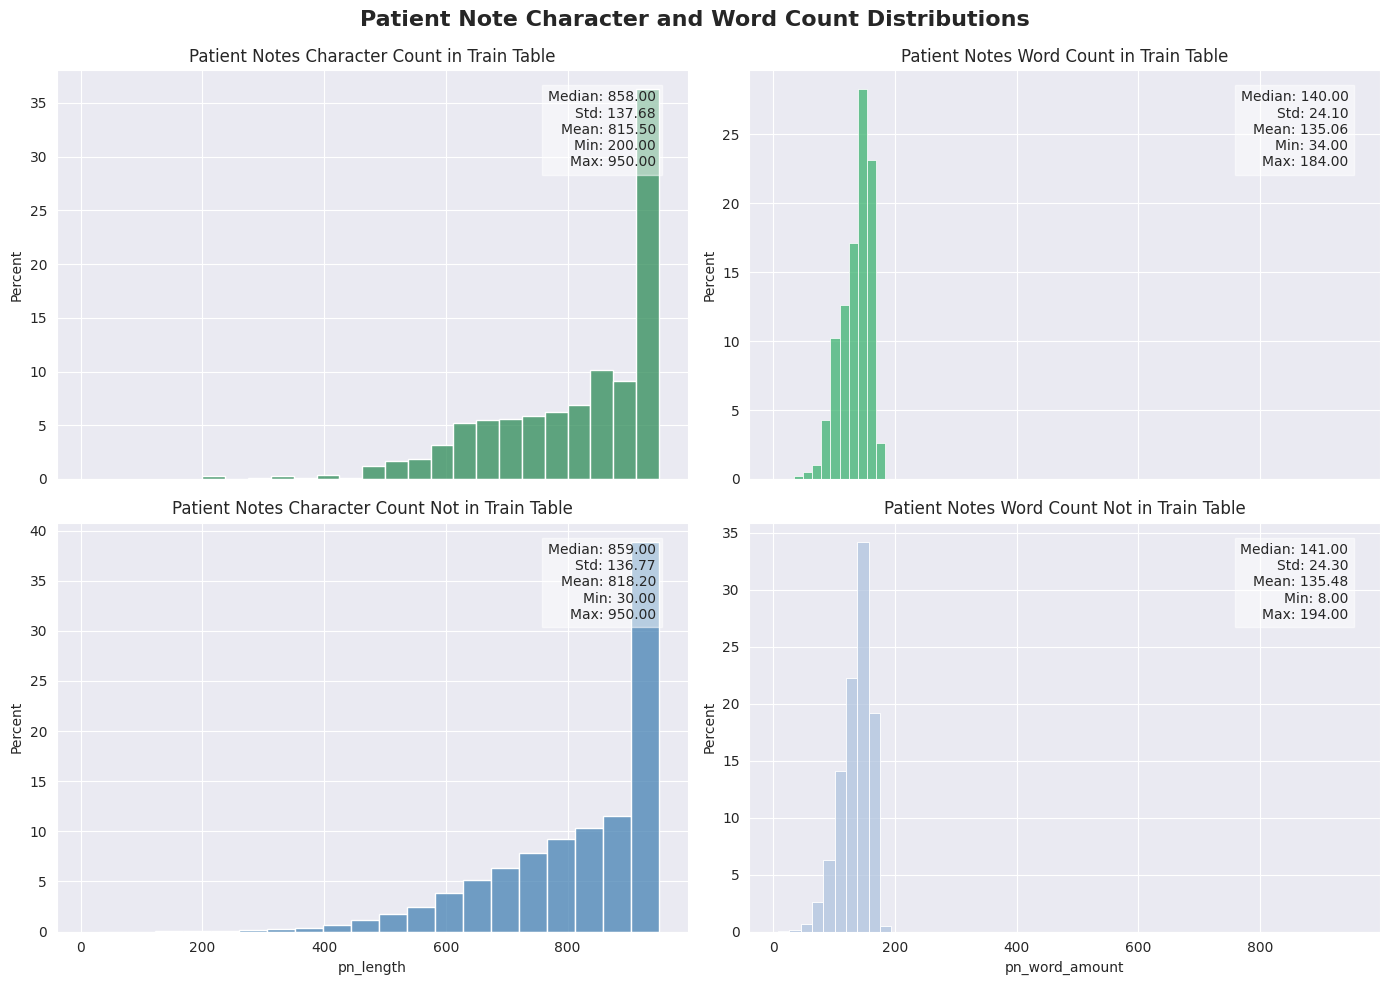

In [178]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10), sharex=True)

plot_histogram_with_stats(
    pn_df.loc[get_df_mask_by_dataset_type(pn_df,"train"), 'pn_length'],
    'Patient Notes Character Count in Train Table',
    axes[0][0],
    color="seagreen",
    bins=20,
    stat="percent",
)


plot_histogram_with_stats(
    pn_df.loc[get_df_mask_by_dataset_type(pn_df,"train"), 'pn_word_amount'],
    'Patient Notes Word Count in Train Table',
    axes[0][1],
    color="mediumseagreen",
    stat="percent",
    bins=10
)

plot_histogram_with_stats(
    pn_df.loc[~pn_df.in_train, 'pn_length'],
    'Patient Notes Character Count Not in Train Table',
    axes[1][0],
    color="steelblue",
    bins=20,
    stat="percent"
)

plot_histogram_with_stats(
    pn_df.loc[~pn_df.in_train, 'pn_word_amount'],
    'Patient Notes Word Count Not in Train Table',
    axes[1][1],
    color="lightsteelblue",
    bins=10,
    stat="percent"
)

plt.tight_layout()
fig.suptitle("Patient Note Character and Word Count Distributions", fontsize=16, fontweight='bold')
plt.subplots_adjust(top=0.92)

plt.show()


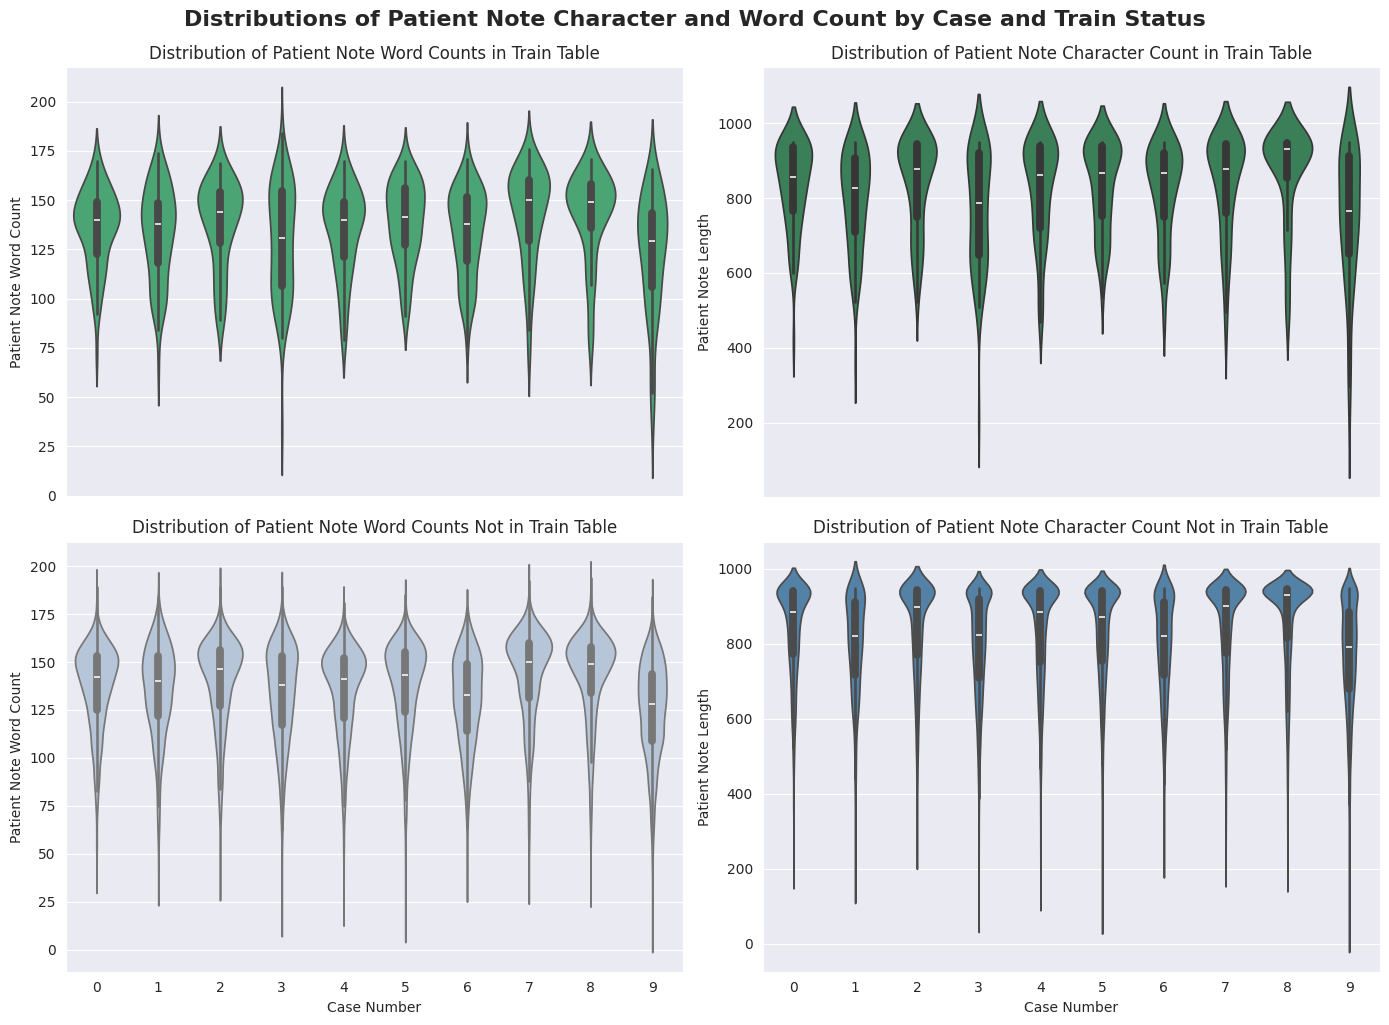

In [179]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10), sharex=True)

axes[0][0].set_title('Distribution of Patient Note Word Counts in Train Table')
axes[0][0].set_ylabel('Patient Note Word Count')

sns.violinplot(
    x='case_num', y='pn_word_amount',
    data=pn_df[get_df_mask_by_dataset_type(pn_df,"train")],
    ax=axes[0][0], color='mediumseagreen'
)

axes[1][0].set_title('Distribution of Patient Note Word Counts Not in Train Table')
axes[1][0].set_ylabel('Patient Note Word Count')

sns.violinplot(
    x='case_num', y='pn_word_amount',
    data=pn_df[pn_df['in_train'] == False],
    ax=axes[1][0], color='lightsteelblue'
)

axes[0][1].set_title('Distribution of Patient Note Character Count in Train Table')
axes[0][1].set_ylabel('Patient Note Length')

sns.violinplot(
    x='case_num', y='pn_length',
    data=pn_df[get_df_mask_by_dataset_type(pn_df,"train")],
    ax=axes[0][1], color='seagreen'
)

axes[1][1].set_title('Distribution of Patient Note Character Count Not in Train Table')
axes[1][1].set_ylabel('Patient Note Length')

sns.violinplot(
    x='case_num', y='pn_length',
    data=pn_df[pn_df['in_train'] == False],
    ax=axes[1][1], color='steelblue'
)

# Common xlabel for all plots
for ax in axes[1]:
    ax.set_xlabel('Case Number')

plt.tight_layout()
plt.suptitle("Distributions of Patient Note Character and Word Count by Case and Train Status", fontsize=16, fontweight='bold', y=1.02)
plt.show()


The size distribution of the train table is quite similar to that of the patient notes table. Although the size of patient notes varies across different cases, these differences does not seem significant.

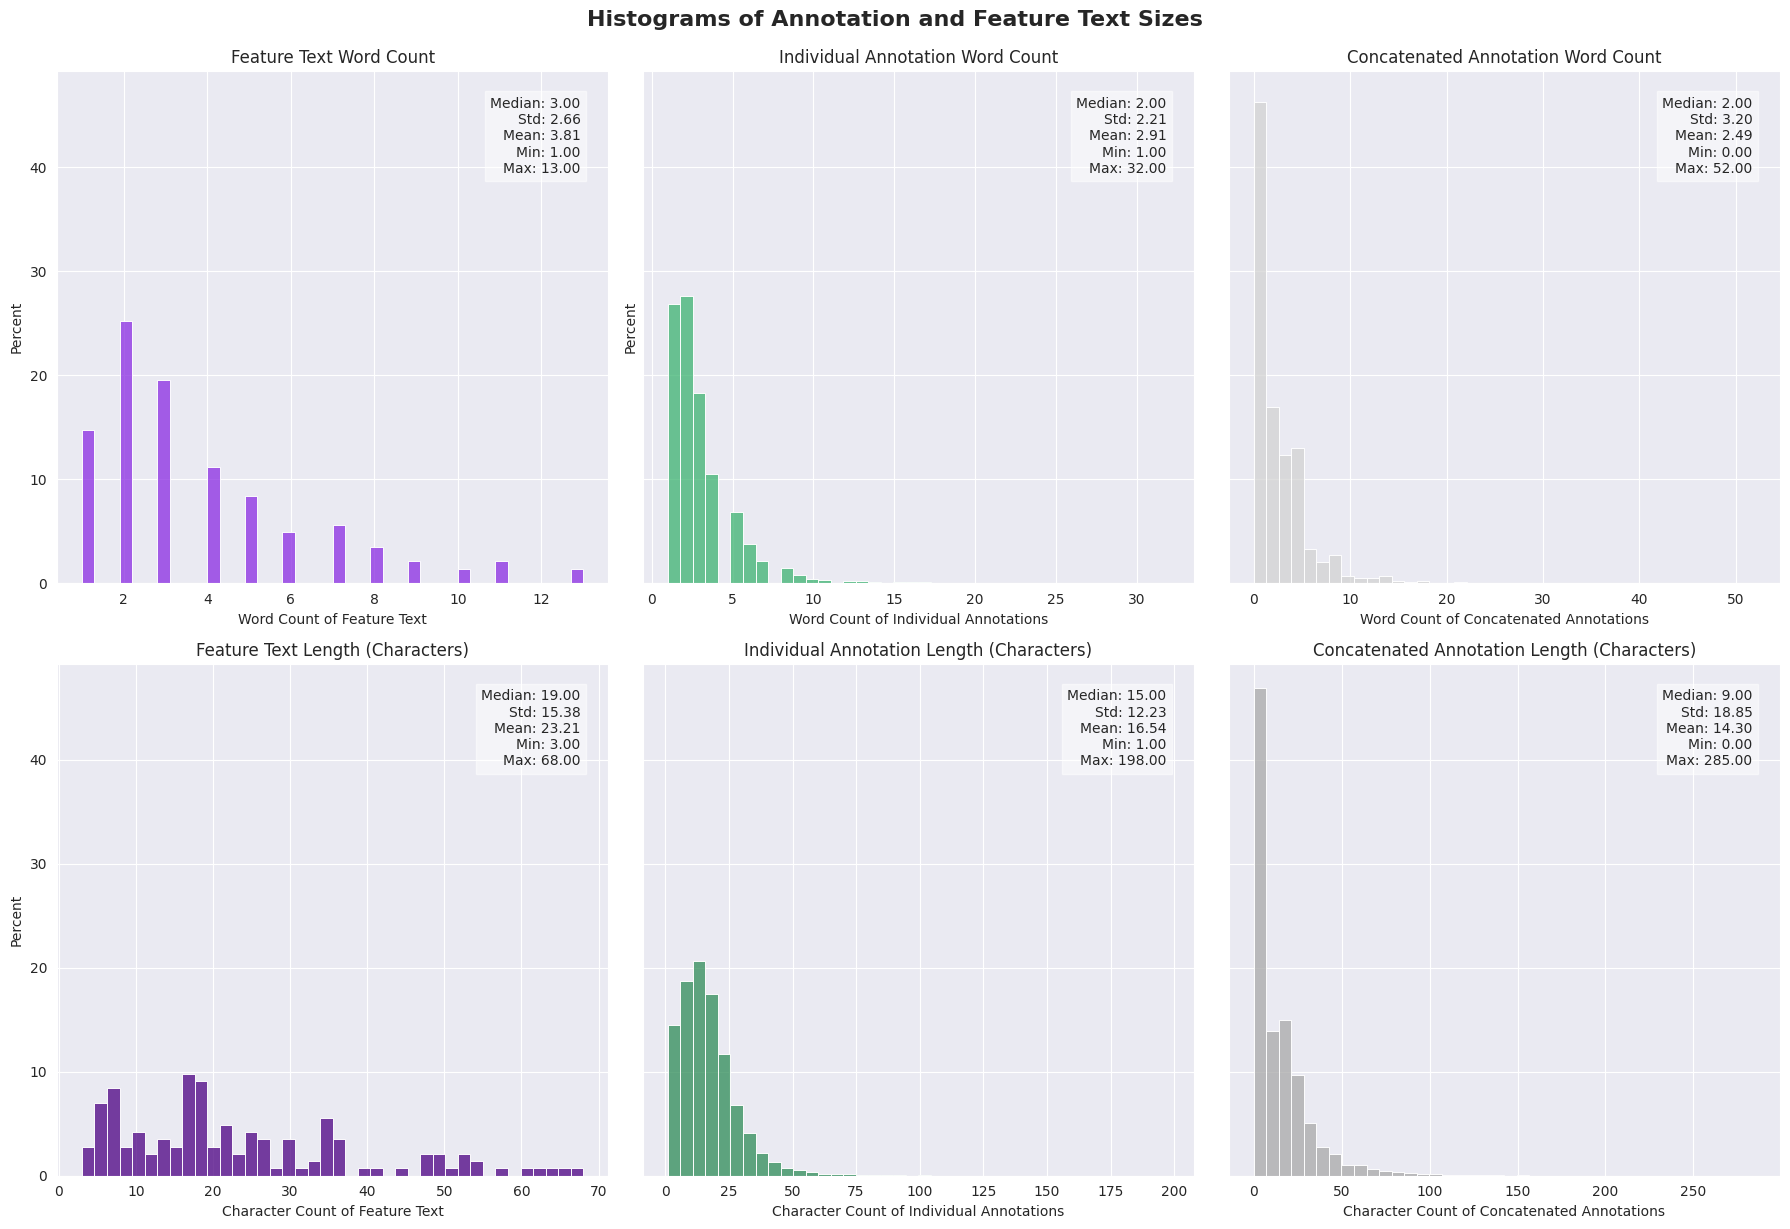

In [180]:
individual_annotation_lengths = train_df.loc[get_df_mask_by_dataset_type(train_df,"train"),'annotation'].explode().dropna().str.len().reset_index(drop=True)
individual_annotation_word_counts = train_df.loc[get_df_mask_by_dataset_type(train_df,"train"),'annotation'].explode().dropna().str.split().apply(len).reset_index(drop=True)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12), sharey=True)

axes[0, 0].set_xlabel('Word Count of Feature Text')
plot_histogram_with_stats(
    features_df['feature_text'].str.split(" ").apply(len),
    'Feature Text Word Count',
    axes[0, 0],
    color='blueviolet',
    bins=40,
    stat="percent"
)

axes[1, 0].set_xlabel('Character Count of Feature Text')
plot_histogram_with_stats(
    features_df['feature_text'].str.len(),
    'Feature Text Length (Characters)',
    axes[1, 0],
    color='indigo',
    bins=40,
    stat="percent"
)

axes[0, 1].set_xlabel('Word Count of Individual Annotations')
axes[0, 1].set_ylabel('Percentage')

plot_histogram_with_stats(
    individual_annotation_word_counts,
    'Individual Annotation Word Count',
    axes[0, 1],
    color='mediumseagreen',
    bins=40,
    stat="percent"
)

axes[1, 1].set_xlabel('Character Count of Individual Annotations')
plot_histogram_with_stats(
    individual_annotation_lengths,
    'Individual Annotation Length (Characters)',
    axes[1, 1],
    color='seagreen',
    bins=40,
    stat="percent"
)

axes[0, 2].set_xlabel('Word Count of Concatenated Annotations')
plot_histogram_with_stats(
    train_df['annotation'].apply(lambda x: len(' '.join(x).split())),
    'Concatenated Annotation Word Count',
    axes[0, 2],
    color='lightgray',
    bins=40,
    stat="percent"
)

axes[1, 2].set_xlabel('Character Count of Concatenated Annotations')
plot_histogram_with_stats(
    train_df['annotation'].apply(lambda x: len(' '.join(x))),
    'Concatenated Annotation Length (Characters)',
    axes[1, 2],
    color='darkgray',
    bins=40,
    stat="percent"
)
plt.tight_layout()
plt.suptitle('Histograms of Annotation and Feature Text Sizes', fontsize=16, fontweight='bold', y=1.02)
plt.show()


Correlation between Individual Annotation Word Count and Feature Text Word Count: 0.2666


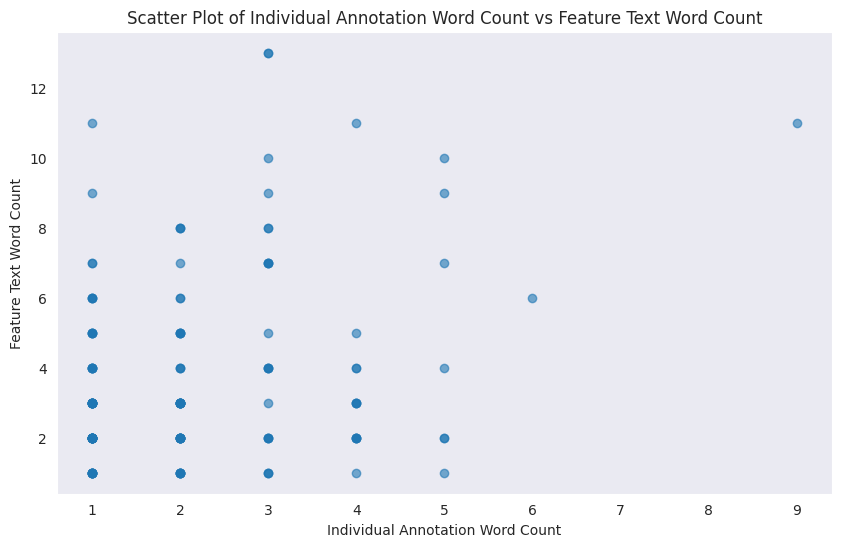

In [181]:
individual_annotation_word_counts = train_df.loc[get_df_mask_by_dataset_type(train_df,"train"),'annotation'].explode().dropna().str.split().apply(len).reset_index(drop=True)
feature_text_word_counts = features_df['feature_text'].str.split().apply(len).reset_index(drop=True)

correlation_df = pd.DataFrame({
    'Individual_Annotation_Word_Count': individual_annotation_word_counts,
    'Feature_Text_Word_Count': feature_text_word_counts
})

correlation_df.dropna(inplace=True)

correlation = correlation_df.corr().iloc[0, 1]
print(f'Correlation between Individual Annotation Word Count and Feature Text Word Count: {correlation:.4f}')

plt.figure(figsize=(10, 6))
plt.scatter(correlation_df['Individual_Annotation_Word_Count'], correlation_df['Feature_Text_Word_Count'], alpha=0.6)
plt.title('Scatter Plot of Individual Annotation Word Count vs Feature Text Word Count')
plt.xlabel('Individual Annotation Word Count')
plt.ylabel('Feature Text Word Count')
plt.grid()
plt.show()

Although they are not correlated, it is observed that both the feature text and a single annotation fall within a similar length range, typically consisting of a single-digit number greater than one word.

### Exploring Properties Of Annotations

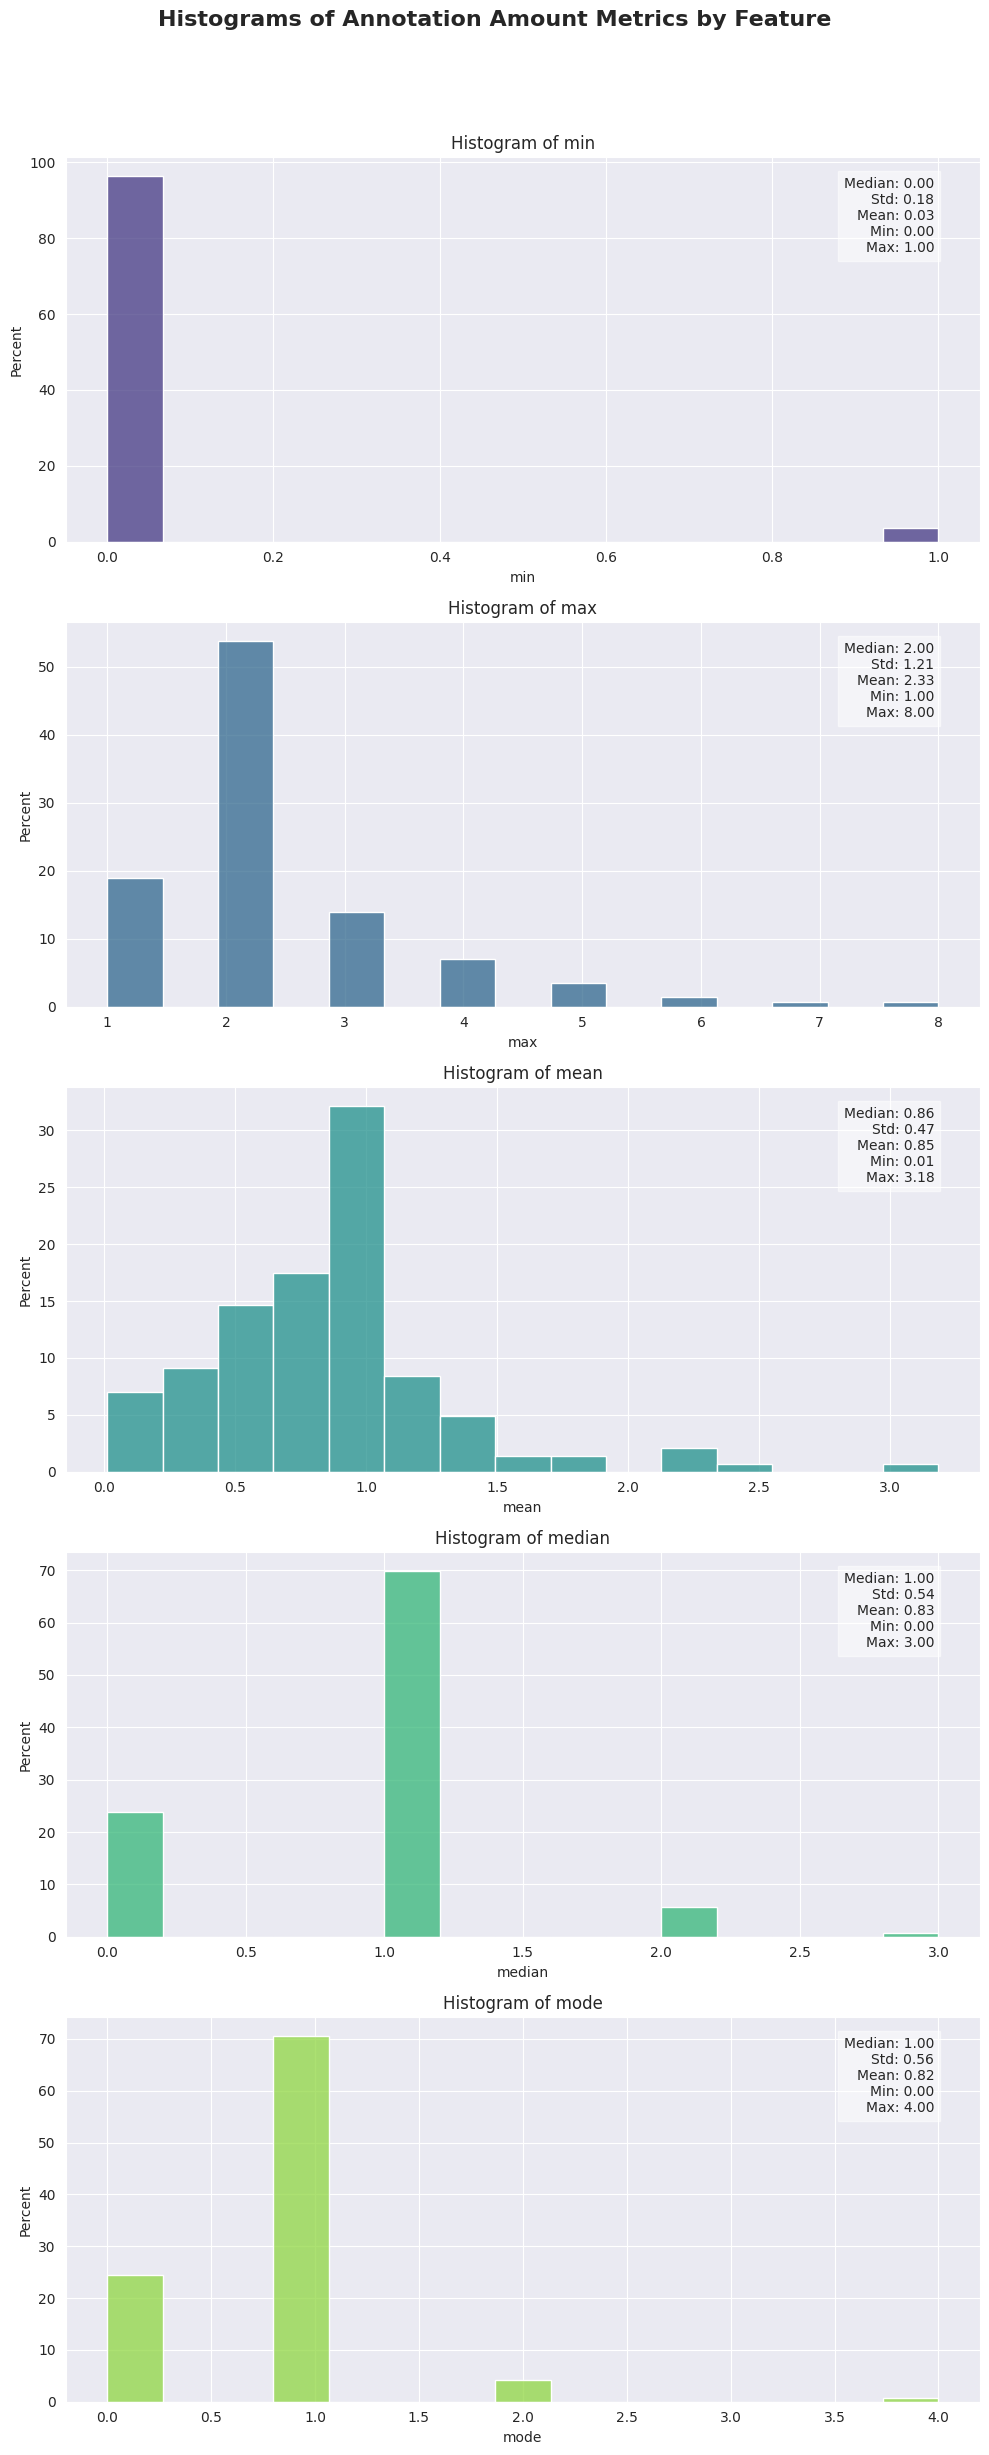

In [182]:
train_df["annotation_amount"] = train_df.annotation.apply(len)
annotaions_per_feature_df = train_df.loc[get_df_mask_by_dataset_type(train_df,"train")].groupby(["feature_num"]).agg(
    min=("annotation_amount", "min"),
    max=("annotation_amount", "max"),
    mean=("annotation_amount", "mean"),
    median=("annotation_amount", "median"),
    mode=("annotation_amount", lambda x: x.mode().iloc[0])
)

metrics_num = len(annotaions_per_feature_df.columns)

fig, axes = plt.subplots(nrows=metrics_num, ncols=1, figsize=(10, 5 * metrics_num))

plt.suptitle('Histograms of Annotation Amount Metrics by Feature', fontsize=16, fontweight='bold')

colors = sns.color_palette("viridis", metrics_num)

for ax, column, color in zip(axes, annotaions_per_feature_df.columns, colors):
    plot_histogram_with_stats(annotaions_per_feature_df[column], f"Histogram of {column}", ax, color=color, bins=15, stat="percent")
    ax.set_xlabel(column)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


- Every feature has at least one associated annotation.
- For the majority of features, there are patient notes that do not contain any annotations corresponding to those features.
- For a typical feature, most patient notes will contain only a few annotations ~(1-4).

In [183]:
annotation_df = train_df.loc[get_df_mask_by_dataset_type(train_df,"train")].explode(['annotation', 'location']).dropna(subset=['annotation', 'location']).reset_index(drop=True)
annotation_df['location'] = annotation_df['location'].str.split(';')
annotation_df['num_spans'] = annotation_df['location'].apply(len)

In [184]:
def calculate_span_distances(row: pd.Series) -> tuple[list[int], list[int]]:
    """
    Calculate the distances between consecutive spans in both characters and words.

    Args:
        row (pd.Series):
        contains the following:
        location: A list of span ranges (e.g., [0 5,1 0 15]).
                        Each span is represented as "start end" with start and end positions as integers.
        annotation_text : The text where spans are located, used to count words between spans.

    Returns:
        tuple[list[int], list[int]]:
            - A list of distances in characters between consecutive spans.
            - A list of distances in words between consecutive spans.
    """
    spans = [tuple(map(int, span.split())) for span in row.location]

    distances_characters = []
    distances_words = []

    for (start1, end1),(start2, end2) in zip(spans[:-1], spans[1:]):
        distances_characters.append(abs(start2 - end1))
        distances_words.append(len(pn_df.loc[pn_df.pn_num==row.pn_num, "pn_history"].iloc[0][end1:start2].split()))
    return distances_characters, distances_words

In [185]:
spans_dist_df = annotation_df
spans_dist_df[['span_distances_chars', 'span_distances_words']] = annotation_df.apply(calculate_span_distances, axis=1, result_type='expand')

spans_dist_df = spans_dist_df.explode(['span_distances_chars', 'span_distances_words']).dropna(subset=['span_distances_chars', 'span_distances_words']).reset_index(drop=True)

In [186]:
spans_df = annotation_df.explode(['location']).dropna(subset=['location'])

spans_df['span_start'] = spans_df['location'].apply(lambda x: int(x.split()[0]))
spans_df['span_end'] = spans_df['location'].apply(lambda x: int(x.split()[1]))

spans_df['span_length_chars'] = spans_df['span_end'] - spans_df['span_start']
spans_df['span_word_count'] = spans_df.apply(lambda row: len(pn_df.loc[pn_df.pn_num==row.pn_num, "pn_history"].iloc[0][row['span_start']:row['span_end']].split()), axis=1)

spans_df['span_index'] = spans_df.groupby(level=0).cumcount()


In [187]:
spans_df.head()

id  case_num  pn_num  feature_num                    annotation  \
0  00016_000         0      16            0  dad with recent heart attcak   
1  00016_001         0      16            1     mom with "thyroid disease   
2  00016_002         0      16            2                chest pressure   
3  00016_003         0      16            3         intermittent episodes   
4  00016_003         0      16            3                       episode   

  location  annotation_amount  num_spans span_distances_chars  \
0  696 724                  1          1                   []   
1  668 693                  1          1                   []   
2  203 217                  1          1                   []   
3    70 91                  2          1                   []   
4  176 183                  2          1                   []   

  span_distances_words  span_start  span_end  span_length_chars  \
0                   []         696       724                 28   
1                   []         668       693                 25   
2                   []         203       217                 14   
3                   []          70        91                 21   
4                   []         176       183                  7   

   span_word_count  span_index  
0                5           0  
1                4           0  
2                2           0  
3                2           0  
4                1           0

<ipython-input-188-ab7cf1d7235e>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
<ipython-input-188-ab7cf1d7235e>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


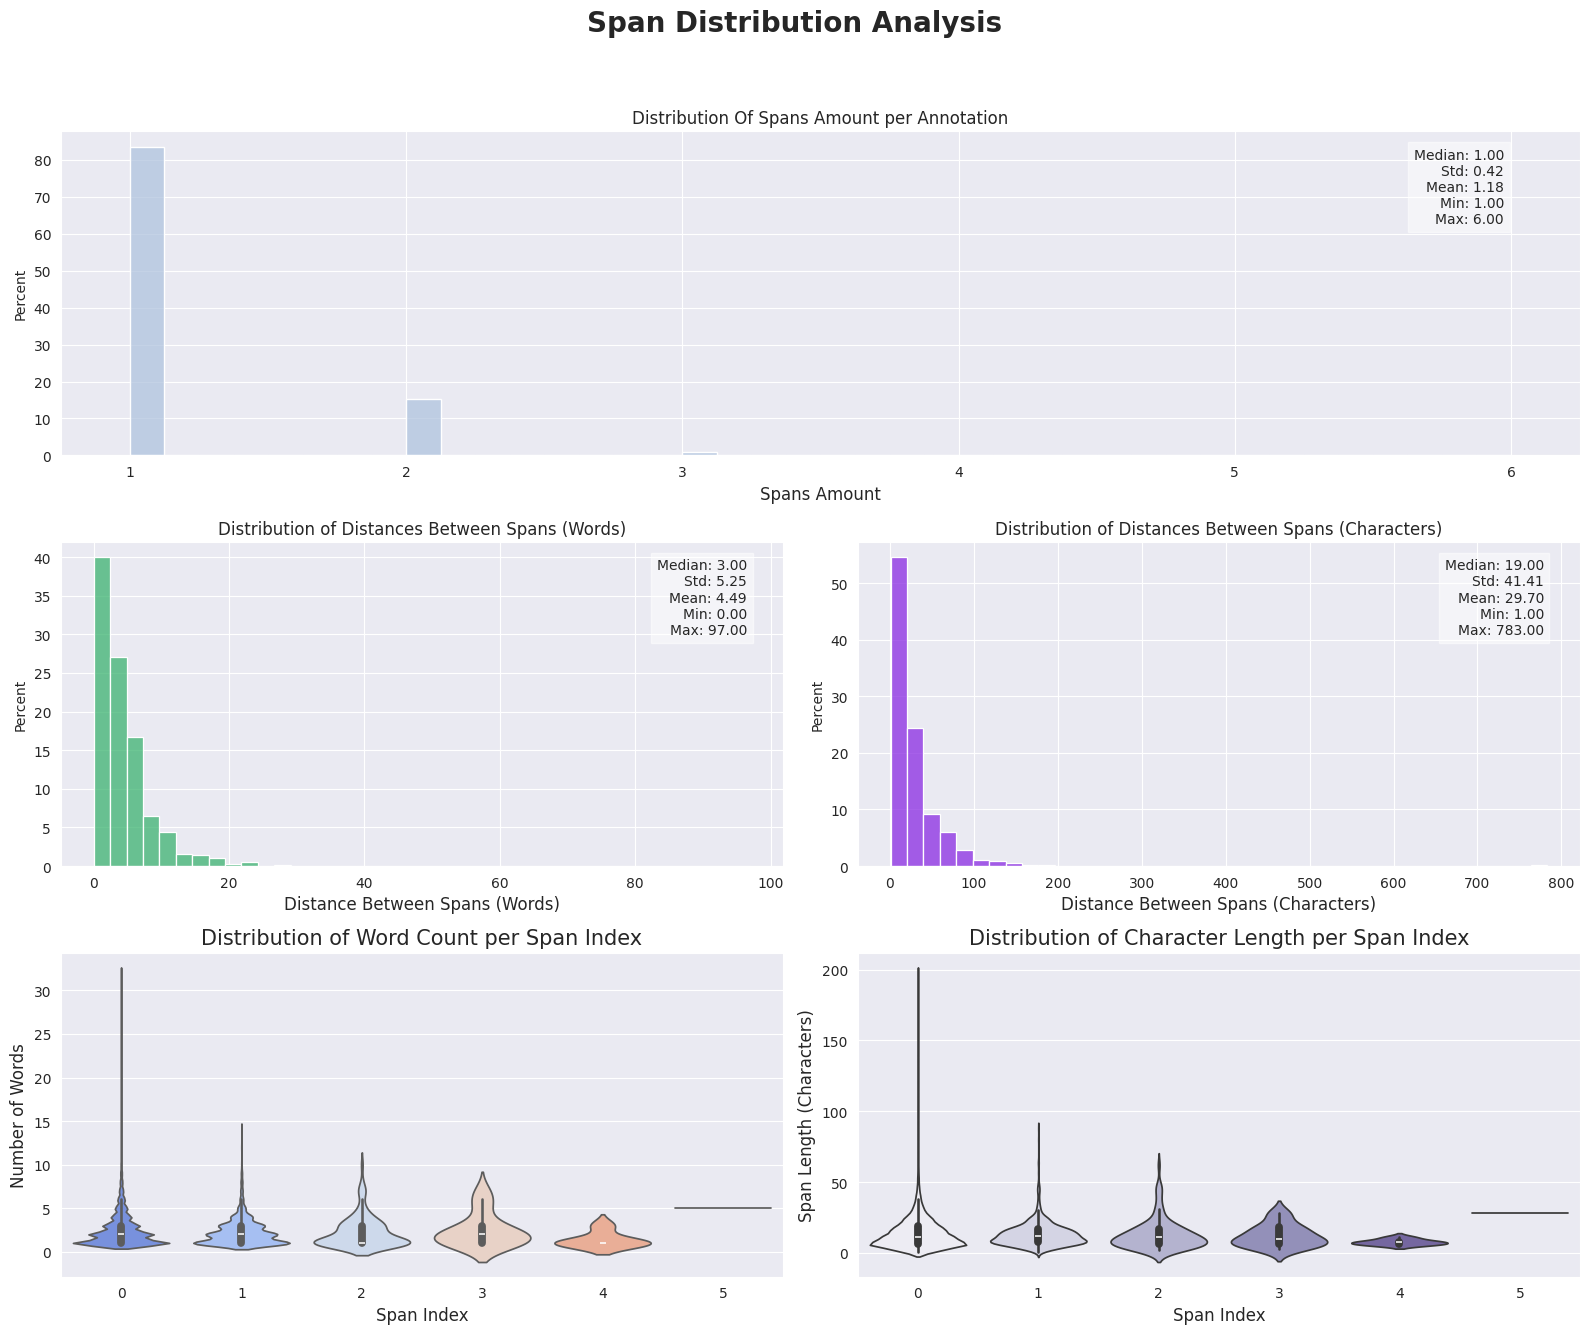

In [188]:
fig = plt.figure(figsize=(16, 14))
fig.suptitle('Span Distribution Analysis', fontsize=20, fontweight='bold')
axes = [[fig.add_subplot(3,2,3+i+2*j) for i in range(2)] for j in range(2)]

ax_span = fig.add_subplot(3,2,(1,2))
ax_span.set_xlabel('Spans Amount', fontsize=12)

plot_histogram_with_stats(
    annotation_df['num_spans'],
    'Distribution Of Spans Amount per Annotation',
    ax_span,
    color='lightsteelblue',
    bins=40,
    stat="percent"
)
axes[0][0].set_xlabel('Distance Between Spans (Words)', fontsize=12)
plot_histogram_with_stats(
    spans_dist_df['span_distances_words'],
    'Distribution of Distances Between Spans (Words)',
    axes[0][0],
    color='mediumseagreen',  # Teal
    bins=40,
    stat="percent"
)

axes[0][1].set_xlabel('Distance Between Spans (Characters)', fontsize=12)
plot_histogram_with_stats(
    spans_dist_df['span_distances_chars'],
    'Distribution of Distances Between Spans (Characters)',
    axes[0][1],
    color='blueviolet',
    bins=40,
    stat="percent"
)

axes[1][0].set_xlabel('Span Index', fontsize=12)
axes[1][0].set_ylabel('Number of Words', fontsize=12)
axes[1][0].set_title('Distribution of Word Count per Span Index', fontsize=15)
spans_df['span_index'] = spans_df['span_index'].astype(str)
sns.violinplot(
    data=spans_df,
    x='span_index',
    y='span_word_count',
    ax=axes[1][0],
    palette='coolwarm'
)

axes[1][1].set_xlabel('Span Index', fontsize=12)
axes[1][1].set_ylabel('Span Length (Characters)', fontsize=12)
axes[1][1].set_title('Distribution of Character Length per Span Index', fontsize=15)
sns.violinplot(
    data=spans_df,
    x='span_index',
    y='span_length_chars',
    ax=axes[1][1],
    palette='Purples'
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The majority of annotations consist of a single continuous span.
When multiple spans are present, the distance between two spans is typically no more than 5 words, regardless of the span index.

In [189]:
def create_tuple_of_words_indices(row: pd.Series) -> set[tuple[int,int]]:
  """
  Extracts a set of (start, end) index tuples for words in annotation.

  Parameters:
  - row (pd.Series): a pandas series containing:
  - 'location' (list of str): List of space-separated start and end indices for each annotation span.
  - 'annotation' (str): The annotated text.

  Returns:
  - Set[Tuple[int, int]]: A set of tuples where each tuple represents the start and end character indices of a word in the annotation.

  """
  locations = iter(row['location'])
  word_start, end_span = map(int, next(locations).split())
  annotation_words_list = row['annotation'].split()
  words_indices_set = set()
  for word in annotation_words_list:
    word_end = word_start + len(word)
    if end_span< word_end:
      word_start, end_span = map(int, next(locations).split())
      word_end = word_start+len(word)

    words_indices_set.add((word_start, word_end))
    word_start = word_end + 1
  return words_indices_set

annotation_df["words_indices_set"] = annotation_df.apply(create_tuple_of_words_indices, axis=1)

annotated_words_amount_per_id_df = (
    annotation_df
    .groupby(["id", "pn_num"])["words_indices_set"]
    .apply(lambda x: len(set.union(*x.tolist())))
    .rename("annotated_words_amount")
    .reset_index()
)

words_amount_df = pn_df.loc[get_df_mask_by_dataset_type(pn_df,"train")].merge(annotated_words_amount_per_id_df, left_on="pn_num", right_index=True)

In [190]:
annotated_words_amount = int(words_amount_df['annotated_words_amount'].sum())
non_annotated_words_amount = words_amount_df['pn_word_amount'].sum() - annotated_words_amount

<ipython-input-191-3de65ec35dda>:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


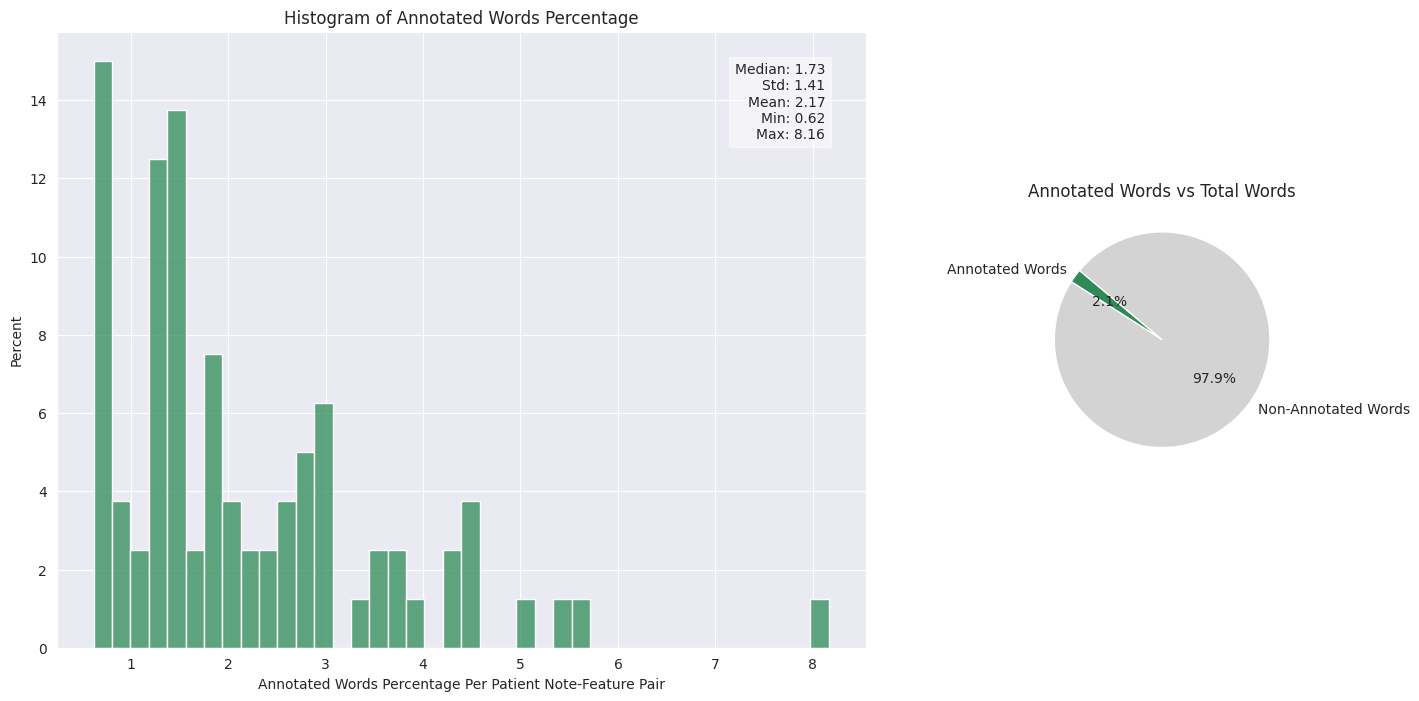

In [191]:
labels = ['Annotated Words', 'Non-Annotated Words']
sizes = [annotated_words_amount, non_annotated_words_amount]
colors = ['seagreen', 'lightgray']

fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1], wspace=0.3)

ax_hist = fig.add_subplot(gs[0])
plot_histogram_with_stats(
    (words_amount_df['annotated_words_amount'] / words_amount_df['pn_word_amount']) * 100,
    "Histogram of Annotated Words Percentage",
    ax_hist,
    colors[0],
    bins=40,
    stat="percent"
)
ax_hist.set_xlabel('Annotated Words Percentage Per Patient Note-Feature Pair')

ax_pie = fig.add_subplot(gs[1])
ax_pie.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
ax_pie.set_title('Annotated Words vs Total Words')

plt.tight_layout()
plt.show()


**The data is clearly imbalanced**. For each patient-note feature pair, most words are not annotated. A naive classifier that predicts no annotations would be correct for 97.9% of the words.

### Analyzing Annotations Semantics

In [192]:
def patient_data(pn_num: int) -> None:
  """
  Displays annotated patient history for a given patient number.

  Parameters:
  - pn_num (int): The patient note number.

  Returns:
  - None (Displays text with annotations using spaCy)
  """
  pn_text = get_patient_note_text(pn_num)
  subset = train_df[train_df['pn_num'] == pn_num].copy()
  locations  = subset["location"]

  print("*"*80)
  print(f"\nPatient Number: {pn_num}")
  print("\nAnnotated Patient History")

  ents = []
  for location_list in locations:
    for location in location_list:
      list_of_location_indices = parse_location_string(location)
      for annot_slice in list_of_location_indices:
        ents.append({'start': annot_slice[0],
                      'end' :  annot_slice[1],
                      'label' : "Annotation"})

  ents = sorted(ents, key = lambda i: i['start'])

  doc = {
      'text' : pn_text,
      'ents' : ents
  }
  colors = {"Annotation" :"pink"}
  options = {"colors": colors}

  spacy.displacy.render(doc, style='ent', options = options , manual=True, jupyter=True)

# choosing random patient notes ids:
patient_data(93534)
patient_data(82028)
patient_data(20643)

********************************************************************************

Patient Number: 93534

Annotated Patient History


********************************************************************************

Patient Number: 82028

Annotated Patient History


********************************************************************************

Patient Number: 20643

Annotated Patient History


From the samples, we observe that the annotations may include:

- Age and time terms in various formats
- Medical terms, including abbreviations
- Gender-related terms in different formats
- Stop words and terms with minimal informational value
- Details regarding the patient's general habits

Additionally, it is apparent that overlaps between different annotations can occasionally occur.

Note that not all of the terms listed above will always be annotated, as it depends on their relevance to the case.

### Analyzing Vocabulary
Only on labeled data


In [193]:
def generate_word_cloud(text: str):
  return WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(text)

In [194]:
feature_text = " ".join(features_df['feature_text'].astype(str).dropna().tolist())
annot_text = " ".join(annotation_df['annotation'].dropna().tolist())
pn_text_in_train = " ".join(pn_df.loc[get_df_mask_by_dataset_type(pn_df,"train"),'pn_history'].str.strip().dropna().tolist())

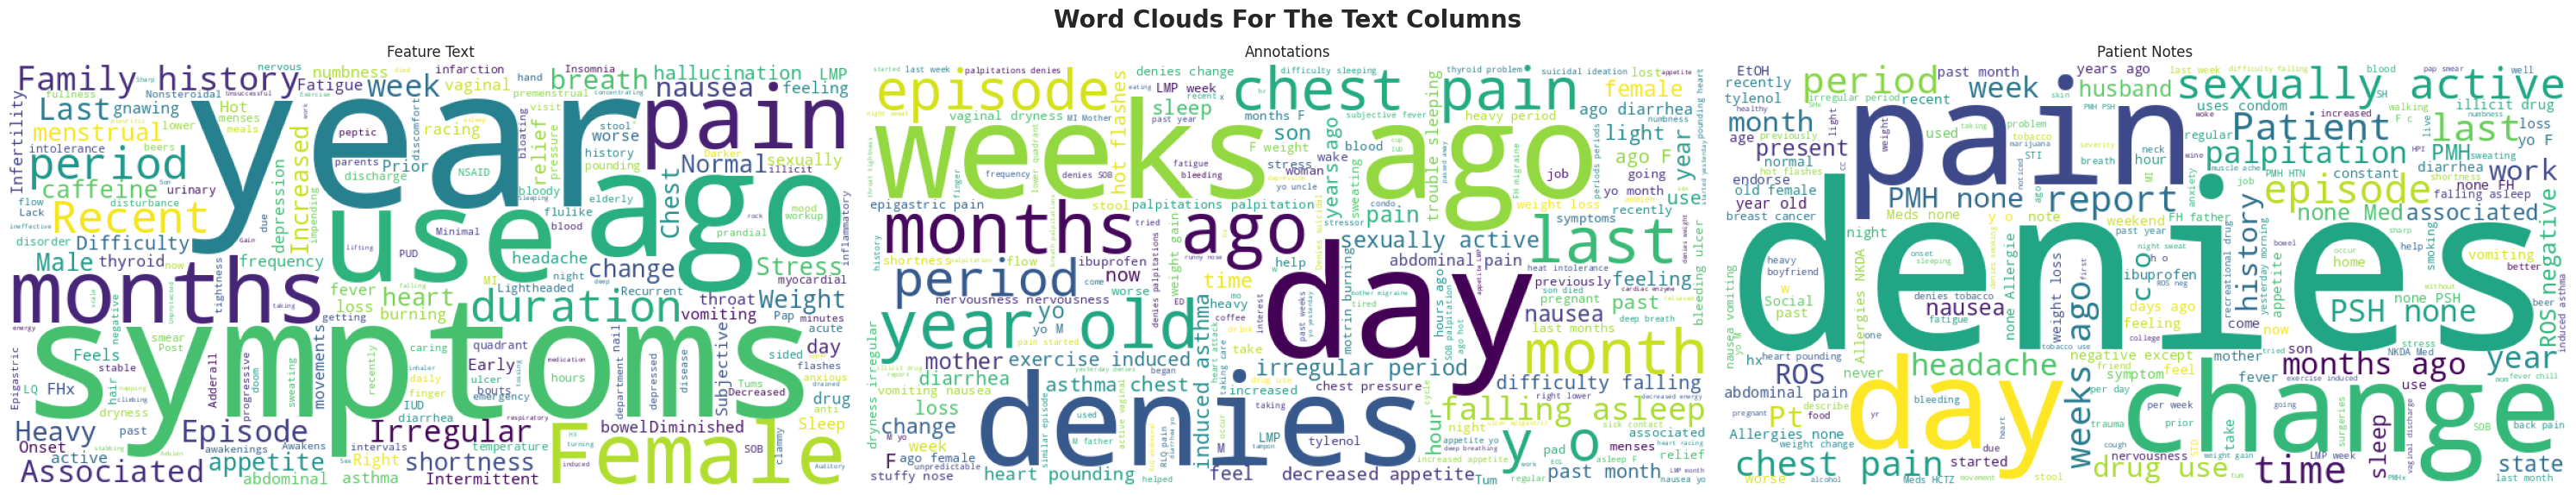

In [195]:
fig, axes = plt.subplots(1, 3, figsize=(30, 6))
fig.suptitle('Word Clouds For The Text Columns', fontsize=20, fontweight='bold')

text_n_title_list = [
    (feature_text, "Feature Text"),
    (annot_text, "Annotations"),
    (pn_text_in_train, "Patient Notes")
]

for i in range(3):
    text, title = text_n_title_list[i]
    axes[i].imshow(generate_word_cloud(text))
    axes[i].set_title(title)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

As expected, the word clouds for feature text and annotations are highly similar. Interestingly, time-related terms stand out in both, whereas they appear less prominently in the patient notes word cloud. However, many terms are shared across all three word clouds

In [196]:
feature_words_sensitive = set(feature_text.split())
annot_words_sensitive = set(annot_text.split())
pn_words_sensitive = set(pn_text_in_train.split())

feature_words_insensitive = set(feature_text.lower().split())
annot_words_insensitive = set(annot_text.lower().split())
pn_words_insensitive = set(pn_text_in_train.lower().split())

words_n_title = [
    ("Feature Text", feature_words_sensitive, feature_words_insensitive),
    ("Annotations", annot_words_sensitive, annot_words_insensitive),
    ("Patient Notes", pn_words_sensitive, pn_words_insensitive)
]

for i in range(3):
  print(f"Amount Of Unique Words In {words_n_title[i][0]}: {len(words_n_title[i][1])}")
  print(f"Amount Of Unique Words In {words_n_title[i][0]} (Case-Insensitive): {len(words_n_title[i][2])}")

Amount Of Unique Words In Feature Text: 291
Amount Of Unique Words In Feature Text (Case-Insensitive): 271
Amount Of Unique Words In Annotations: 2936
Amount Of Unique Words In Annotations (Case-Insensitive): 2305
Amount Of Unique Words In Patient Notes: 11684
Amount Of Unique Words In Patient Notes (Case-Insensitive): 9482


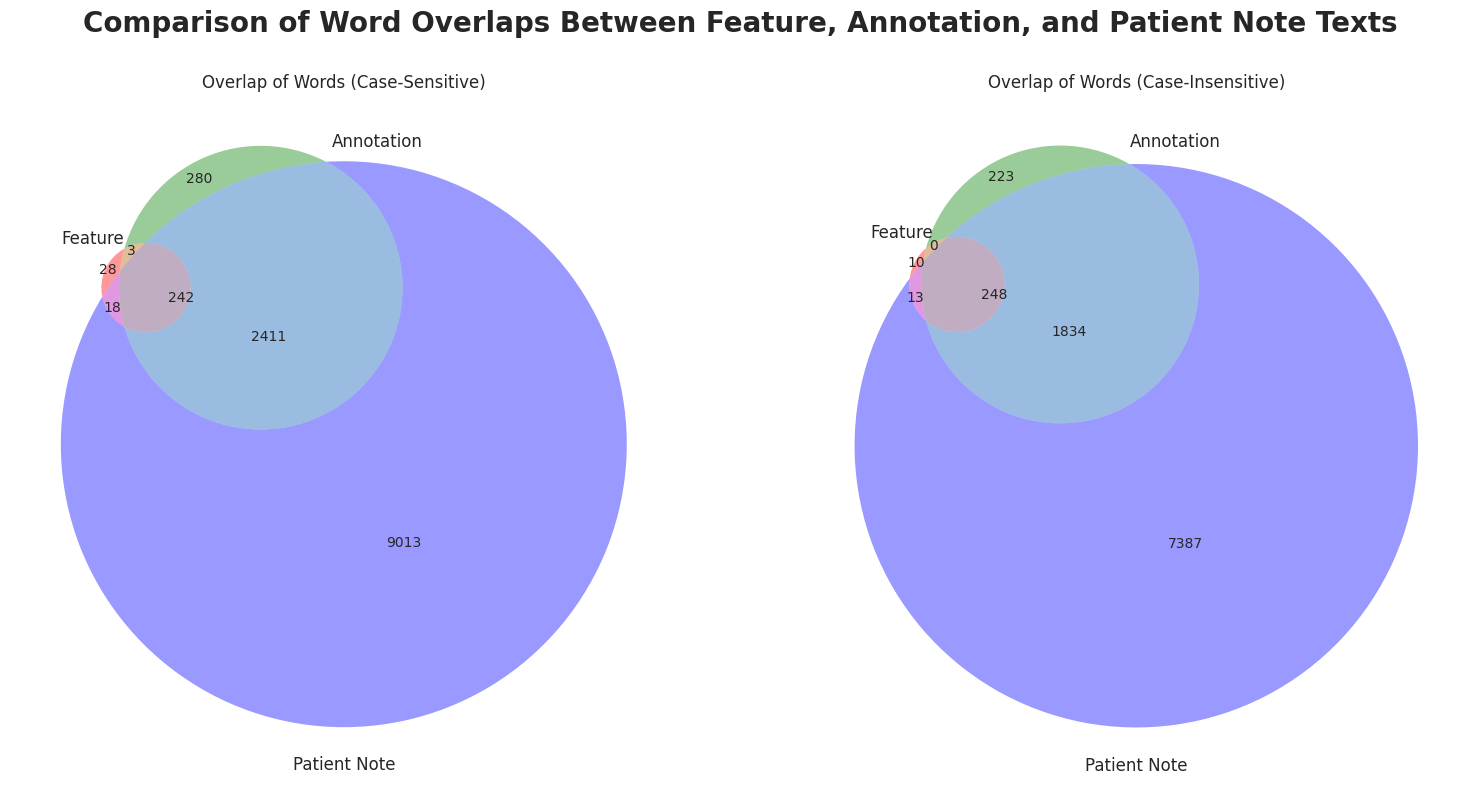

In [197]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Comparison of Word Overlaps Between Feature, Annotation, and Patient Note Texts', fontsize=20, fontweight='bold')


venn3([feature_words_sensitive, annot_words_sensitive, pn_words_sensitive],
      ('Feature', 'Annotation', 'Patient Note'), ax=axes[0])
axes[0].set_title("Overlap of Words (Case-Sensitive)")

venn3([feature_words_insensitive, annot_words_insensitive, pn_words_insensitive],
      ('Feature', 'Annotation', 'Patient Note'), ax=axes[1])
axes[1].set_title("Overlap of Words (Case-Insensitive)")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the suptitle
plt.show()


It is interesting to note that compared to the patient notes word set, the set of annotation words is relatively small, yet it contains most of the feature words.

The fact that the annotation word set is not fully contained within the patient notes word set suggests that some spans start or end in the middle of a word in the patient notes (defined as a string sequence up to the next space), accounting for approximately 20%.

In [198]:
feature_words_insensitive - annot_words_insensitive

{'anti',
 'bouts',
 'disturbance',
 'flulike',
 'ineffective',
 'infarction',
 'inflammatory',
 'lq',
 'medication',
 'myocardial',
 'napping',
 'nonsteroidal',
 'post',
 'prandial',
 'scale',
 'shares',
 'sided',
 'stable',
 'status',
 'unknown',
 'vaccine',
 'viral',
 'wakening'}

In [199]:
list(annot_words_insensitive - pn_words_insensitive)[:30]

['effect',
 'ulce',
 'brathing',
 'montly',
 'rock-climbs',
 'efective',
 'distance',
 '"problem',
 'tobac/etoh/drugs',
 'mottrin',
 'blood/melena',
 'climbings',
 'induced-asthma',
 'ather',
 'vomtiing',
 'nauseu',
 'hea',
 'asting',
 'lump',
 'hourse',
 'resolution',
 'alternated',
 'dypnea',
 'persisted',
 'insomina',
 '2-3/day',
 'hanges',
 'photophobi',
 '26y',
 'helping)']

I believe that replacing all non-alphanumeric characters with spaces will significantly reduce the number of annotations that start or end in the middle of a word. Let's test this hypothesis.

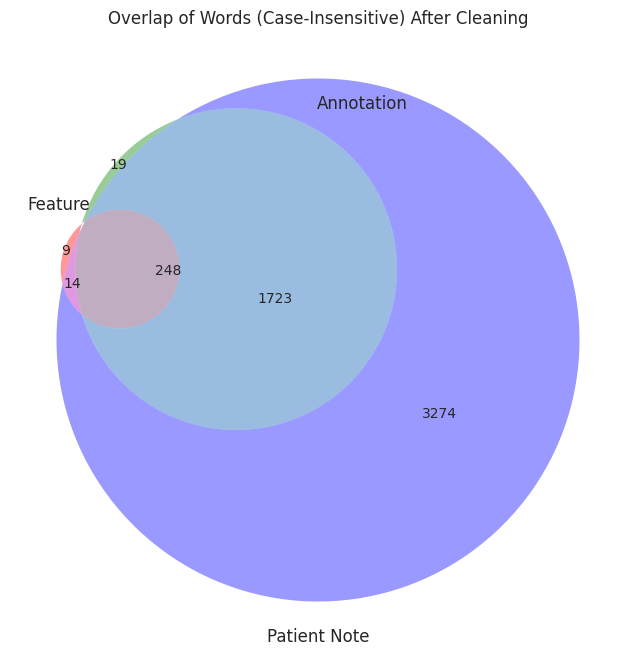

In [200]:
def clean_text_and_split_to_words(df: pd.DataFrame, column: str) -> set:
  """
  Cleans text by converting to lowercase, removing non-word characters (except apostrophes),
  and split into a set of unique words.

  Parameters:
  - df (pd.DataFrame): DataFrame containing the text column
  - column (str): Column name containing text data

  Returns:
  - set: A set of cleaned, unique words
  """
  cleaned_text = " ".join(
      df[column]
      .dropna()  # Handle missing values
      .str.lower()  # Convert to lowercase
      .replace(r"[^\w']", " ", regex=True)  # Remove non-word characters except apostrophes
      .tolist()
  )
  return set(cleaned_text.split())


feature_words_cleaned = clean_text_and_split_to_words(features_df, 'feature_text')
annot_words_cleaned = clean_text_and_split_to_words(annotation_df, 'annotation')
pn_words_cleaned = clean_text_and_split_to_words(
    pn_df.loc[get_df_mask_by_dataset_type(pn_df, "train")], 'pn_history'
)

# Plot Venn diagram
plt.figure(figsize=(16, 8))
venn3(
    [feature_words_cleaned, annot_words_cleaned, pn_words_cleaned],
    ('Feature', 'Annotation', 'Patient Note'),
    ax=plt.gca()
)
plt.title("Overlap of Words (Case-Insensitive) After Cleaning")
plt.show()

The cleaning process significantly reduced the total word count and greatly decreased the occurrence of annotations that begin or end mid-word.

In [201]:
annotation_to_feature_df = pd.merge(annotation_df[["pn_num","feature_num","annotation"]], features_df[["feature_num","feature_text"]], on='feature_num', how='inner')
annotation_to_feature_df.sample(10, random_state=32)

pn_num  feature_num                                 annotation  \
1237   10267          103                                   diarrhea   
2139   20631          212                       ranged from 2-6 days   
4457   43003          400                        Denies hair changes   
9426   93554          902                                  yesterday   
1135   10182          107                               rlq quadrant   
9131   92097          914  preferred the room light to be turned off   
1804   10911          100               DENIES ANY VAGINAL DISCHARGE   
6685   61497          611                                      sharp   
7288   72030          703                            LMP 2 month ago   
7831   80525          811                           decreased energy   

                                           feature_text  
1237                         Prior episodes of diarrhea  
2139  Irregular flow OR Irregular frequency OR Irreg...  
4457                     Lack of other thyroid symptoms  
9426                  1 day duration OR 2 days duration  
1135  Right sided LQ abdominal pain OR Right lower q...  
9131                                        Photophobia  
1804                               No vaginal discharge  
6685  Sharp OR stabbing OR 7 to 8 out of 10 on pain ...  
7288                 Last menstrual period 2 months ago  
7831               Diminished energy OR feeling drained

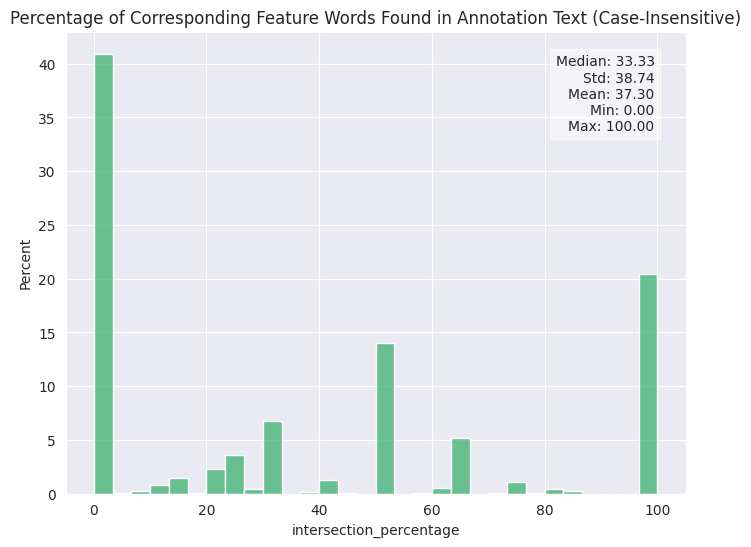

In [202]:
def feature_in_annotation_word_match_percentage(row: pd.Series) -> float:
  """
  Calculates the percentage of annotation words that appear in the corresponding feature text.

  Parameters:
  - row (pd.Series): A pandas Series containing 'annotation' and 'feature_text' columns.

  Returns:
  - float: The percentage of annotation words found in the feature text (0-100).
  """

  annotation_words = set(row['annotation'].lower().split())
  feature_words = set(row['feature_text'].lower().split())
  matched_words = annotation_words.intersection(feature_words)
  if annotation_words:
    return len(matched_words) / len(annotation_words) * 100
  else:
    return 0

annotation_to_feature_df["intersection_percentage"] = annotation_to_feature_df.apply(feature_in_annotation_word_match_percentage, axis=1)

fig, ax = plt.subplots(figsize=(8, 6))

plot_histogram_with_stats(annotation_to_feature_df["intersection_percentage"],
                          title="Percentage of Corresponding Feature Words Found in Annotation Text (Case-Insensitive)",
                          ax=ax, color="mediumseagreen", bins=30, stat="percent")
plt.show()

It’s interesting to note that, in most annotations, there is at least one word that also appears in the feature text.

## **Main Findings From The EDA**

### Data Structure:
- The labeled data trully contain 100 patient note for each of the 10 cases.
- Each case has 9-18 different features.
- Most of the data is unlabeled ~97.63%.
- The data is clearly imbalanced. A naive classifier that predicts no annotations would be correct for 97.9% of the words.

### Text Size Distributions:
- A typical patient note has around 150 words and 800 characters, this distribution remains mainly the same for each case.
- Both the feature text and a single annotation fall within a similar length range, typically consisting of a single-digit number greater than one word.
- Though there are many cases where a patient note does not contain annotations for some features, For a typical feature, most patient notes will contain a few annotations ~(1-4).
- The majority of annotations consist of a single continuous span.
When multiple spans are present, the distance between two spans is typically no more than 5 words.

### Vocabulary
- The vocabulary used in the feature text is almost entirely contained within the annotation vocabulary (~90%), but makes up only ~10% of the total annotation vocabulary.
- The annotation vocabulary accounts for only ~25% of the full patient notes vocabulary.
  - Around 10% of the words in the annotations are not complete words in the patient notes.
  - After text cleaning, the annotation vocabulary increases to ~35% of the patient notes vocabulary, and the proportion of incomplete words drops to just 1%.
- Most annotations contain at least one word that also appear in the corresponding feature text.

### Annotations Semantics
- Annotations often include informative terms related to time, age, medicine, gender, and habits, but they may also contain stop words and low-value terms.
- They can appear in various formats, including abbreviations.
- Not all terms from the categories above are always annotated — it depends on their relevance to the specific case.

### Implications for Method Development
Based on these findings, we need to design a method that classifies different text segments to determine whether they should be annotated. This classification should be done based on:
  - Examining the relationship between the meaning of the segment and the feature text.
  - Understanding context — the broader the contextual understanding, the better, though local context is also valuable.
  - Is as resilient as possible to variations in formats, abbreviations, synonyms, etc.
  - Handles with the imbalanced nature of the data.

#👷 Trys
- Explore different solutions to the problem
- Starting with delevoping an infrastructure to test different solutions.

## Training Infrastructure

Imports:

In [203]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import (f1_score,
                             accuracy_score,
                             roc_auc_score,
                             classification_report,
                             precision_score,
                             recall_score)
from sklearn.preprocessing import StandardScaler
import torch

Add Character Labels:

In [204]:
def create_label_for_train_row(train_row: pd.Series) -> np.ndarray:
  """
  Creates a binary label array for a given training row, indicating which character positions
  in the patient note are annotated.

  Parameters:
  - train_row (pd.Series): A row from the training DataFrame, containing 'pn_num' (patient note ID)
    and 'location' (list of annotated spans as strings).

  Returns:
  - np.ndarray: A binary array of length equal to the patient note's length,
    where 1 indicates an annotated character and 0 indicates non-annotated characters.
  """
  patient_note_length = pn_df[pn_df.pn_num==train_row.pn_num].pn_length.item()
  label = np.zeros(patient_note_length)
  for span_str in train_row.location:
    for start, end in parse_location_string(span_str):
      label[start:end] = 1
  return label
train_df["labels"] = train_df.apply(create_label_for_train_row, axis=1)

Add pn text and feature text to the train table:

In [205]:
train_df = train_df.merge(features_df.loc[:,["feature_num","feature_text"]],on="feature_num")
train_df = train_df.merge(pn_df.loc[:,["pn_num","pn_history"]],on="pn_num")

Score and evaluation functions:

In [362]:
def micro_f1(preds: list[np.ndarray], truths: list[np.ndarray]) -> float:
  """
  Computes the micro-averaged F1 score for a set of predictions and ground truths.

  Parameters:
  - preds (list[np.ndarray]): A list of NumPy arrays containing binary predictions (0 or 1).
  - truths (list[np.ndarray]): A list of NumPy arrays containing binary ground truth labels (0 or 1).

  Returns:
  - float: The micro F1 score, which is the harmonic mean of precision and recall
    computed globally across all instances.
  """
  preds = np.concatenate(preds)
  truths = np.concatenate(truths)
  return f1_score(truths, preds)

def compute_metrics(preds: list[np.ndarray], truths: list[np.ndarray]) -> dict[str,float]:
    """
    Computes the micro-averaged F1 score, precision, and recall for a set of predictions and ground truths.

    Parameters:
    - preds (list[np.ndarray]): A list of NumPy arrays containing binary predictions (0 or 1).
    - truths (list[np.ndarray]): A list of NumPy arrays containing binary ground truth labels (0 or 1).

    Returns:
    - dict: A dictionary containing micro F1-score, precision, and recall.
    """
    preds = np.concatenate(preds)
    truths = np.concatenate(truths)

    micro_f1 = f1_score(truths, preds)
    precision = precision_score(truths, preds)
    recall = recall_score(truths, preds)

    return {
        "micro_f1": micro_f1,
        "precision": precision,
        "recall": recall
    }

In [207]:
def df_to_array(df: pd.DataFrame) -> np.ndarray:
  """
  Concatenates DataFrame columns to form a single NumPy array,
  handling columns of array and other columns.

  Parameters:
  - df (pd.DataFrame): The input DataFrame to be converted to a NumPy array.

  Returns:
  - np.ndarray: A NumPy array formed by concatenating all columns of the DataFrame.
  """

  def process_column(column):
    """Handles the conversion of each column depending on its type."""
    if isinstance(column.iloc[0], np.ndarray):
      return series_of_array_to_array(column)  # Assumed function to convert array series
    else:
      return np.expand_dims(column, axis=1)

  processed_columns = [process_column(df[column]) for column in df.columns]
  return np.concatenate(processed_columns, axis=1)

In [208]:
def eval_classifier(classifier,
                    X: np.ndarray,
                    y: pd.Series,
                    y_char_level: pd.Series,
                    train_mask: np.ndarray,
                    val_mask: np.ndarray,
                    do_standard_scaling: bool = True):
  """
  Train and Evaluates a classifier using accuracy, AUC-ROC, and F1 score at both word and character levels.

  Args:
      classifier (ClassifierMixin): A scikit-learn compatible classifier.
      X (pd.DataFrame): Feature matrix.
      y (pd.Series): Target labels.
      y_char_level (pd.Series): Character-level labels.
      train_mask (np.ndarray): Boolean mask for training samples.
      val_mask (np.ndarray): Boolean mask for validation samples.
      do_standard_scaling (bool, optional): Whether to apply standard scaling to the features. Defaults to True.

  Returns:
      The trained classifier.
  """
  X_train = X[train_mask]
  X_val = X[val_mask]
  y_train = y[train_mask].to_numpy()
  y_val = y[val_mask].to_numpy()
  y_val_char_level = y_char_level[val_mask]
  if do_standard_scaling:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
  classifier.fit(X_train, y_train)

  y_pred = classifier.predict(X_val)
  y_pred_char_level = [np.ones(len(y_val_char_level.iloc[i])) if y_pred[i] == 1 else np.zeros(len(y_val_char_level.iloc[i])) for i in range(len(y_pred))]
  y_prob = classifier.predict_proba(X_val)[:, 1]

  print("Accuracy:", accuracy_score(y_val, y_pred))
  print("AUC-ROC:", roc_auc_score(y_val, y_prob))
  print("\nClassification Report:\n", classification_report(y_val, y_pred))
  print("Micro f1 character level score", micro_f1(y_pred_char_level, y_val_char_level.tolist()))
  return classifier

## Classify Words
While analyzing the vocabulary, we noticed that after cleaning the texts, the problem can be framed as a word classification task. Based on this insight, let's explore building a classifier using this approach.

In [209]:
word_train_df = train_df.copy()
for col in ['feature_text', 'pn_history']:
    word_train_df[col] = word_train_df[col].str.lower().replace(r"[^\w']", ' ', regex=True)
word_train_df.head()

id  case_num  pn_num  feature_num  \
0  00016_000         0      16            0   
1  00016_001         0      16            1   
2  00016_002         0      16            2   
3  00016_003         0      16            3   
4  00016_004         0      16            4   

                               annotation          location  \
0          [dad with recent heart attcak]         [696 724]   
1             [mom with "thyroid disease]         [668 693]   
2                        [chest pressure]         [203 217]   
3        [intermittent episodes, episode]  [70 91, 176 183]   
4  [felt as if he were going to pass out]         [222 258]   

   annotation_amount                                             labels  \
0                  1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1                  1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2                  1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3                  2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4                  1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                        feature_text  \
0  family history of mi or family history of myoc...   
1                 family history of thyroid disorder   
2                                     chest pressure   
3                              intermittent symptoms   
4                                        lightheaded   

                                          pn_history  
0  hpi  17yo m presents with palpitations  patien...  
1  hpi  17yo m presents with palpitations  patien...  
2  hpi  17yo m presents with palpitations  patien...  
3  hpi  17yo m presents with palpitations  patien...  
4  hpi  17yo m presents with palpitations  patien...

In [210]:
import re
def split_to_words_with_indices(text: str) -> tuple[list[str], list[tuple[int,int]]]:
  """
  Splits a given text into words while keeping track of their start and end indices.

  Parameters:
  - text (str): The input text to be split.

  Returns:
  - tuple: A tuple containing:
      - A list of words (List[str]) extracted from the text.
      - A list of tuples (List[Tuple[int, int]]), where each tuple represents
        the start and end index of a word in the original text.
  """
  words = text.split()
  indices = []
  start = 0

  for word in words:
      start = text.find(word, start)
      end = start+len(word)
      indices.append((start,end))
      start = end

  return words, indices

In [211]:
word_train_df['pn_history_word'], word_train_df['words_indices'] = zip(*word_train_df['pn_history'].apply(split_to_words_with_indices))
word_train_df = word_train_df.explode(["pn_history_word","words_indices"], ignore_index=True)
word_train_df["words_start_index"] = word_train_df["words_indices"].apply(lambda x: x[0])
word_train_df["words_end_index"] = word_train_df["words_indices"].apply(lambda x: x[1])
word_train_df = word_train_df.drop(columns=["words_indices"])
word_train_df["word_labels"] = word_train_df.apply(lambda x: x["labels"][x["words_start_index"]:x["words_end_index"]], axis=1)
word_train_df["word_label"] = word_train_df.apply(lambda x: 1 if x["word_labels"].sum()>0 else 0, axis=1)
word_df_train_mask = get_df_mask_by_dataset_type(word_train_df,"train")
word_train_df.head()

id  case_num  pn_num  feature_num                      annotation  \
0  00016_000         0      16            0  [dad with recent heart attcak]   
1  00016_000         0      16            0  [dad with recent heart attcak]   
2  00016_000         0      16            0  [dad with recent heart attcak]   
3  00016_000         0      16            0  [dad with recent heart attcak]   
4  00016_000         0      16            0  [dad with recent heart attcak]   

    location  annotation_amount  \
0  [696 724]                  1   
1  [696 724]                  1   
2  [696 724]                  1   
3  [696 724]                  1   
4  [696 724]                  1   

                                              labels  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                        feature_text  \
0  family history of mi or family history of myoc...   
1  family history of mi or family history of myoc...   
2  family history of mi or family history of myoc...   
3  family history of mi or family history of myoc...   
4  family history of mi or family history of myoc...   

                                          pn_history pn_history_word  \
0  hpi  17yo m presents with palpitations  patien...             hpi   
1  hpi  17yo m presents with palpitations  patien...            17yo   
2  hpi  17yo m presents with palpitations  patien...               m   
3  hpi  17yo m presents with palpitations  patien...        presents   
4  hpi  17yo m presents with palpitations  patien...            with   

   words_start_index  words_end_index  \
0                  0                3   
1                  5                9   
2                 10               11   
3                 12               20   
4                 21               25   

                                word_labels  word_label  
0                           [0.0, 0.0, 0.0]           0  
1                      [0.0, 0.0, 0.0, 0.0]           0  
2                                     [0.0]           0  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]           0  
4                      [0.0, 0.0, 0.0, 0.0]           0

### Trying Word Matching with Feature Text
During the EDA phase, we observed that most annotations contain words that also appear in the feature text. Now, let's explore whether words present in the feature text are more likely to be annotated.

In [212]:
word_train_df["is_word_in_feature_text"] = word_train_df.apply(lambda x: x.pn_history_word in x.feature_text,axis=1).astype(int)

In [213]:
def plot_cross_table_to_labels(df: pd.DataFrame, column_name: str, labels_column_name: str) -> None:
  """
  Plots a heatmap of a cross-table between a specified column and label column in the given DataFrame.

  This function calculates the cross-table (contingency table) normalized by index, representing the
  probability distribution of labels for each category in the specified column. It then plots this
  distribution as a heatmap.

  Parameters:
  - df (pd.DataFrame): The DataFrame containing the data.
  - column_name (str): The column to compare against the labels column.
  - labels_column_name (str): The column containing the labels for comparison.

  Returns:
  - None: This function directly displays a heatmap plot.
  """

  cross_table = pd.crosstab(df.loc[word_df_train_mask, column_name],
                            df.loc[word_df_train_mask,
                                   labels_column_name],normalize='index')

  plt.figure(figsize=(8, 6))
  sns.heatmap(cross_table, annot=True, fmt=".2f")
  plt.title(f"Probability Matrix: {column_name} vs. Labels")
  plt.xlabel("Labels")
  plt.ylabel(column_name)
  plt.show()

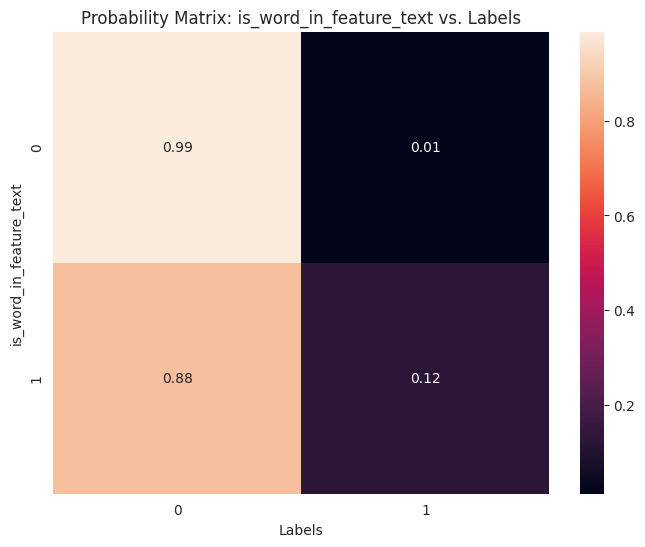

In [214]:
plot_cross_table_to_labels(word_train_df,"is_word_in_feature_text","word_label")

If the word doesn't appear in the feature text, there's only a 1% chance it's annotated. However, if the word does appear in the feature text, the annotation probability increases to 12%. This suggests that the feature text is a helpful indicator!

In [215]:
word_train_df = word_train_df.sort_values(["id","words_start_index"])

def add_i_near_word_feature(df: pd.DataFrame, column_feature_name: str, i: int, is_right: bool=True) -> pd.DataFrame:
  """
  Adds a feature to the DataFrame by shifting a specified column's values to the left or right by `i` positions.

  If the shift crosses to a different patient note (`id` mismatch), the value is set to -1.

  Parameters:
  - df (pd.DataFrame): The DataFrame.
  - column_feature_name (str): Column to shift.
  - i (int): Number of positions to shift.
  - is_right (bool): If True, shift right; otherwise, left. Default is True.

  Returns:
  - pd.DataFrame: Updated DataFrame with the new feature.
  """
  relative_place = "right" if is_right else "left"
  shift_val = i if is_right else -i
  df[f"is_{i}_{relative_place}_{column_feature_name}"] = df[column_feature_name].shift(shift_val,fill_value=-1)
  df.loc[(df.id.shift(shift_val) != df.id), f"is_{i}_{relative_place}_{column_feature_name}"] = -1
  return df

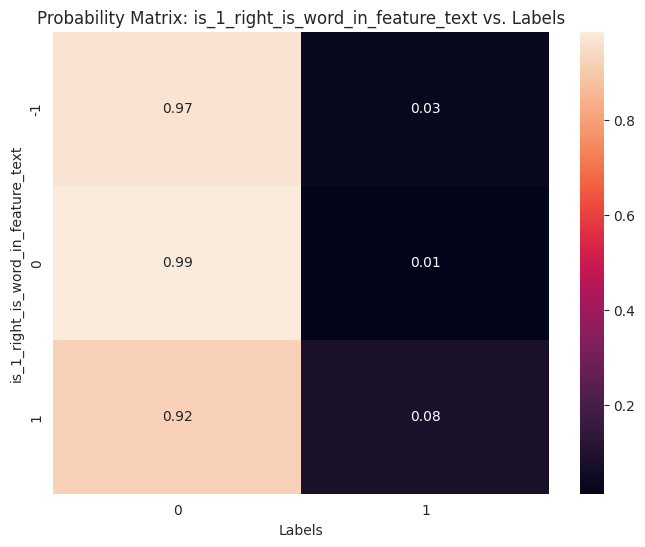

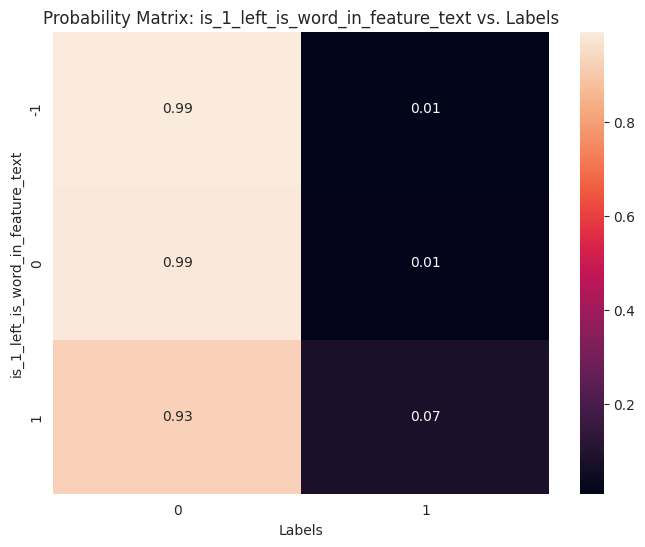

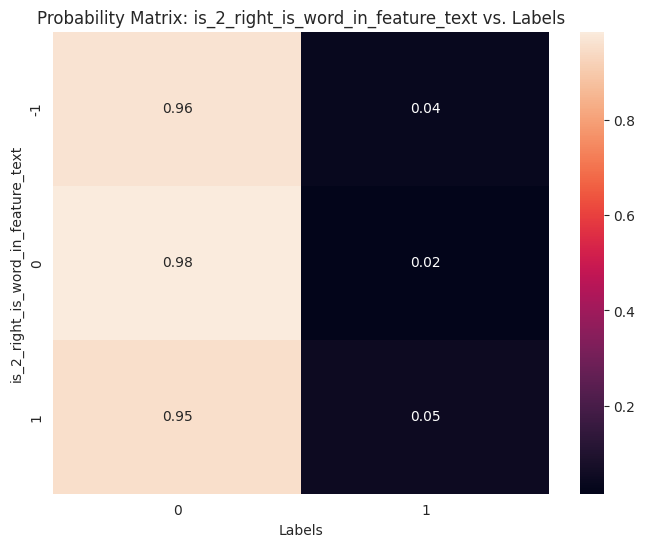

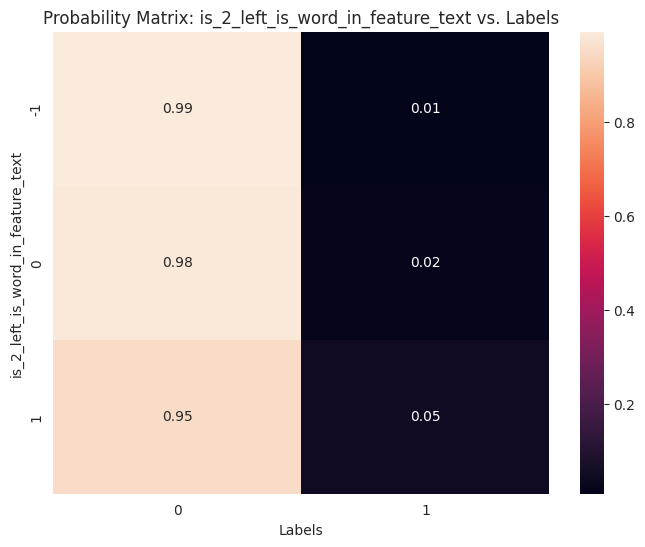

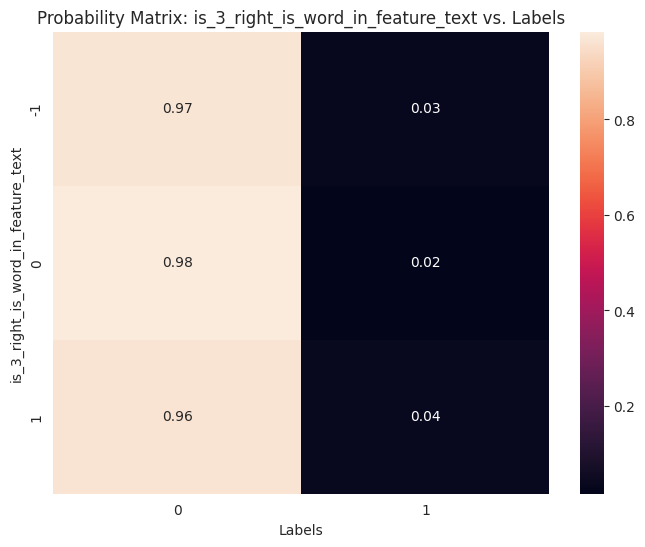

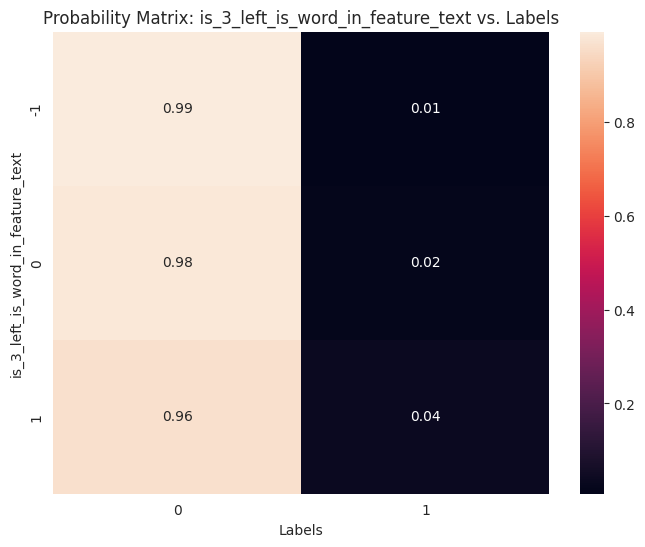

In [216]:
for i in range(1,4):
  for is_right in [True,False]:
    word_train_df = add_i_near_word_feature(word_train_df,"is_word_in_feature_text",i,is_right)
    relative_place = "right" if is_right else "left"
    plot_cross_table_to_labels(word_train_df, f"is_{i}_{relative_place}_is_word_in_feature_text", "word_label")

We can observe that the further a word is from the feature, the less informative the feature becomes.

<Axes: >

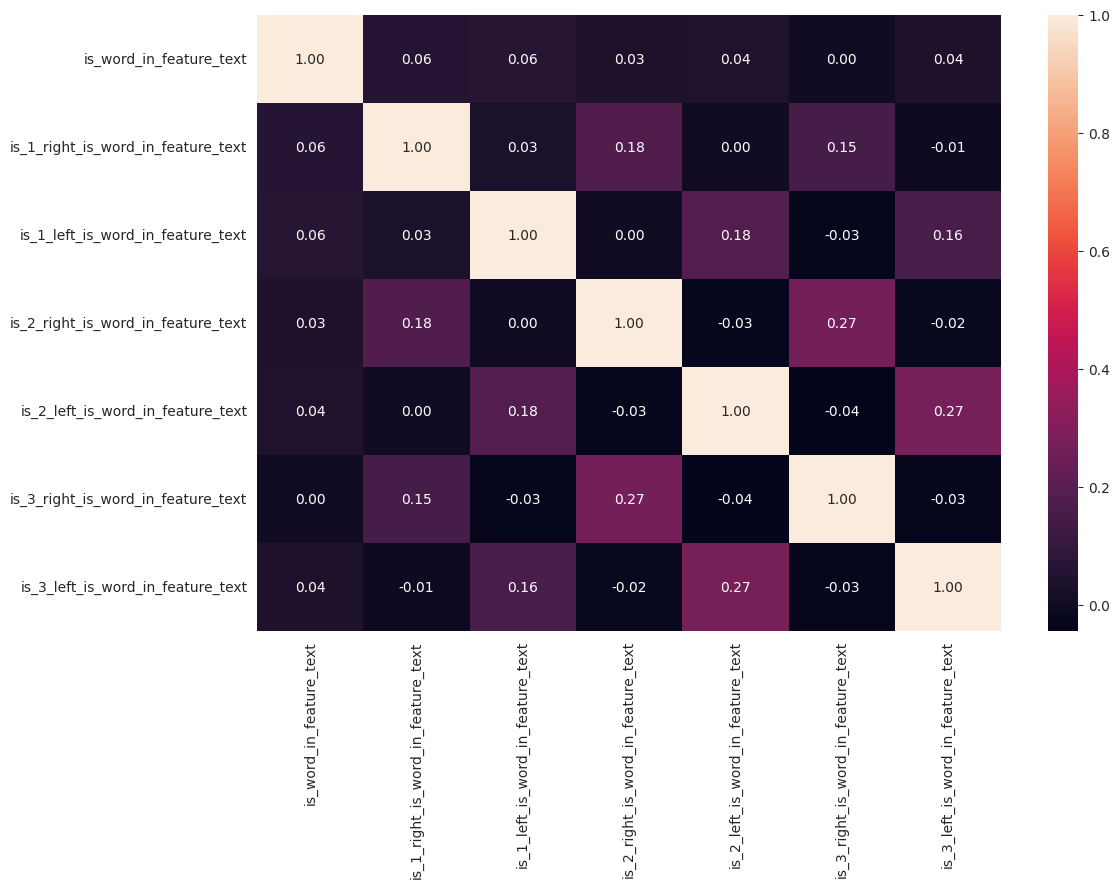

In [217]:
plt.figure(figsize=(12, 8))
in_feature_text_column_names = [column for column in word_train_df.columns if "in_feature_text" in column]
sns.heatmap(word_train_df.loc[:,in_feature_text_column_names].corr(), annot=True, fmt=".2f")

We can observe that the features exhibit low correlation.

#### First Attempt
Let's build a classifier based on the features in the feature text. Due to the discrete nature of the features, we'll use a simple decision tree classifier.

In [218]:
X = df_to_array(word_train_df.loc[:,["case_num","feature_num"]+in_feature_text_column_names])
y = word_train_df.word_label.astype(int)
y_char_level = word_train_df.word_labels
train_mask = get_df_mask_by_dataset_type(word_train_df,"train")
val_mask = get_df_mask_by_dataset_type(word_train_df,"val")

In [219]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(random_state=42)
classifier = eval_classifier(classifier, X, y, y_char_level, train_mask, val_mask)

Accuracy: 0.9848557110258348
AUC-ROC: 0.8488404235448154

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    401675
           1       0.74      0.21      0.33      7192

    accuracy                           0.98    408867
   macro avg       0.87      0.61      0.66    408867
weighted avg       0.98      0.98      0.98    408867

Micro f1 character level score 0.2900870541982589


Our initial attempt at building a classifier was not very successful, primarily due to a low recall percentage.

Additionally, our current approach does not account for spaces, which could impact performance.

Given the imbalanced nature of the data, we should explore balancing the classes. While this is likely to improve recall, it may come at the cost of precision.

In [220]:
classifier = DecisionTreeClassifier(class_weight="balanced",random_state=42)
classifier = eval_classifier(classifier, X, y, y_char_level, train_mask, val_mask)

Accuracy: 0.8154191949949494
AUC-ROC: 0.8481324951626024

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.90    401675
           1       0.07      0.75      0.13      7192

    accuracy                           0.82    408867
   macro avg       0.53      0.78      0.51    408867
weighted avg       0.98      0.82      0.88    408867

Micro f1 character level score 0.13211029008670944


Balancing the labels increased recall but negatively impacted precision, ultimately leading to a lower micro F1 score.

###Exploring Synonym Matching
In our EDA, we observed that most annotated words are not directly part of the feature text vocabulary.
Let's investigate whether the annotated words include synonyms of the feature text.

In [221]:
import nltk
from nltk.corpus import wordnet

nltk.download('wordnet')

def get_synonyms(text: str) -> str:
  """
  Generates a space-separated string of synonyms for each word in the input text.

  Args:
      text (str): The input text.

  Returns:
      str: A string containing synonyms of the words in the input text.
  """

  synonyms = []

  for word in text.lower().split():
    for syns in wordnet.synonyms(word):
      synonyms.extend(syns)

  return " ".join(synonyms).replace("_"," ")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [222]:
features_df['feature_synonyms'] = features_df['feature_text'].apply(get_synonyms)

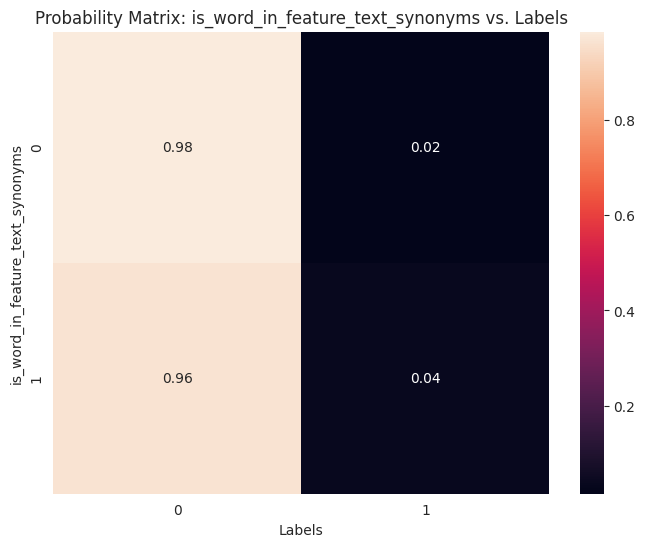

In [223]:
word_train_df = word_train_df.merge(features_df.loc[:,["feature_num","feature_synonyms"]],on="feature_num")
word_train_df["is_word_in_feature_text_synonyms"] = word_train_df.apply(lambda x: x.pn_history_word in x.feature_synonyms,axis=1).astype(int)
plot_cross_table_to_labels(word_train_df, "is_word_in_feature_text_synonyms", "word_label")

### Exploring the Use of Known Annotations
We can identify known annotated words and extract relevant features based on their presence.

In [224]:
annotated_words_mask = word_df_train_mask & (word_train_df.word_label == 1)
annotated_words_df = word_train_df.loc[annotated_words_mask, ["case_num", "feature_num", "pn_history_word"]]

annotated_words_sets_df = annotated_words_df.groupby(["case_num","feature_num"]).agg(set).reset_index()
annotated_words_sets_df = annotated_words_sets_df.rename(columns={"pn_history_word": "annotated_set"})
annotated_words_sets_df.head()

case_num  feature_num                                      annotated_set
0         0            0  {of, at, with, issues, cad, his, attack, for, ...
1         0            1  {issues, of, with, diease, issue, hyperthyroid...
2         0            2  {in, pressure, center, discomfort, of, like, h...
3         0            3  {comes, 3, months, come, intermittant, 6, rand...
4         0            4  {felt, to, he, that, out, were, presyncope, li...

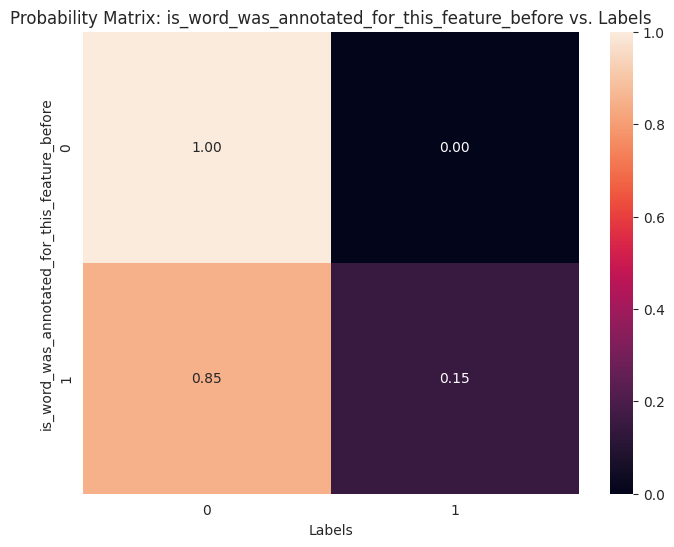

In [225]:
word_train_df = word_train_df.merge(annotated_words_sets_df,on=["case_num","feature_num"])
word_train_df["is_word_was_annotated_for_this_feature_before"] = word_train_df.apply(lambda x: x.pn_history_word in x.annotated_set,axis=1).astype(int)
plot_cross_table_to_labels(word_train_df,"is_word_was_annotated_for_this_feature_before","word_label")

Interestingly, we observe that 85% of the time when a word appears that was previously annotated, it remains unannotated. This could be due to the presence of stopwords. Let's add this information as a feature:

In [226]:
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

word_train_df["is_stopword"] = word_train_df["pn_history_word"].apply(lambda word: 1 if word in stop_words else 0)

word_train_df["is_stopword"].value_counts()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


is_stopword
0    1363927
1     609405
Name: count, dtype: int64

Unsurprisingly, patient notes contain a significant number of stopwords.

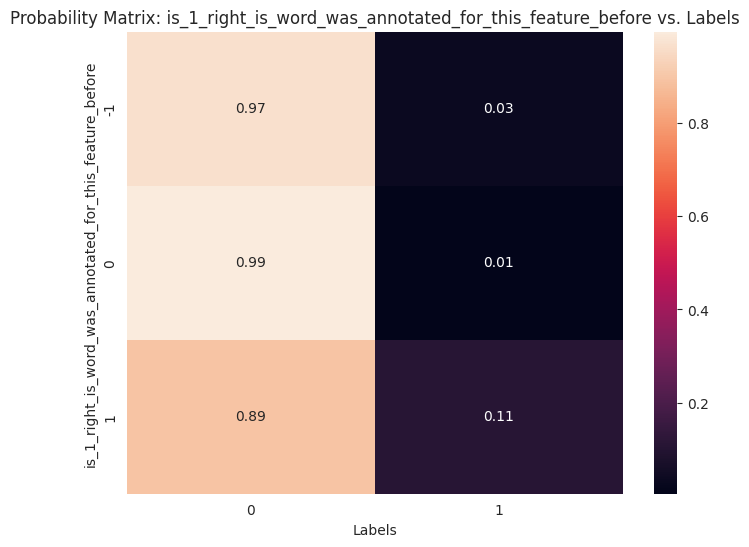

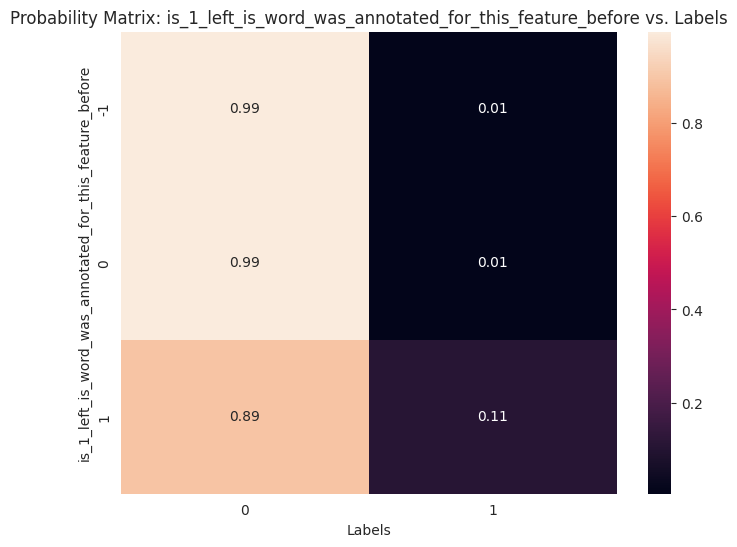

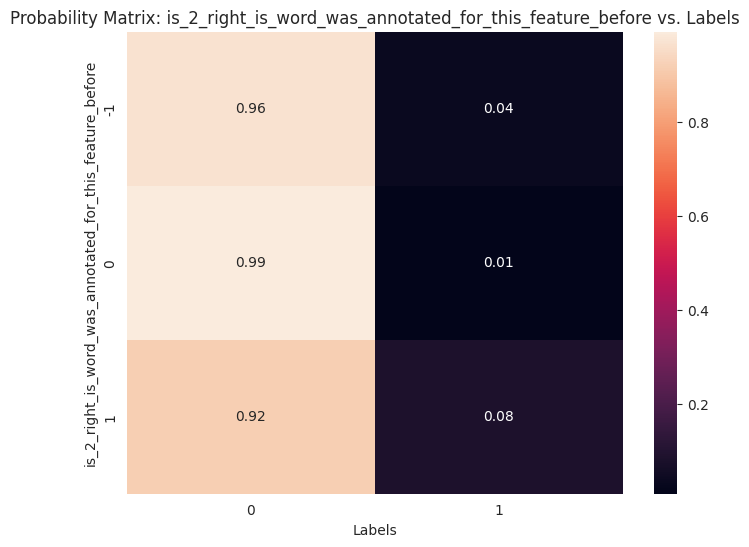

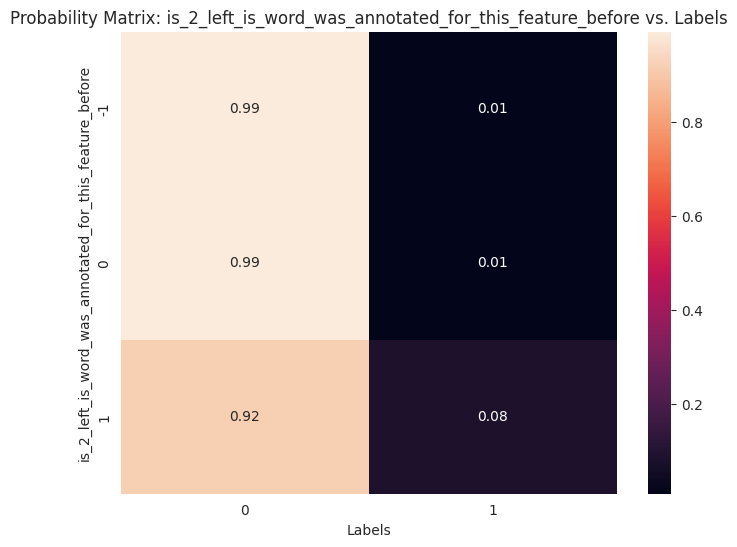

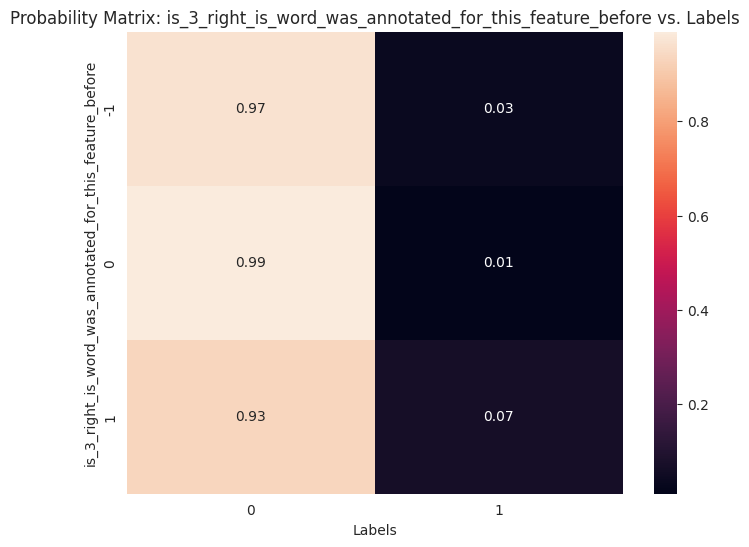

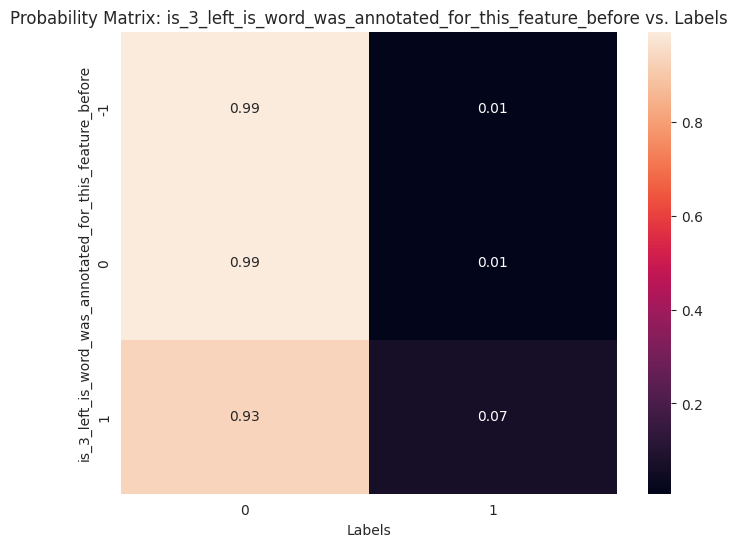

In [227]:
for i in range(1,4):
  for is_right in [True,False]:
    word_train_df = add_i_near_word_feature(word_train_df,"is_word_was_annotated_for_this_feature_before",i,is_right)
    relative_place = "right" if is_right else "left"
    plot_cross_table_to_labels(word_train_df, f"is_{i}_{relative_place}_is_word_was_annotated_for_this_feature_before", "word_label")

Similar to previous features, the further away a word is, the less informative the feature becomes.

#### Second Attempt

In [228]:
features = [column for column in word_train_df.columns if column not in [
                                                                         "feature_text",
                                                                         "id",
                                                                         "annotation",
                                                                         "location",
                                                                         "annotation_amount",
                                                                         "labels",
                                                                         "word_label",
                                                                         "pn_history",
                                                                         "feature_synonyms",
                                                                         "pn_history_word",
                                                                         "word_start_index",
                                                                         "word_end_index",
                                                                         "word_labels",
                                                                         "annotated_set"]]

In [229]:
X = df_to_array(word_train_df.loc[:,features])

classifier = DecisionTreeClassifier(random_state=42)

classifier = eval_classifier(classifier, X, y, y_char_level, train_mask, val_mask, do_standard_scaling=False)

Accuracy: 0.9869859881086026
AUC-ROC: 0.7852002077576568

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    401675
           1       0.65      0.58      0.61      7192

    accuracy                           0.99    408867
   macro avg       0.82      0.79      0.80    408867
weighted avg       0.99      0.99      0.99    408867

Micro f1 character level score 0.6085701426287772


We significantly improved recall, achieving a Micro F1 score of 0.61, although this was without handling spaces.

## Classifying Tokens Using DeBERTa Embeddings
DeBERTa is a transformer-based language model that was pretrained using masked language modeling on a large and diverse corpus.

- DeBERTa processes text segments as input, but before passing the text to the model, it must be tokenized — this means splitting the text into smaller units, each of which is represented by a numerical value.
- The output of DeBERTa consists of embeddings (vectors), with one embedding generated for each token. These embeddings capture the semantics and context of the respective tokens, which according to the EDA are critical for our task.

In the following steps, we’ll explore various methods for leveraging these embeddings to build an effective classifier.

Instantiating Deberta:

In [230]:
from transformers import AutoModel
from transformers import AutoTokenizer,DebertaTokenizerFast

In [231]:
MODEL_NAME = "microsoft/deberta-base"

In [232]:
tokenizer = DebertaTokenizerFast.from_pretrained(MODEL_NAME)

In [384]:
embeddings_model = AutoModel.from_pretrained(MODEL_NAME)
embeddings_model

DebertaModel(
  (embeddings): DebertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=0)
    (LayerNorm): DebertaLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): DebertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x DebertaLayer(
        (attention): DebertaAttention(
          (self): DisentangledSelfAttention(
            (in_proj): Linear(in_features=768, out_features=2304, bias=False)
            (pos_dropout): Dropout(p=0.1, inplace=False)
            (pos_proj): Linear(in_features=768, out_features=768, bias=False)
            (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): DebertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): DebertaLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): DebertaIntermediate(
 

#### Tokenizing Patient Notes and Feature Text
DeBERTa can accept either a single tokenized text segment or a pair of text segments as input.

We will experiment with both approaches - passing the patient note and feature text separately, as well as combining them together.

In [234]:
def tokenize_pandas_series(series: pd.Series):
  """
  Tokenizes a pandas Series of text into tokenized inputs using DeBERTa tokenizer.

  Args:
      series (pd.Series): A pandas Series containing the text data to be tokenized.

  Returns:
      dict like object containing tokenized tensors and offset mappings.
  """
  return tokenizer(
      series.str.lower().tolist(),
      padding=True,
      return_tensors="pt",
      return_offsets_mapping=True
  )

def tokenize_pandas_series_pair(series1: pd.Series, series2: pd.Series):
    """
    Tokenizes two pandas Series of text into tokenized inputs using DeBERTa tokenizer.

    Args:
        series1 (pd.Series): The first pandas Series containing the first set of text data.
        series2 (pd.Series): The second pandas Series containing the second set of text data.

    Returns:
        ict like object containing tokenized tensors and offset mappings for both input text segments.
    """
    tokenized = tokenizer(
        series1.str.lower().tolist(),
        series2.str.lower().tolist(),
        padding=True,
        return_tensors="pt",
        return_offsets_mapping=True
    )
    return tokenized

In [235]:
encoded_patient_notes = tokenize_pandas_series(pn_df.loc[pn_df.in_train, "pn_history"])
encoded_feature_text = tokenize_pandas_series(features_df["feature_text"])
encoded_patient_feature_pairs = tokenize_pandas_series_pair(train_df.pn_history, train_df.feature_text)

In [236]:
def check_special_tokens(encoded_inputs):
  """
  Checks and prints the percentage of special tokens (e.g., 'unknown' and 'pad')
  in the given encoded inputs.

  Args:
      encoded_inputs: A dict like object containing the tokenized inputs,
                      with 'input_ids' as a key and the corresponding tensor as its value.

  Returns:
      None: This function prints the percentage of special tokens but does not return any value.
  """

  special_tokens = {"unknown": 100, "pad": 0}
  for special_token_type, special_token_id in special_tokens.items():
    count = torch.sum(encoded_inputs["input_ids"] == special_token_id).item()
    total_elements = encoded_inputs["input_ids"].numel()
    percentage = (count / total_elements) * 100

    print(f"Percentage of {special_token_type} in the tensor: {percentage:.2f}%")

check_special_tokens(encoded_patient_notes)
check_special_tokens(encoded_feature_text)
check_special_tokens(encoded_patient_feature_pairs)

Percentage of unknown in the tensor: 0.00%
Percentage of pad in the tensor: 27.75%
Percentage of unknown in the tensor: 0.00%
Percentage of pad in the tensor: 60.39%
Percentage of unknown in the tensor: 0.00%
Percentage of pad in the tensor: 29.34%


Move data to gpu:

In [237]:
def move_data_to_device(encoded_inputs: dict[str, torch.Tensor],device: str="cpu"):
  return {key: value.to(device) if isinstance(value, torch.Tensor) else value for key, value in encoded_inputs.items()}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# embeddings_model = embeddings_model.to(device)
# encoded_patient_notes_to_model = move_data_to_device(encoded_patient_notes,device)
# encoded_feature_text_to_model = move_data_to_device(encoded_feature_text,device)
# encoded_patient_feature_pairs_to_model = move_data_to_device(encoded_patient_feature_pairs,device)

Get embeddings:

In [238]:
def process_batch(batch_input_ids: torch.Tensor, batch_attention_mask: torch.Tensor) -> torch.Tensor:
  """
  Processes a batch of input IDs and attention masks through the embeddings model.

  Args:
      batch_input_ids (torch.Tensor): Tokenized input IDs for the batch.
      batch_attention_mask (torch.Tensor): Attention mask for the batch.

  Returns:
      torch.Tensor: The last hidden state of the embeddings for the batch, moved to CPU.
  """
  with torch.no_grad():
    outputs = embeddings_model(batch_input_ids, attention_mask=batch_attention_mask)
  return outputs.last_hidden_state.to("cpu")

def get_embeddings(encoded_inputs, batch_size: int = 100) -> torch.Tensor:
  """
  Computes embeddings for tokenized input text using the embeddings model.

  Args:
      encoded_inputs: A dict like object containing tokenized inputs
          with 'input_ids' and 'attention_mask' as keys.
      batch_size (int, optional): The number of samples to process per batch. Defaults to 100.

  Returns:
      torch.Tensor: A tensor containing the concatenated last hidden states of all input sequences.
  """
  input_ids = encoded_inputs["input_ids"]
  attention_mask = encoded_inputs["attention_mask"]
  all_last_hidden_states = []

  for start_idx in tqdm(range(0, input_ids.size(0), batch_size), desc="Processing batches"):
    end_idx = min(start_idx + batch_size, input_ids.size(0))
    batch_input_ids = input_ids[start_idx:end_idx]
    batch_attention_mask = attention_mask[start_idx:end_idx]

    batch_embeddings = process_batch(batch_input_ids, batch_attention_mask)
    all_last_hidden_states.append(batch_embeddings)

  return torch.cat(all_last_hidden_states, dim=0)


In [239]:
# patient_notes_embeddings = get_embeddings(encoded_patient_notes_to_model)
# feature_text_embeddings = get_embeddings(encoded_feature_text_to_model)
# patient_feature_pairs_embeddings = get_embeddings(encoded_patient_feature_pairs_to_model)

Clean gpu:

In [240]:
# embeddings_model.to("cpu")
# #clean gpu:
# if torch.cuda.is_available():
#     torch.cuda.reset_max_memory_allocated()
#     torch.cuda.reset_max_memory_cached()
#     print("GPU cache cleared.")
# else:
#     print("No GPU available.")

In [241]:
# """back up for the embeddings"""
# import os

# def save_embeddings(embeddings: torch.Tensor, filename: str):
#   """Saves embeddings to a file.

#   Args:
#     embeddings: The embeddings to save.
#     filename: The name of the file to save to.
#   """
#   torch.save(embeddings, filename)


# backups_dir = "embeddings_backups"
# os.makedirs(backups_dir, exist_ok=True)

# save_embeddings(patient_notes_embeddings, os.path.join(backups_dir, f"{BASE_DIRECTORY}patient_notes_embeddings.pt"))
# save_embeddings(feature_text_embeddings, os.path.join(backups_dir, f"{BASE_DIRECTORY}feature_text_embeddings.pt"))
# save_embeddings(patient_feature_pairs_embeddings, os.path.join(backups_dir, f"{BASE_DIRECTORY}patient_feature_pairs_embeddings.pt"))

# print("Embeddings saved successfully to the 'embeddings_backups' directory.")

Load embeddings from disk:

In [242]:
patient_notes_embeddings = torch.load(f"{BASE_DIRECTORY}patient_notes_embeddings.pt")
feature_text_embeddings = torch.load(f"{BASE_DIRECTORY}feature_text_embeddings.pt")


<ipython-input-242-481423a1fe73>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  patient_notes_embeddings = torch.load(f"{BASE_DIRECTORY}patient_notes_embeddings.pt")
<ipyt

Creating labeled token df:

In [243]:
column_name_to_tensor = {"token_id":encoded_patient_notes["input_ids"],
                         "embeddings":patient_notes_embeddings,
                         "embeddings_slice":encoded_patient_notes["offset_mapping"]}

def add_tensors_to_df(df: pd.DataFrame,
                      column_name_to_tensor: dict[str,torch.Tensor]) -> pd.DataFrame:
  """
  Adds tensor values as new columns to a pandas DataFrame.

  Each tensor in `column_name_to_tensor` should have a length matching the number of rows in `df`.
  The function converts each tensor to a list and assigns it to the corresponding column in `df`.

  Args:
      df (pd.DataFrame): The DataFrame to which tensors should be added.
      column_name_to_tensor (Dict[str, torch.Tensor]): A dictionary where keys are column names
          and values are tensors of the same length as `df`.

  Returns:
      pd.DataFrame: The updated DataFrame with new columns containing tensor values.
  """
  for column_name, tensor in column_name_to_tensor.items():
    df[column_name] = list(tensor.numpy())
  return df

def create_pn_with_tokens_list_df(column_name_to_tensor: dict[str,torch.Tensor]) -> pd.DataFrame:
  pn_with_tokens_list_df = pn_df.loc[pn_df.in_train, ["case_num","pn_num","pn_history"]]
  pn_with_tokens_list_df = add_tensors_to_df(pn_with_tokens_list_df,column_name_to_tensor)
  return pn_with_tokens_list_df

def split_slice_column(df: pd.DataFrame,
                       column_name: str,
                       remove_zero_end_tokens: bool = True) -> pd.DataFrame:
  """
  Splits a column containing start and end indices into two separate columns.

  The function assumes that the specified column contains tuples or lists of size 2,
  representing (start, end) indices. It creates two new columns: `<column_name>_start`
  and `<column_name>_end`, then drops the original column.

  Optionally, it removes rows where the end index is zero.

  Args:
      df (pd.DataFrame): The DataFrame containing the column to split.
      column_name (str): The name of the column containing (start, end) index pairs.
      remove_zero_end_tokens (bool, optional): If True, removes rows where the end index is zero.
          Defaults to True.

  Returns:
      pd.DataFrame: The updated DataFrame with separate start and end columns.
  """

  df[f"{column_name}_start"] = df[column_name].apply(lambda x: x[0])
  df[f"{column_name}_end"] = df[column_name].apply(lambda x: x[1])
  df.drop(column_name, axis=1, inplace=True)
  if remove_zero_end_tokens:
    df = df[df[f"{column_name}_end"] != 0]
  return df

def slice_labels_for_df(df: pd.DataFrame,
                        label_column_name: str,
                        start_slice_column_name: str,
                        end_slice_column_name: str) -> pd.Series:
  """
  Extracts a slice from a label column based on start and end indices.

  Args:
      df (pd.DataFrame): The DataFrame containing the label column and slice indices.
      label_column_name (str): Name of the column containing sequences (e.g., lists, strings).
      start_slice_column_name (str): Column name containing the start index for slicing.
      end_slice_column_name (str): Column name containing the end index for slicing.

  Returns:
      pd.Series: A Series containing the sliced label values for each row.
  """
  return df.apply(lambda x: x[label_column_name][x[start_slice_column_name]:x[end_slice_column_name]], axis=1)

def add_train_data_to_pn_tokens_df(pn_tokens_df: pd.DataFrame) -> pd.DataFrame:
  """
  Merges training data into `pn_tokens_df` and slices labels.

  Joins `pn_tokens_df` with `train_df` on "pn_num" to add training data, then slices the "labels" column
  using start and end indices.

  Args:
    pn_tokens_df (pd.DataFrame): DataFrame with patient note tokens.

  Returns:
    pd.DataFrame: Updated DataFrame with merged training data and sliced labels.
  """
  pn_tokens_df = pn_tokens_df.merge(
      train_df.loc[:, ["id", "pn_num", "feature_num", "feature_text", "labels"]],
      right_on="pn_num",
      left_on="pn_num"
  )

  pn_tokens_df["labels"] = slice_labels_for_df(
      pn_tokens_df, "labels", "embeddings_slice_start", "embeddings_slice_end"
  )

  return pn_tokens_df



def create_pn_tokens_df(column_name_to_tensor: dict[str, torch.Tensor]) -> pd.DataFrame:
  """
  Creates a DataFrame of tokenized patient notes with extracted token text.

  Args:
      column_name_to_tensor (Dict[str, torch.Tensor]): Mapping of column names to token tensors.

  Returns:
      pd.DataFrame: DataFrame where each row represents a token with its metadata.
  """
  pn_tokens_df = create_pn_with_tokens_list_df(column_name_to_tensor)
  pn_tokens_df = pn_tokens_df.explode(list(column_name_to_tensor.keys()))
  pn_tokens_df = split_slice_column(pn_tokens_df,
                                    "embeddings_slice")
  pn_tokens_df["token_text"] = pn_tokens_df.apply(lambda x: x["pn_history"][x["embeddings_slice_start"]:x["embeddings_slice_end"]],
                                                  axis=1)
  return pn_tokens_df

def add_data_to_pn_token_df(pn_token_df: pd.DataFrame,
                            pn_token_df_to_add: pd.DataFrame,
                            columns: None or list[str] = None) -> pd.DataFrame:
  """
  Merges additional data into `pn_token_df` based on "pn_num" and "embeddings_slice_start".

  Args:
      pn_token_df (pd.DataFrame): The main DataFrame with patient note tokens.
      pn_token_df_to_add (pd.DataFrame): DataFrame containing additional data to merge.
      columns (Optional[list[str]]): Specific columns to add; if None, all columns are included.

  Returns:
      pd.DataFrame: Updated DataFrame with merged data.
  """

  join_on = ["pn_num","embeddings_slice_start"]
  columns_to_return = columns+join_on if columns is not None else pn_token_df_to_add.columns
  return pn_token_df.merge(pn_token_df_to_add.loc[:,columns_to_return],
                           on=join_on)

def add_data_from_features_df(df: pd.DataFrame,
                              features_df: pd.DataFrame,
                              columns: None or list[str] = None) -> pd.DataFrame:
  """
  Merges additional feature data into `df` based on "feature_num" and "case_num".

  Args:
      df (pd.DataFrame): The main DataFrame to which feature data is merged.
      features_df (pd.DataFrame): DataFrame containing feature data to merge.
      columns (Optional[List[str]]): Specific columns to add; if None, all columns are included.

  Returns:
      pd.DataFrame: Updated DataFrame with merged feature data.
  """
  join_on = ["feature_num","case_num"]
  columns_to_return = columns+join_on if columns is not None else features_df.columns
  return df.merge(features_df.loc[:,columns_to_return],
                          left_on=join_on,
                          right_on=join_on)

In [244]:
pn_tokens_df = create_pn_tokens_df(column_name_to_tensor)
token_df = add_train_data_to_pn_tokens_df(pn_tokens_df)
token_df.head()
token_df_train_mask = get_df_mask_by_dataset_type(token_df,"train")

Let's check how frequent all the tokens characters are classified the same - means that the std of the labels is 0.

In [245]:
labels_sum = token_df.loc[token_df_train_mask].labels.apply(sum)
labels_length = token_df.loc[token_df_train_mask].labels.apply(len)
zero_std_condition = (labels_sum == 0) | (labels_sum == labels_length)
zero_std_percentage = (zero_std_condition.sum() / len(token_df.loc[token_df_train_mask])) * 100
print(f'{zero_std_percentage=}')


zero_std_percentage=99.57853268392547


As we can see, at almost every case we can use only one label of the first character know the classifications of the entire token characters.

Let's try to build a classifier that will classify each token. We will use the label of the first character of each token for the entrie token:

In [246]:
token_df["token_label"] = token_df.labels.apply(lambda x: x[0])
token_df.head()

case_num  pn_num                                         pn_history  \
0         0      16  HPI: 17yo M presents with palpitations. Patien...   
1         0      16  HPI: 17yo M presents with palpitations. Patien...   
2         0      16  HPI: 17yo M presents with palpitations. Patien...   
3         0      16  HPI: 17yo M presents with palpitations. Patien...   
4         0      16  HPI: 17yo M presents with palpitations. Patien...   

  token_id                                         embeddings  \
0      298  [0.21863481, -0.048369, -0.7828458, 0.03318149...   
1      298  [0.21863481, -0.048369, -0.7828458, 0.03318149...   
2      298  [0.21863481, -0.048369, -0.7828458, 0.03318149...   
3      298  [0.21863481, -0.048369, -0.7828458, 0.03318149...   
4      298  [0.21863481, -0.048369, -0.7828458, 0.03318149...   

   embeddings_slice_start  embeddings_slice_end token_text         id  \
0                       0                     1          H  00016_000   
1                       0                     1          H  00016_001   
2                       0                     1          H  00016_002   
3                       0                     1          H  00016_003   
4                       0                     1          H  00016_004   

   feature_num                                       feature_text labels  \
0            0  Family history of MI OR Family history of myoc...  [0.0]   
1            1                 Family history of thyroid disorder  [0.0]   
2            2                                     Chest pressure  [0.0]   
3            3                              Intermittent symptoms  [0.0]   
4            4                                        Lightheaded  [0.0]   

   token_label  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0

#### Explore Cosine Similarity
- We will experiment with building a classifier that leverages the similarity between the embedding of the average feature text and the token embeddings.
- One widely used approach in NLP for measuring this similarity is cosine similarity:

$$
\text{Cosine Similarity}(\mathbf{A}, \mathbf{B}) = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|} = \frac{\sum_{i=1}^n A_i B_i}{\sqrt{\sum_{i=1}^n A_i^2} \sqrt{\sum_{i=1}^n B_i^2}}
$$


In [247]:
feature_text_averages = [
  embeddings[encoded_feature_text["attention_mask"][i]==1].mean(dim=0).numpy()
  for i, embeddings in enumerate(list(feature_text_embeddings))
]

features_df["feature_text_embedding"] = feature_text_averages
token_df = add_data_from_features_df(token_df,features_df,columns=["feature_text_embedding"])

In [248]:
def compute_cosine_similarity_batchwise(embedding_series1: pd.Series,
                                        embedding_series2: pd.Series,
                                        batch_size: int):
  """
  Compute cosine similarity for two pandas series in smaller batches to avoid OOM.
  """
  similarities = []
  num_rows = len(embedding_series1)
  for start in tqdm(range(0, num_rows, batch_size), desc="Processing batches"):
      end = min(start + batch_size, num_rows)
      batch_similarity = compute_cosine_similarity_for_series(embedding_series1.iloc[start:end],
                                                              embedding_series2.iloc[start:end])
      similarities.extend(batch_similarity)
  return similarities

def compute_cosine_similarity_for_series(embedding_series1: pd.Series,
                                         embedding_series2: pd.Series):
  """
  Compute cosine similarity for two pandas series.
  """
  embeddings1 = series_of_array_to_array(embedding_series1)
  embeddings2 = series_of_array_to_array(embedding_series2)
  return compute_cosine_similarity_for_pairs(embeddings1,embeddings2)

def series_of_array_to_array(series: pd.Series) -> np.ndarray:
  """
  Converts a pandas Series of arrays into a single NumPy array.

  Args:
      series (pd.Series): A pandas Series where each element is an array.

  Returns:
      np.ndarray: A stacked NumPy array created from the Series of arrays.
  """
  return np.stack(series.to_numpy())

def compute_cosine_similarity_for_pairs(embedding1: np.ndarray, embedding2: np.ndarray) -> float:
  """
  Compute cosine similarity for two numpy arrays.
  """
  return np.sum(embedding1 * embedding2, axis=1)/(np.linalg.norm(embedding1, axis=1) * np.linalg.norm(embedding2, axis=1))

In [249]:
token_df["similarity_to_feature_text_embeddings"] = compute_cosine_similarity_batchwise(
                                    token_df['embeddings'],
                                    token_df['feature_text_embedding'],
                                    100_000)

Processing batches: 100%|██████████| 31/31 [00:14<00:00,  2.08it/s]


plot cosine similarity:

In [250]:
def plot_kde_for_column(column_to_plot: str, title: str, ax, token_df) -> None:
    """
    Plot KDE for a specific column grouped by labels.

    Args:
        column_to_plot (str): The name of the column to plot.
        title (str): Title for the subplot.
        ax: Matplotlib axis object to plot on.
        token_df: DataFrame containing the data.
    """
    train_mask = get_df_mask_by_dataset_type(token_df,"train")
    for label in token_df.loc[train_mask,'token_label'].unique():
        subset = token_df[train_mask & token_df['token_label'] == label]
        sns.kdeplot(subset[column_to_plot], label=str(label), fill=True, ax=ax)
    ax.set_xlabel("Cosine Similarity")
    ax.set_title(title)
    ax.grid(True, alpha=0.5)
    ax.legend(title="Labels")

def plot_kde_side_by_side(columns_to_plot: list[str], titles: list[str], token_df) -> None:
    """
    Plot KDE distributions for multiple columns side by side.

    Args:
        columns_to_plot (list[str]): List of column names to plot.
        titles (list[str]): List of titles for each subplot.
        token_df: DataFrame containing the data.
    """
    n_cols = len(columns_to_plot)
    fig, axes = plt.subplots(1, n_cols, figsize=(10 * n_cols, 6), sharey=True)

    for ax, column_to_plot, title in zip(axes, columns_to_plot, titles):
        plot_kde_for_column(column_to_plot, title, ax, token_df)
    plt.tight_layout()
    plt.show()

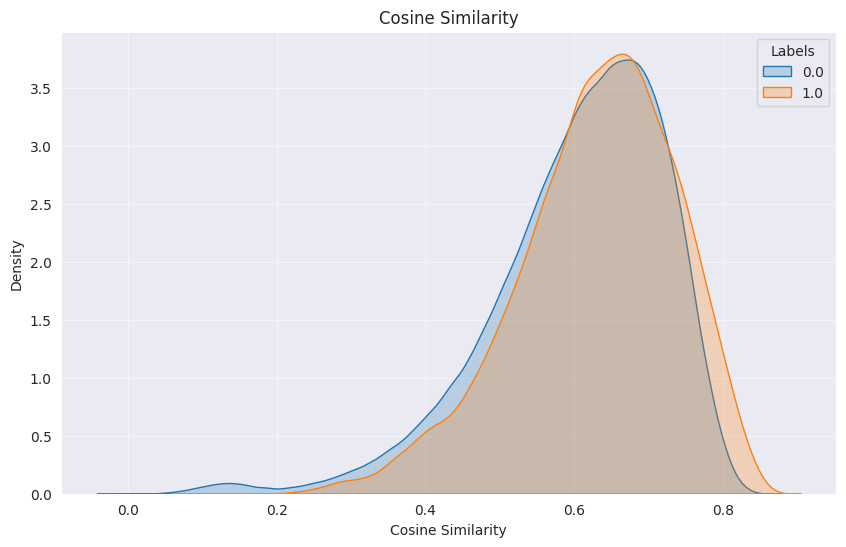

In [251]:
plt.figure(figsize=(10, 6))
plot_kde_for_column("similarity_to_feature_text_embeddings","Cosine Similarity", plt.gca(), token_df)

Unfortunately, there is only a slight difference between an annotated token and a non-annotated one.

Each embedding consists of over 700 dimensions, making the dataset large and challenging to work with. Additionally, only a subset of these dimensions may be informative, while others could remain largely unchanged.

To explore this, we will:

1. Compute the correlation between the labels and the individual dimensions.
2. Apply PCA for dimensionality reduction.

##### Reducing Dimensions

Correlation:

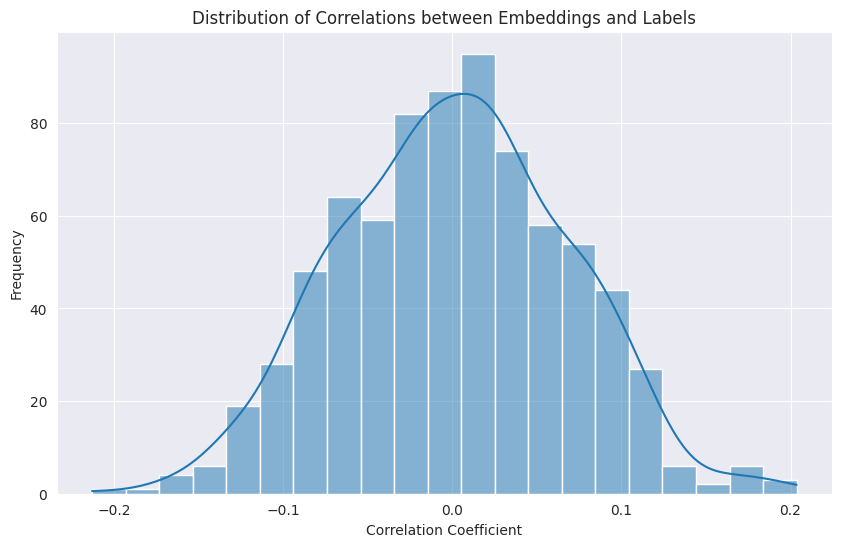

In [252]:
columns_for_embeddings_group_by = ["pn_num","embeddings_slice_start","embeddings_slice_end"]
columns_for_corr = ["embeddings","token_label"]

check_embeddings_corr_df = token_df.loc[token_df_train_mask,columns_for_embeddings_group_by+columns_for_corr]

check_embeddings_corr_df["token_label"] = check_embeddings_corr_df.token_label.astype(int).to_numpy()
check_embeddings_corr_df = (
    check_embeddings_corr_df
    .groupby(columns_for_embeddings_group_by)
    .agg(
        embeddings=("embeddings", lambda x: x.iloc[0]),
        labels=("token_label", "mean")
    )
    .reset_index(drop=True)
)

embeddings_array = np.vstack(check_embeddings_corr_df.embeddings.to_numpy())
labels_array = check_embeddings_corr_df.labels.to_numpy()

correlations = []

for i in range(embeddings_array.shape[1]):
    correlations.append(np.corrcoef(embeddings_array[:, i], labels_array)[0, 1]
)

plt.figure(figsize=(10, 6))
sns.histplot(correlations, kde=True)
plt.title("Distribution of Correlations between Embeddings and Labels")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Frequency")
plt.show()

As we can see, most dimensions have an absolute correlation coefficient with the labels of less than 0.1. Later, we will attempt to filter these out and see if we can achieve better results. But first, let's apply PCA.

PCA:

In [253]:
combined_embeddings = np.concatenate([
    np.stack(features_df['feature_text_embedding'].to_numpy()),
    np.stack(pn_tokens_df['embeddings'].to_numpy())
], axis=0)

In [254]:
from sklearn.decomposition import PCA

def get_trained_pca(data: np.ndarray, train_mask: np.ndarray) -> PCA:
  """
  Trains a PCA model on the given data using the specified training mask.

  Args:
      data (np.ndarray): The dataset to perform PCA on.
      train_mask (np.ndarray): A boolean mask to select the training data.

  Returns:
      PCA: The trained PCA model.
  """
  pca = PCA()
  pca.fit(data[train_mask])
  return pca

def plot_explained_variance(pca: PCA) -> None:
  """
  Plots the cumulative explained variance ratio from a trained PCA model.

  Args:
      pca (PCA): A trained PCA model from which the explained variance is extracted.

  Returns:
      None: Displays the plot showing cumulative explained variance.
  """
  explained_variance = pca.explained_variance_ratio_
  cumulative_variance = np.cumsum(explained_variance)

  plt.figure(figsize=(12, 6))
  plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', label='Cumulative Variance')
  plt.title('Explained Variance by PCA Components')
  plt.xlabel('Principal Component')
  plt.ylabel('Explained Variance Ratio')
  plt.xticks(range(1, len(explained_variance) + 1, max(len(explained_variance) // 10, 1)))  # Adjust x-axis ticks
  plt.legend()
  plt.show()


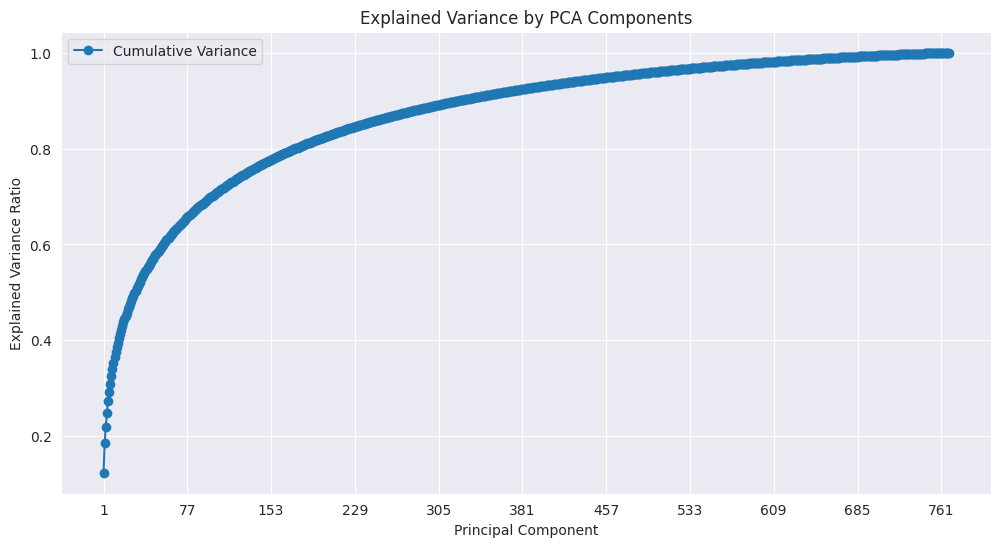

In [255]:
train_mask = len(features_df)*[True]+get_df_mask_by_dataset_type(pn_tokens_df, "train").tolist()
pca = get_trained_pca(combined_embeddings, train_mask)
pca_result = pca.transform(combined_embeddings)
plot_explained_variance(pca)

In [256]:
del check_embeddings_corr_df
del embeddings_array
del labels_array

As we can see, we can reduce the embeddings to 100 dimensions and still retain approximately 70% of the explained variance.

Let's examine how PCA and filtering by correlation affect the cosine similarity distributions:

In [257]:
pn_tokens_df["pca_reduced_embeddings"] = list(pca_result[len(features_df):,:100])
features_df["pca_reduced_feature_text_embeddings"] = list(pca_result[:len(features_df),:100])

embeddings_dimensions_mask = [abs(corr) > 0.1 for corr in correlations]

pn_tokens_df["filtered_embeddings"] = list(combined_embeddings[len(features_df):,embeddings_dimensions_mask])
features_df["filtered_feature_text_embeddings"] = list(combined_embeddings[:len(features_df),embeddings_dimensions_mask])

token_df = add_data_to_pn_token_df(token_df, pn_tokens_df,columns=["pca_reduced_embeddings","filtered_embeddings"])
token_df = add_data_from_features_df(token_df, features_df, columns=["pca_reduced_feature_text_embeddings","filtered_feature_text_embeddings"])

Processing batches: 100%|██████████| 31/31 [00:06<00:00,  4.95it/s]


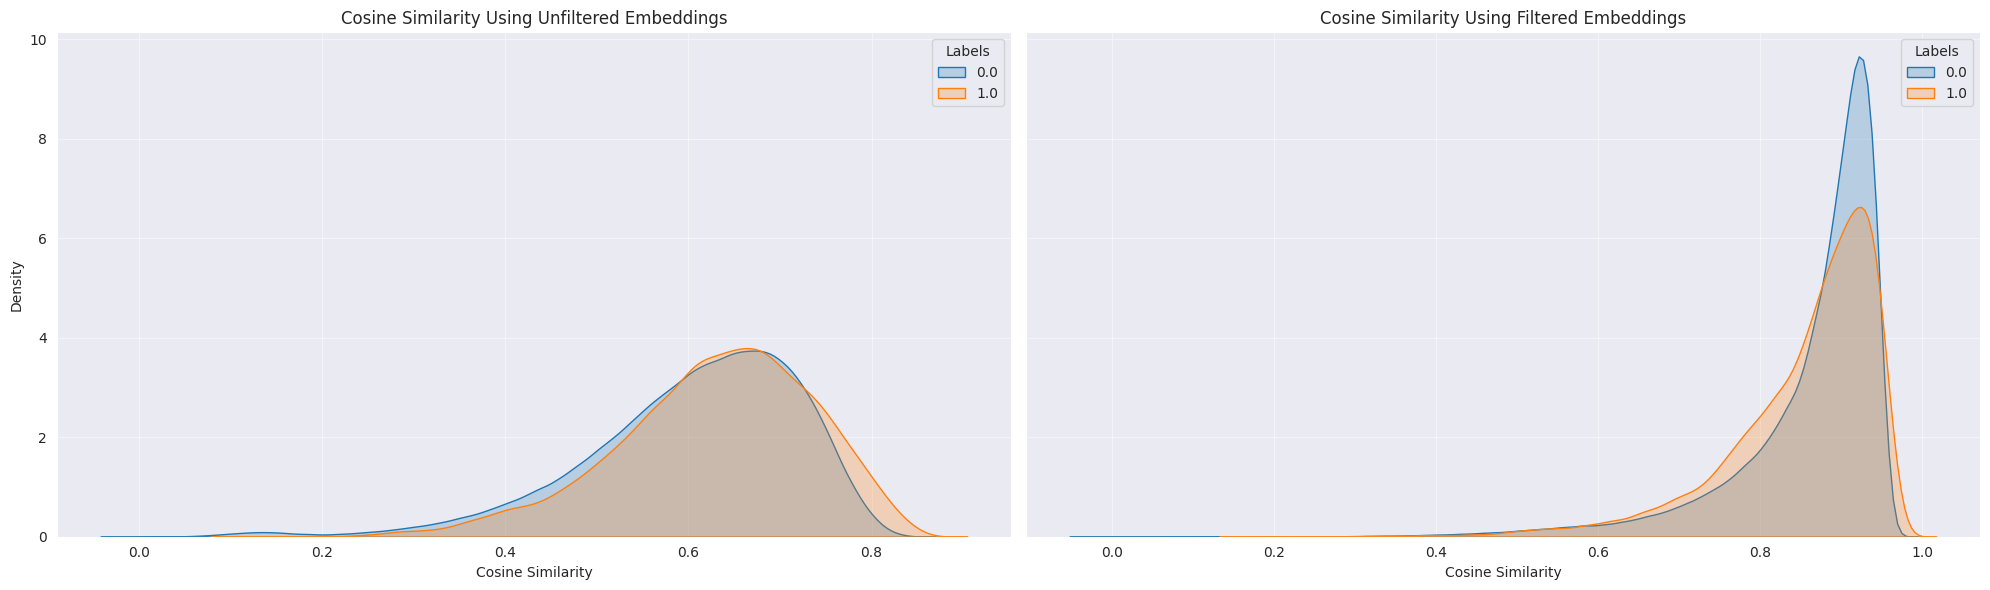

In [258]:
token_df["similarity_of_filtered_embeddings"] = compute_cosine_similarity_batchwise(
                                    token_df['filtered_embeddings'],
                                    token_df['filtered_feature_text_embeddings'],
                                    100_000)
plot_kde_side_by_side(
    ["similarity_to_feature_text_embeddings", "similarity_of_filtered_embeddings"],
    ["Cosine Similarity Using Unfiltered Embeddings", "Cosine Similarity Using Filtered Embeddings"],
    token_df)

As we can see, reducing the embeddings did not improve the distinction between annotated and non-annotated tokens — in fact, it made it worse.

Processing batches: 100%|██████████| 31/31 [00:05<00:00,  5.53it/s]


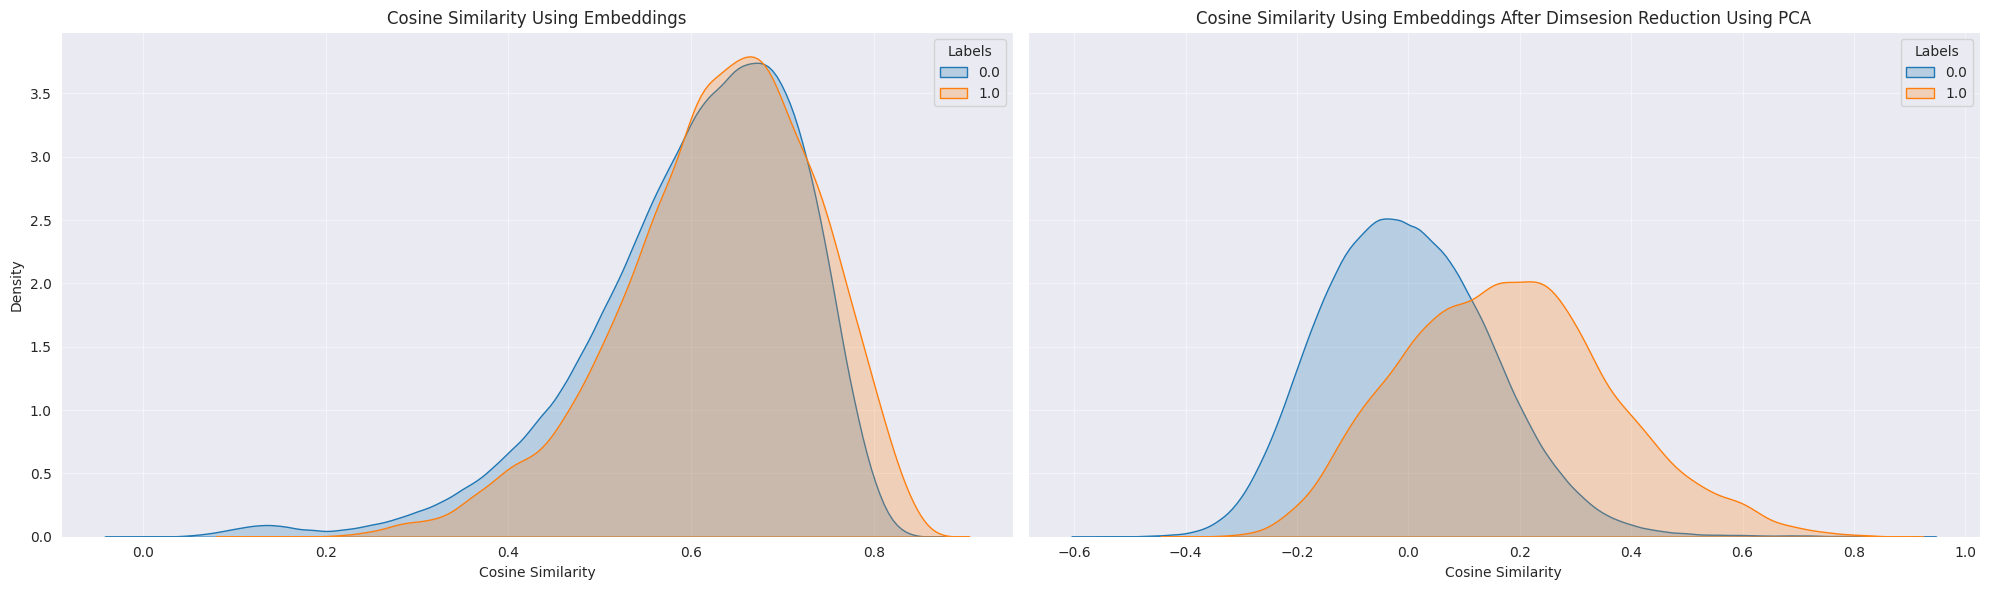

In [259]:
token_df["similarity_of_reduced_embeddings"] = compute_cosine_similarity_batchwise(
                                    token_df['pca_reduced_embeddings'],
                                    token_df['pca_reduced_feature_text_embeddings'],
                                    100_000)

plot_kde_side_by_side(
    ["similarity_to_feature_text_embeddings", "similarity_of_reduced_embeddings"],
    ["Cosine Similarity Using Embeddings", "Cosine Similarity Using Embeddings After Dimsesion Reduction Using PCA"],
    token_df)

Not only did PCA reduce the embedding size (from ~700 to 100), but it also improved the separation between annotated and non-annotated tokens!

From now on, we will use the PCA-reduced embeddings.

#### Third Attempt
Let's build a classifier using the reduced embeddings, along with similarity scores. Specifically, we'll include both the reduced embeddings and their element-wise product with similarity values.

We'll start with logistic regression since it is efficient for handling high-dimensional data (~300 features) and provides quick feedback.

In [260]:
X = df_to_array(token_df.loc[:,["pca_reduced_embeddings","pca_reduced_feature_text_embeddings","similarity_of_reduced_embeddings"]])
X = np.concatenate([X[:,:100]*X[:,100:200],X],axis=1)
y = token_df.token_label.astype(int)
y_char_level = token_df.labels
train_mask = get_df_mask_by_dataset_type(token_df,"train")
val_mask = get_df_mask_by_dataset_type(token_df,"val")


In [261]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(max_iter=10_000)
classifier = eval_classifier(classifier, X, y, y_char_level, train_mask, val_mask)

Accuracy: 0.9908111355898258
AUC-ROC: 0.9311263896361244

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    618019
           1       0.63      0.15      0.24      6106

    accuracy                           0.99    624125
   macro avg       0.81      0.57      0.62    624125
weighted avg       0.99      0.99      0.99    624125

Micro f1 character level score 0.19376561312045182


Similar to previous attempts, our classifier struggles with poor performance, primarily due to a very low recall rate. In fact, its overall performance is the worst we've seen so far.

#### Leveraging DeBERTa's Paired Text Embeddings
As noted earlier, DeBERTa allows passing a pair of text segments as input — a setup designed for tasks that require analyzing relationships between two texts, making it well-suited for our objective.

However, this approach is more memory-intensive since it generates unique embeddings for each text pair.

To mitigate this, we'll optimize memory usage by performing batch operations, using lower-precision floating-point representations, and incorporating insights from our previous attempts.

Clearing Memory and Releasing Unused Variables

In [262]:
del combined_embeddings
del pca
del pca_result
del encoded_feature_text
del encoded_patient_notes
del patient_notes_embeddings
del feature_text_embeddings
del pn_tokens_df
del token_df
del classifier
del X
del y
del y_char_level

In [263]:
patient_feature_pairs_embeddings = torch.load(f"{BASE_DIRECTORY}patient_feature_pairs_embeddings.pt")
patient_feature_pairs_embeddings = patient_feature_pairs_embeddings.to(torch.float16) # converting for saving memory


<ipython-input-263-3455995d728b>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  patient_feature_pairs_embeddings = torch.load(f"{BASE_DIRECTORY}patient_feature_pairs_embed

In [264]:
column_name_to_tensor = {
                        "embeddings":patient_feature_pairs_embeddings,
                        "embeddings_slice":encoded_patient_feature_pairs["offset_mapping"]
}

token_pair_df = train_df.copy()
token_pair_df = add_tensors_to_df(token_pair_df, column_name_to_tensor)

def filter_type(row: pd.Series, column: str, text_type: int) -> np.ndarray:
  """
  Filters array in the specified column based on the token_type_ids for the given text_type.

  Args:
      row (pd.Series): A row from the DataFrame.
      column (str): The column containing array (ndarray).
      text_type (int): The token type to filter by (0 for patient notes, 1 for features).
  Returns:
      np.ndarray: Filtered tokens corresponding to the specified text_type.
  """
  return row[column][encoded_patient_feature_pairs['token_type_ids'][row.name] == text_type]

token_pair_df["embeddings_slice"] = (
    token_pair_df.apply(lambda x: filter_type(x,"embeddings_slice",0),axis=1)
    .apply(list)
)
token_pair_df["feature_text_embeddings"] = (
    token_pair_df.apply(lambda x: filter_type(x,"embeddings",1).mean(axis=0),axis=1)
)
token_pair_df["embeddings"] = (
    token_pair_df.apply(lambda x: filter_type(x,"embeddings",0),axis=1)
    .apply(list)
)

del patient_feature_pairs_embeddings
del column_name_to_tensor
del encoded_patient_feature_pairs

token_pair_df = token_pair_df.explode(["embeddings","embeddings_slice"], ignore_index=True)
token_pair_df = split_slice_column(token_pair_df,"embeddings_slice")

token_pair_df["labels"] = slice_labels_for_df(token_pair_df, "labels", "embeddings_slice_start", "embeddings_slice_end")

token_pair_df["token_label"] = token_pair_df.labels.apply(lambda x: bool(x[0]))

token_pair_df["similarity"] = compute_cosine_similarity_batchwise(
                                    token_pair_df['embeddings'],
                                    token_pair_df['feature_text_embeddings'],
                                    1_000)

Processing batches: 100%|██████████| 3012/3012 [01:47<00:00, 28.06it/s]


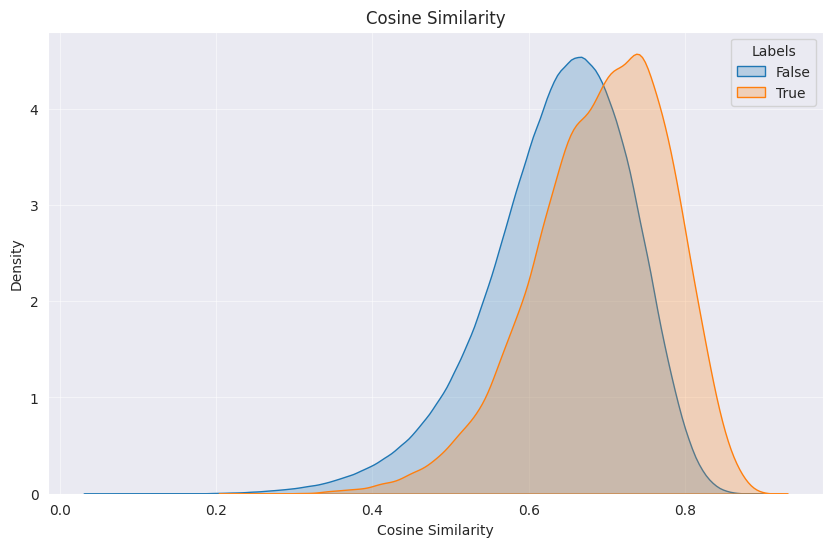

In [265]:
plt.figure(figsize=(10, 6))
plot_kde_for_column("similarity","Cosine Similarity", plt.gca(), token_pair_df)

Compared to the cosine similarity based on embeddings created by passing the patient notes and feature text separately, the separation between annotated and non-annotated tokens is clearer.

As with previous attempt, we’ll apply PCA to simplify the data and enhance performance.

In [266]:
from sklearn.decomposition import IncrementalPCA

def get_trained_pca(df: pd.DataFrame,
                    batch_size: int = 100_000,
                    n_components: int = 100) -> IncrementalPCA:
    """
    Perform PCA in batchs to avoid OOM on two DataFrame columns of NumPy arrays.

    Parameters:
    - df: Pandas DataFrame containing NumPy arrays in two columns.
    - col1: str, name of the first column (e.g., 'feature_embeddings').
    - col2: str, name of the second column (e.g., 'embeddings').
    - batch_size: int, number of rows to process per batch.
    - n_components: int, number of PCA components to retain.

    Returns:
    - ipca: Trained IncrementalPCA model.
    """

    ipca = IncrementalPCA(n_components=n_components)

    train_mask = get_df_mask_by_dataset_type(token_pair_df, "train")
    filtered_df = df[train_mask]
    num_rows = len(filtered_df)


    for i in tqdm(range(0, num_rows, batch_size)):
        batch = filtered_df.iloc[i:i+batch_size]

        batch_data = np.vstack(batch["embeddings"].to_numpy())
        batch_data2 = np.vstack(batch["feature_text_embeddings"].to_numpy())

        combined_batch = np.concatenate([batch_data, batch_data2], axis=0)

        ipca.partial_fit(combined_batch)

    return ipca

In [267]:
def batch_pca_transform(df: pd.DataFrame, pca: PCA, batch_size=100_000) -> tuple[list[np.ndarray], list[np.ndarray]]:
  """
  Applies PCA transformation in batches to avoid OOM.

  Parameters:
  - df: Pandas DataFrame containing NumPy arrays in two columns.
  - col1: str, first column name (e.g., 'feature_embeddings').
  - col2: str, second column name (e.g., 'embeddings').
  - pca: Trained IncrementalPCA model.
  - batch_size: int, number of rows to process per batch.

  Returns:
  -  tuple: A tuple containing two lists of NumPy arrays,
      the transformed embeddings and feature embeddings.
  """

  transformed_batches = []

  num_rows = len(df)

  feature_reduced = []
  embed_reduced = []

  for i in tqdm(range(0, num_rows, batch_size)):
    embeddings_batch = df.loc[df.index[i:i + batch_size], "embeddings"]
    feature_embeddings_batch = df.loc[df.index[i:i + batch_size], "feature_text_embeddings"]

    transformed_embeddings = list(pca.transform(np.vstack(embeddings_batch.to_numpy())))
    embed_reduced.extend(transformed_embeddings)

    transformed_feature_embeddings = list(pca.transform(np.vstack(feature_embeddings_batch.to_numpy())))
    feature_reduced.extend(transformed_feature_embeddings)
  return embed_reduced, feature_reduced

Processing batches: 100%|██████████| 3012/3012 [00:07<00:00, 414.30it/s]


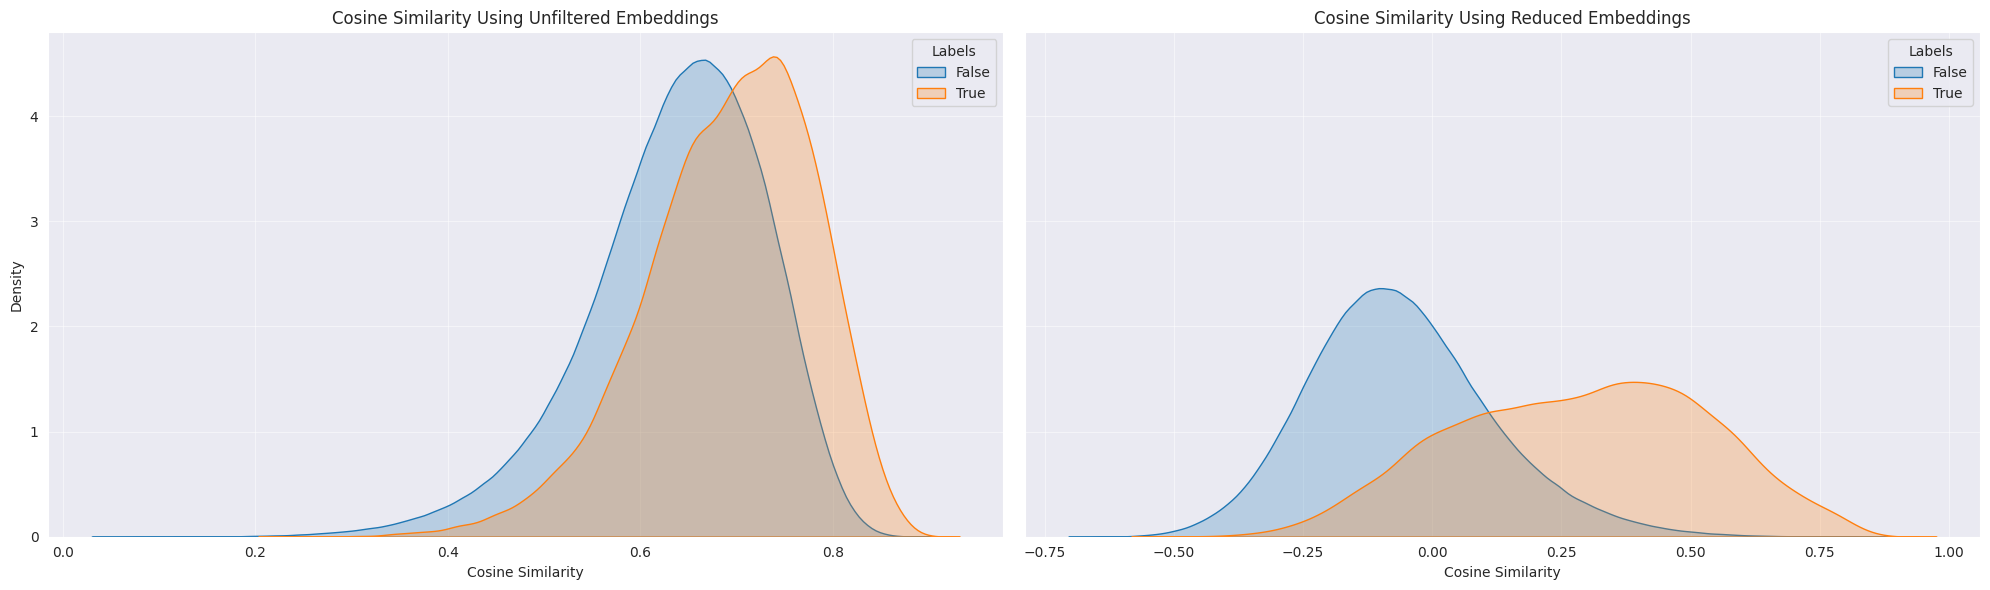

In [268]:
pca = get_trained_pca(token_pair_df, n_components=100)
token_pair_df["embeddings"], token_pair_df["feature_text_embeddings"] = batch_pca_transform(token_pair_df, pca)
token_pair_df["reduced_similarity"] = compute_cosine_similarity_batchwise(
                                    token_pair_df['embeddings'],
                                    token_pair_df['feature_text_embeddings'],
                                    1_000)
plot_kde_side_by_side(
    ["similarity", "reduced_similarity"],
    ["Cosine Similarity Using Unfiltered Embeddings", "Cosine Similarity Using Reduced Embeddings"],
    token_pair_df)

The similarity using the PCA-reduced paired embeddings has provided the best separation we've achieved so far.

Let's now attempt to build a classifier similar to our previous one, but this time based on the paired embeddings.

### Fourth Attempt

In [269]:
X = df_to_array(token_pair_df.loc[:,["embeddings","feature_text_embeddings","reduced_similarity"]])
y_char_level = token_pair_df.labels
y = token_pair_df.token_label.astype(int)
train_mask = get_df_mask_by_dataset_type(token_pair_df,"train")
val_mask = get_df_mask_by_dataset_type(token_pair_df,"val")

del token_pair_df

X = np.concatenate([X[:,:100]*X[:,100:200],X],axis=1)

In [270]:
classifier = LogisticRegression(max_iter=10_000)
classifier = eval_classifier(classifier, X, y, y_char_level,train_mask,val_mask)

Accuracy: 0.9913526937712798
AUC-ROC: 0.9533179327494072

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    618019
           1       0.65      0.25      0.36      6106

    accuracy                           0.99    624125
   macro avg       0.82      0.62      0.68    624125
weighted avg       0.99      0.99      0.99    624125

Micro f1 character level score 0.3134234269729325


We achieved much better results than in previous attempt, though the classifier's performance remains poor and still far below that of our word-based classifier.

In [271]:
del X
del y
del y_char_level
del train_mask
del val_mask
del classifier
del pca
import gc
gc.collect()

20362

### Fine-Tuning DeBERTa
So far, our best classifier has been a simple decision tree with an F1-score of 0.608, relying on word matching between patient notes and known annotations/words in the feature text. While effective given its simplicity, this method struggles with generalization — it has a very weak ability to identify annotated words it has never seen before or distinguish between words appearing in different contexts.

Unlike our word-matching approach, DeBERTa is designed for a deep and nuanced understanding of the English language.

However, our attempts to classify tokens using DeBERTa embeddings have resulted in poor performance. This could be because the tasks DeBERTa was pre-trained on differ from ours, requiring slightly different skills and knowledge.

To fully leverage DeBERTa’s linguistic understanding for our specific task, we can apply a common technique called fine-tuning — an additional training phase tailored to our classification goal. Specifically, we can add a classification head to DeBERTa, allowing it to learn optimal features for token classification.

Additionally, we can use the unlabeled data for masked language modeling, helping the model adapt to the specific structure of patient notes.

We’ll start by training the model to classify each token:
- We’ll feed DeBERTa with pairs of patient notes and feature text.
- DeBERTa will extract embeddings for each pair.
- For each embedding, we’ll compute a score between 0 and 1, indicating the probability that the token is annotated, using a sigmoid function applied to a linear transformation.
- During both training and prediction, we’ll disregard the classifications of tokens that are not part of the patient note text.

#### Hyperparameters

In [387]:
BATCH_SIZE = 10 # Reduced from 20 to avoid out-of-memory errors
EPOCHS = 3
LR = 1e-5 # smaller learning rate for small batch size, based on a short research

#### Datasets

In [388]:
from torch.utils.data import Dataset, DataLoader

In [389]:
class CustomDataset(Dataset):
  def __init__(self,
               pn_histories: list[str],
               feature_text: list[str],
               pn_char_labels: list[np.ndarray],
               tokenizer):
    super().__init__()
    self.tokenizer = tokenizer
    self.pn_histories = pn_histories
    self.feature_text = feature_text
    self.pn_char_labels = pn_char_labels

  def create_labels(self,
                    pn_char_labels: np.ndarray,
                    model_input: dict[str, torch.Tensor]) -> torch.Tensor:
    """
    create label for each token:
        0 should not be annotated,
        1 should,
       -1 should be ignored
    """
    labels = np.full(model_input["input_ids"].shape[1], -1)
    tokens_of_pn_history_mask = np.array(model_input.sequence_ids())==0
    labels_of_pn_histories = pn_char_labels[model_input["offset_mapping"][0,tokens_of_pn_history_mask,0]]
    labels[tokens_of_pn_history_mask] = labels_of_pn_histories
    return torch.tensor(labels)

  def __len__(self) -> int:
    return len(self.pn_histories)

  def __getitem__(self, idx: int) -> tuple[dict[str,torch.Tensor],torch.Tensor]:
    pn_history = self.pn_histories[idx]
    feature_text = self.feature_text[idx]
    pn_char_labels = self.pn_char_labels[idx]

    model_input = tokenizer(pn_history,
                            feature_text,
                            max_length=512, # extra padding to handle longer input in the future
                            padding="max_length",
                            return_tensors="pt",
                            return_offsets_mapping=True)
    labels = self.create_labels(pn_char_labels, model_input)
    model_input["input_ids"] = model_input["input_ids"].squeeze(0)
    model_input["attention_mask"] = model_input["attention_mask"].squeeze(0)
    return model_input, labels


In [390]:
train_mask_for_train_df = get_df_mask_by_dataset_type(train_df,"train")
val_mask_for_train_df = get_df_mask_by_dataset_type(train_df,"val")

train_dataset = CustomDataset(train_df.loc[train_mask_for_train_df].pn_history.tolist(),
              train_df.loc[train_mask_for_train_df].feature_text.tolist(),
              train_df.loc[train_mask_for_train_df].labels.tolist(),
              tokenizer)
val_dataset = CustomDataset(train_df.loc[val_mask_for_train_df].pn_history.tolist(),
              train_df.loc[val_mask_for_train_df].feature_text.tolist(),
              train_df.loc[val_mask_for_train_df].labels.tolist(),
              tokenizer)

#### Dataloaders

In [391]:
from itertools import cycle
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          pin_memory=True,
                          drop_last=True)
val_loader = DataLoader(val_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        pin_memory=True,
                        drop_last=True)

cycle_val_loader = cycle(val_loader)


#### Model

In [392]:
class DebertaClassifierNetwork(torch.nn.Module):
    def __init__(self, deberta_model):
        super().__init__()
        self.deberta = deberta_model
        self.fc = torch.nn.Linear(self.deberta.config.hidden_size, 1)
    def forward(self, input_ids, attention_mask):
        features = self.deberta(input_ids=input_ids, attention_mask=attention_mask)
        score = self.fc(features.last_hidden_state)
        return score

In [393]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.empty_cache()
classifier_model = DebertaClassifierNetwork(embeddings_model)
classifier_model.to(device)

DebertaClassifierNetwork(
  (deberta): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=768, out_features=2304, bias=False)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (pos_proj): Linear(in_features=768, out_features=768, bias=False)
              (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): Dropout(p=0.1, inpl

#### Optimizer

In [394]:
optimizer = torch.optim.Adam(classifier_model.parameters(), lr=LR) # commonly used optimizer

#### Criterion

In [395]:
criterion = torch.nn.BCEWithLogitsLoss(reduction="none") # redcution is none cause we want to filter out part of the tokens

#### Train Network

In [396]:
import wandb # platform to monitor the runs of training

In [397]:
wandb.login()

True

In [398]:
wandb.init(
    project="Key Phrase Extraction in Medical Exam Notes ",
    config={
    "learning_rate": LR,
    "batch_size": BATCH_SIZE,
    "epochs": EPOCHS,
    }
)


##### Eval Functions

In [399]:
def get_character_level_prediction(prediction: torch.Tensor, index: int) -> np.ndarray:
  """
  Converts token-level predictions into character-level predictions by mapping token spans
  to the corresponding character positions in the original text.

  Args:
      prediction (torch.Tensor): The token-level prediction tensor, where each value is
                                  the predicted label (0 or 1) for each token.
      index (int): The index of the sample in the validation set to retrieve the corresponding text.

  Returns:
      np.ndarray: An array of predictions (0 or 1) corresponding to each character in the input text.
  """
  text = train_df.loc[val_mask_for_train_df,"pn_history"].iloc[index]
  encoded_text = tokenizer(text,
                           add_special_tokens=False,
                           return_offsets_mapping=True)
  char_level_pred = np.zeros(len(text))
  for idx, (offset_mapping, pred) in enumerate(zip(encoded_text['offset_mapping'], prediction)):
    start = offset_mapping[0]
    end = offset_mapping[1]
    char_level_pred[start:end] = pred
  return char_level_pred

In [400]:
def get_character_level_predictions_for_model_result(
    model_result: torch.Tensor,
    labels: torch.Tensor,
    batch_num: int
) -> list[np.ndarray]:
  """
  Converts model predictions into character-level predictions for each token in the batch.

  Args:
      model_result (torch.Tensor): The raw output from the classifier model.
      labels (torch.Tensor): The ground truth labels for the tokens.
      batch_num (int): The current batch number, used for indexing.

  Returns:
      List[np.ndarray]: A list of character-level predictions for each token in the batch.
  """
  model_result_list = list(model_result)
  labels_list = list(labels)
  char_level_preds = []
  for i, (result,labels) in enumerate(zip(model_result_list,labels_list)):
    valid_labels_mask = (labels != -1)
    predicted_labels = result[valid_labels_mask].sigmoid().round().flatten()
    char_level_preds.append(get_character_level_prediction(predicted_labels.detach().cpu(),
                                                           batch_num*BATCH_SIZE+i))
  return char_level_preds

##### Train functions

In [401]:
def iterate_batch(model_input: dict[str,torch.Tensor],
                  labels: torch.Tensor,
                  epoch_num: int,
                  batch_num: int) -> None:
  """
  Performs a single batch iteration for training, computing loss and accuracy,
  and updating the model weights using backpropagation.

  Args:
      model_input (dict): Input dictionary containing model data, with keys like "input_ids" and "attention_mask".
      labels (Tensor): Ground truth labels for the current batch, with -1 indicating ignored labels.
      epoch_num (int): The current epoch number.
      batch_num (int): The current batch number.

  Returns:
      None: The function logs the loss and accuracy to wandb and updates the model weights.
  """
  classifier_model.train()
  optimizer.zero_grad()
  model_result = classifier_model(model_input["input_ids"],
                                  attention_mask=model_input["attention_mask"])
  valid_labels_mask = labels.view(-1, 1) != -1
  filtered_model_result = torch.masked_select(model_result.view(-1, 1), valid_labels_mask)
  filtered_labels = torch.masked_select(labels.view(-1, 1), valid_labels_mask)
  loss = criterion(filtered_model_result, filtered_labels.float()).mean()
  loss.backward()
  optimizer.step()
  with torch.no_grad():
    correct_labels_amount = (filtered_model_result.sigmoid().round()==filtered_labels).sum()
    train_acc = correct_labels_amount/filtered_labels.numel()
  wandb.log({"train_loss": loss, "train_acc": train_acc, "batch_num": batch_num, "epoch_num": epoch_num})

In [402]:
def iterate_val_batch(model_input: dict[str,torch.Tensor],
                      labels: torch.Tensor,
                      epoch_num: int,
                      batch_num: int,
                      to_log: bool = False) -> None or list[np.ndarray]:
  """
  Processes a batch of validation data,
  computes loss, accuracy, and generates character-level predictions.

  Args:
      model_input (Dict[str, torch.Tensor]): The input tensors for the model, including input IDs and attention mask.
      labels (torch.Tensor): The true labels for the tokens in the batch.
      batch_num (int): The current batch number.
      to_log (bool): wheter to log the results to wandb. defaults to False
  Returns:
      list[np.ndarray]: A list of character-level predictions for each token in the batch.
  """
  classifier_model.eval()
  with torch.no_grad():
    model_result = classifier_model(model_input["input_ids"],
                                    attention_mask = model_input["attention_mask"] )

    char_level_preds = get_character_level_predictions_for_model_result(model_result,labels,batch_num)

    if to_log:
      valid_labels_mask = labels.view(-1, 1) != -1
      filtered_model_result = torch.masked_select(model_result.view(-1, 1), valid_labels_mask)
      filtered_labels = torch.masked_select(labels.view(-1, 1), valid_labels_mask)
      loss = criterion(filtered_model_result, filtered_labels.float()).mean()
      predicted_labels = filtered_model_result.sigmoid().round()
      correct_labels_amount = (predicted_labels==filtered_labels).sum()
      acc = correct_labels_amount/filtered_labels.numel()
      char_level_labels = train_df.loc[val_mask_for_train_df,"labels"].iloc[batch_num*BATCH_SIZE:batch_num*BATCH_SIZE+len(char_level_preds)].tolist()
      metrics_dict = compute_metrics(char_level_preds, char_level_labels)
      wandb.log({"validation_loss": loss,
                 "validation_acc": acc,
                 "validation_batch_num": batch_num,
                 "validation_epoch_num": epoch_num,
                 **{f"validation_{metric}": metrics_dict[metric] for metric in metrics_dict},
                 })
  return char_level_preds

In [403]:
def iterate_epoch(epoch_num: int) -> None:
  """
  Iterates over the entire training dataset for one epoch, processing each batch.

  Args:
    epoch_num (int): The current epoch number.

    Returns:
        None: This function updates the model weights and logs metrics during training.
  """
  val_loader_size = len(val_loader)
  for i , (model_input, labels) in tqdm(enumerate(train_loader)):
    model_input = move_data_to_device(model_input,device=device)
    labels = labels.to(device)
    iterate_batch(model_input, labels,epoch_num,i)
    if i % 10 == 0:
      test_model_input, test_labels = next(cycle_val_loader)
      test_model_input = move_data_to_device(test_model_input,device=device)
      test_labels = test_labels.to(device)
      iterate_val_batch(test_model_input,
                        test_labels,
                        epoch_num,
                        i%val_loader_size,
                        to_log=True)

In [404]:
def iterate_val_epoch(epoch_num: int) -> float:
  """
  Runs through the validation dataset for one epoch, computes metrics, and logs the results.

  Args:
      epoch_num (int): The current epoch number.

  Returns:
      float: The micro F1 score calculated from the validation set.
  """
  char_level_predictions = []
  for i , (model_input, labels) in tqdm(enumerate(val_loader)):
    model_input = move_data_to_device(model_input,device=device)
    labels = labels.to(device)
    char_level_prediction = iterate_val_batch(model_input, labels, epoch_num, i)
    char_level_predictions.extend(char_level_prediction)

  with torch.no_grad():
    char_level_labels = train_df.loc[val_mask_for_train_df,"labels"].iloc[:len(char_level_predictions)].tolist()
    metrics_dict = compute_metrics(char_level_predictions, char_level_labels)
    for metric in metrics_dict:
      print(f"{metric}: {metrics_dict[metric]} : {epoch_num}")
      wandb.log({f"validation_epoch_{metric}": metrics_dict[metric], "epoch_num": epoch_num})
  return metrics_dict["micro_f1"]

##### Fifth Attempt - Run Training and Evaluation

In [405]:
def run_training():
  for i in tqdm(range(EPOCHS)):
    iterate_epoch(i)
    iterate_val_epoch(i)
  wandb.finish()

In [406]:
run_training()

  0%|          | 0/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  1.75it/s]
2it [00:00,  2.21it/s]
3it [00:01,  2.41it/s]
4it [00:01,  2.52it/s]
5it [00:02,  2.59it/s]
6it [00:02,  2.63it/s]
7it [00:02,  2.65it/s]
8it [00:03,  2.67it/s]
9it [00:03,  2.67it/s]
10it [00:03,  2.68it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

11it [00:04,  2.36it/s]
12it [00:04,  2.46it/s]
13it [00:05,  2.52it/s]
14it [00:05,  2.57it/s]
15it [00:05,  2.61it/s]
16it [00:06,  2.63it/s]
17it [00:06,  2.65it/s]
18it [00:07,  2.67it/s]
19it [00:07,  2.67it/s]
20it [00:07,  2.68it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no pre

micro_f1: 0.5934007094571984 : 0
precision: 0.8730244694992861 : 0
recall: 0.44944617646313334 : 0



0it [00:00, ?it/s]
1it [00:00,  1.80it/s]
2it [00:00,  2.25it/s]
3it [00:01,  2.44it/s]
4it [00:01,  2.55it/s]
5it [00:02,  2.61it/s]
6it [00:02,  2.64it/s]
7it [00:02,  2.67it/s]
8it [00:03,  2.68it/s]
9it [00:03,  2.69it/s]
10it [00:03,  2.70it/s]
11it [00:04,  2.37it/s]
12it [00:04,  2.47it/s]
13it [00:05,  2.54it/s]
14it [00:05,  2.59it/s]
15it [00:05,  2.63it/s]
16it [00:06,  2.66it/s]
17it [00:06,  2.68it/s]
18it [00:06,  2.69it/s]
19it [00:07,  2.70it/s]
20it [00:07,  2.71it/s]
21it [00:08,  2.38it/s]
22it [00:08,  2.48it/s]
23it [00:08,  2.55it/s]
24it [00:09,  2.60it/s]
25it [00:09,  2.64it/s]
26it [00:10,  2.66it/s]
27it [00:10,  2.68it/s]
28it [00:10,  2.69it/s]
29it [00:11,  2.69it/s]
30it [00:11,  2.70it/s]
31it [00:12,  2.39it/s]
32it [00:12,  2.47it/s]
33it [00:12,  2.54it/s]
34it [00:13,  2.59it/s]
35it [00:13,  2.63it/s]
36it [00:13,  2.66it/s]
37it [00:14,  2.68it/s]
38it [00:14,  2.69it/s]
39it [00:15,  2.70it/s]
40it [00:15,  2.70it/s]
41it [00:15,  2.38it/s]
42it 

micro_f1: 0.6874355332984528 : 1
precision: 0.8378762480868741 : 1
recall: 0.5827947177654424 : 1



0it [00:00, ?it/s]
1it [00:00,  1.77it/s]
2it [00:00,  2.23it/s]
3it [00:01,  2.44it/s]
4it [00:01,  2.54it/s]
5it [00:02,  2.61it/s]
6it [00:02,  2.65it/s]
7it [00:02,  2.62it/s]
8it [00:03,  2.65it/s]
9it [00:03,  2.67it/s]
10it [00:03,  2.68it/s]
11it [00:04,  2.36it/s]
12it [00:04,  2.47it/s]
13it [00:05,  2.54it/s]
14it [00:05,  2.59it/s]
15it [00:05,  2.63it/s]
16it [00:06,  2.65it/s]
17it [00:06,  2.67it/s]
18it [00:07,  2.69it/s]
19it [00:07,  2.70it/s]
20it [00:07,  2.71it/s]
21it [00:08,  2.39it/s]
22it [00:08,  2.48it/s]
23it [00:09,  2.55it/s]
24it [00:09,  2.60it/s]
25it [00:09,  2.63it/s]
26it [00:10,  2.66it/s]
27it [00:10,  2.68it/s]
28it [00:10,  2.69it/s]
29it [00:11,  2.70it/s]
30it [00:11,  2.71it/s]
31it [00:12,  2.40it/s]
32it [00:12,  2.49it/s]
33it [00:12,  2.56it/s]
34it [00:13,  2.61it/s]
35it [00:13,  2.65it/s]
36it [00:13,  2.67it/s]
37it [00:14,  2.69it/s]
38it [00:14,  2.70it/s]
39it [00:15,  2.71it/s]
40it [00:15,  2.71it/s]
41it [00:15,  2.38it/s]
42it 

micro_f1: 0.6940087853034854 : 2
precision: 0.8579532731208479 : 2
recall: 0.5826679846906445 : 2


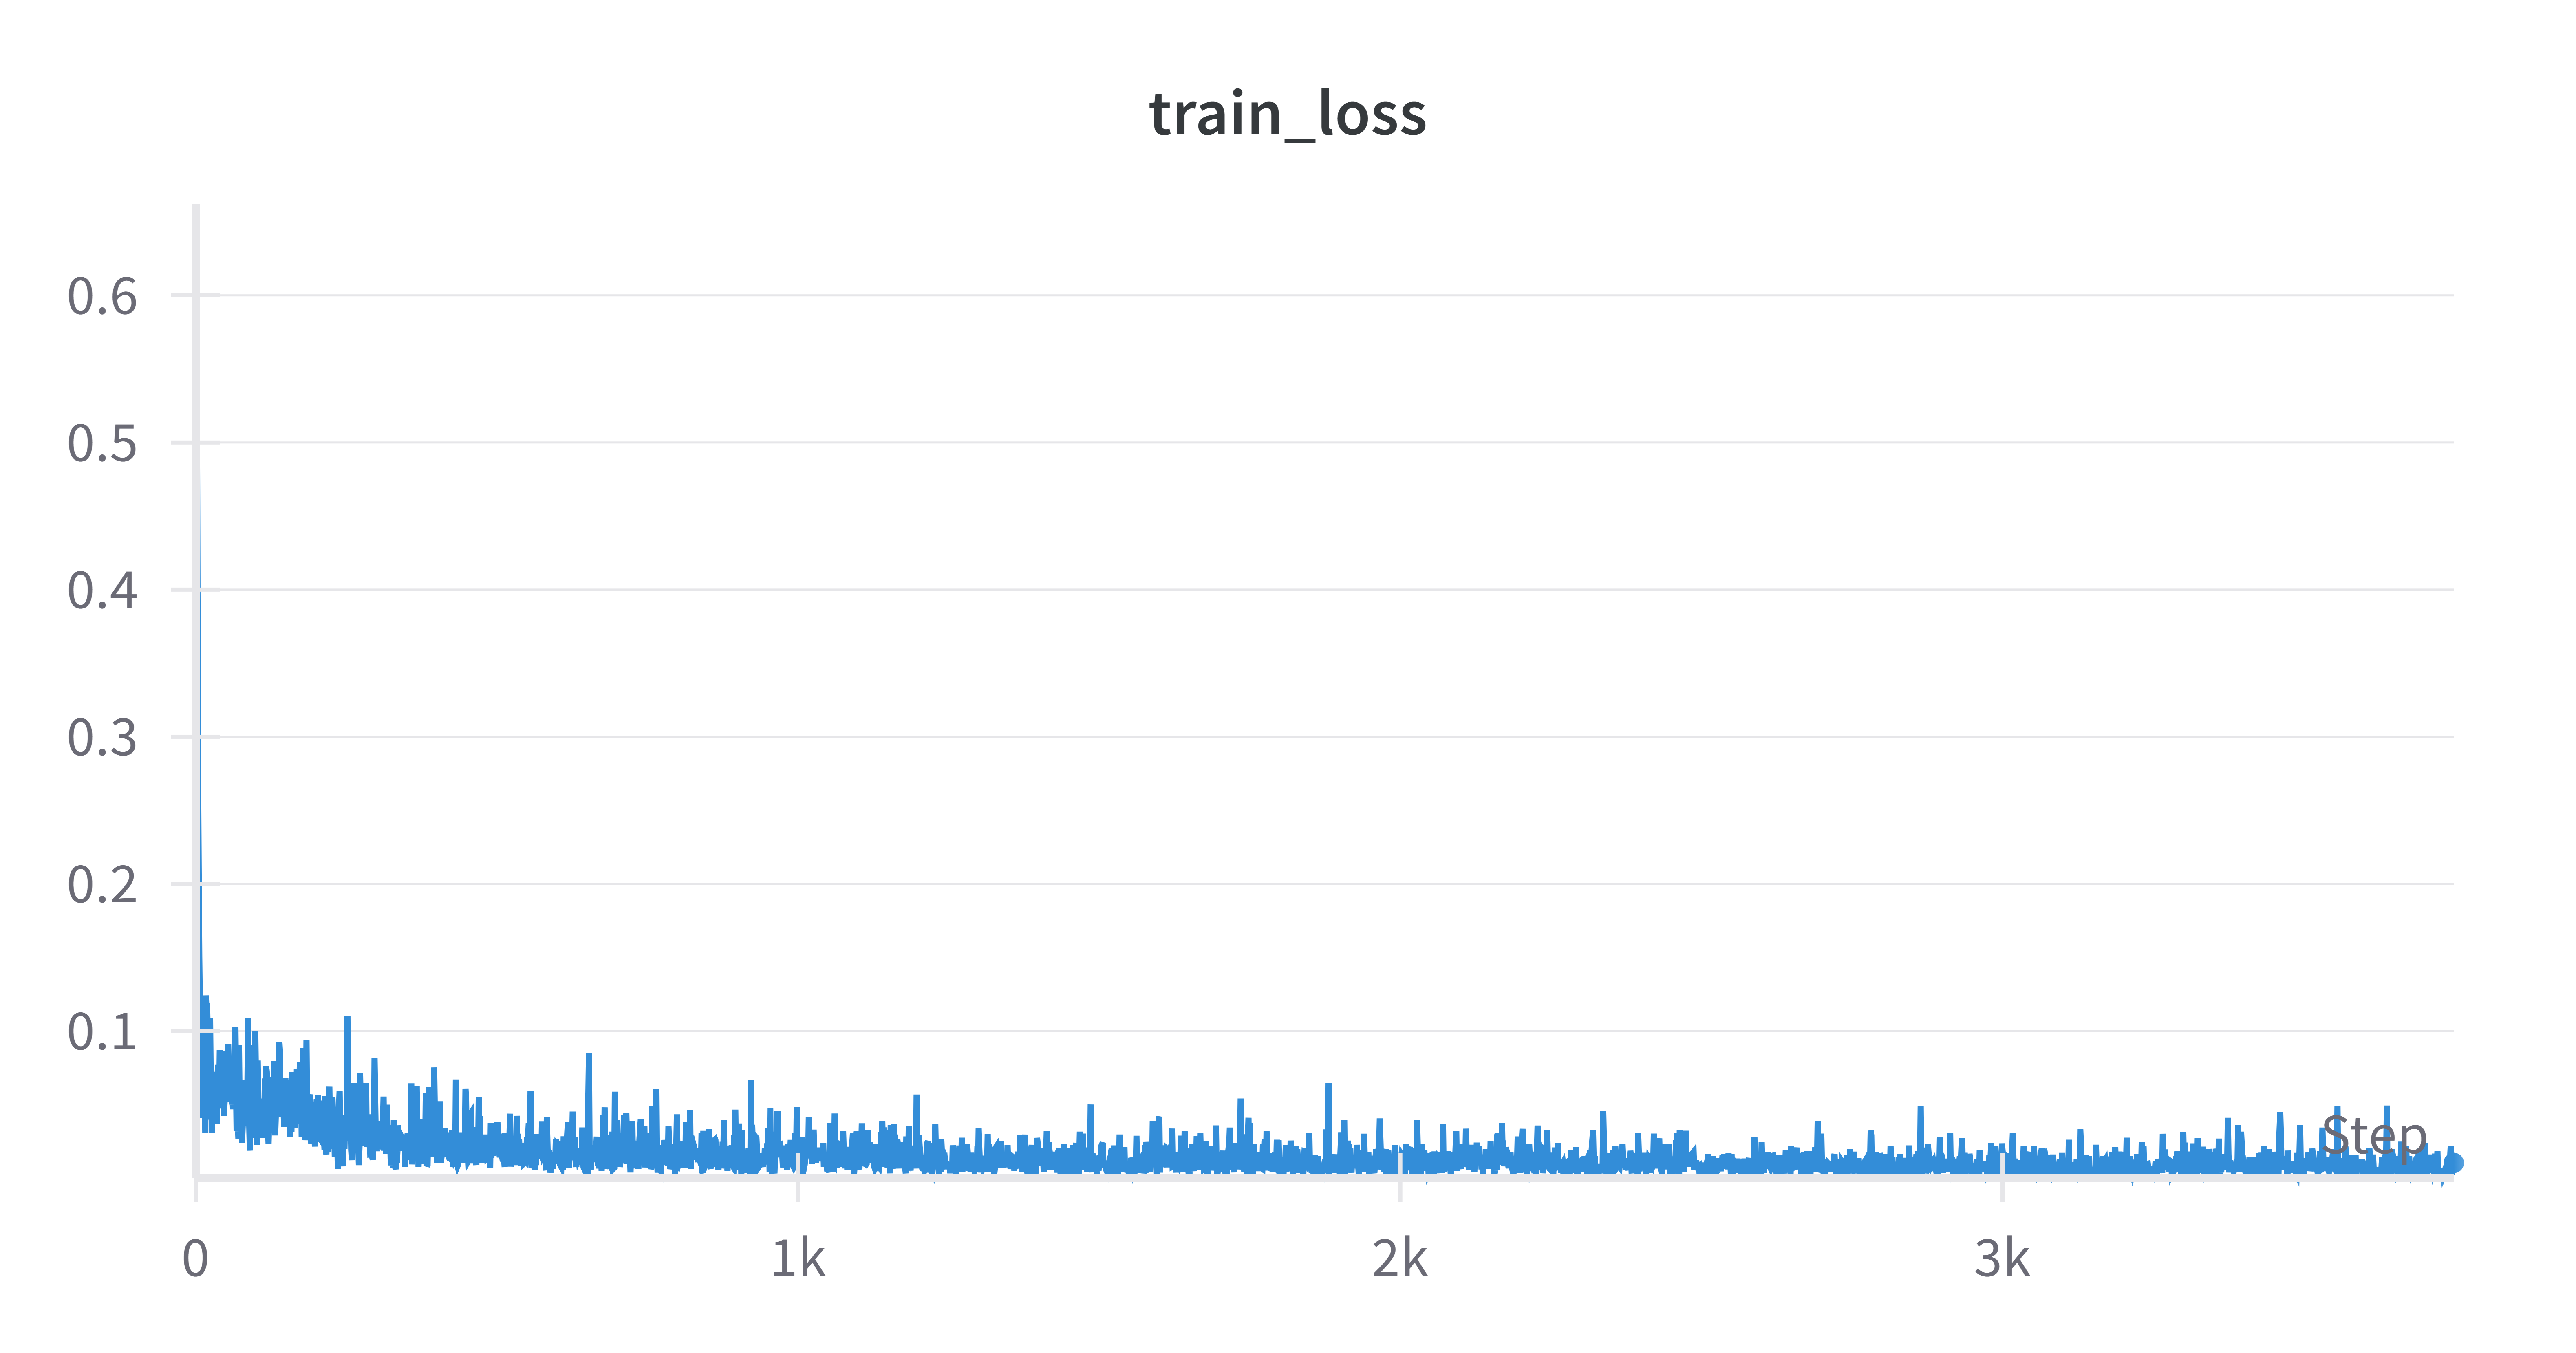



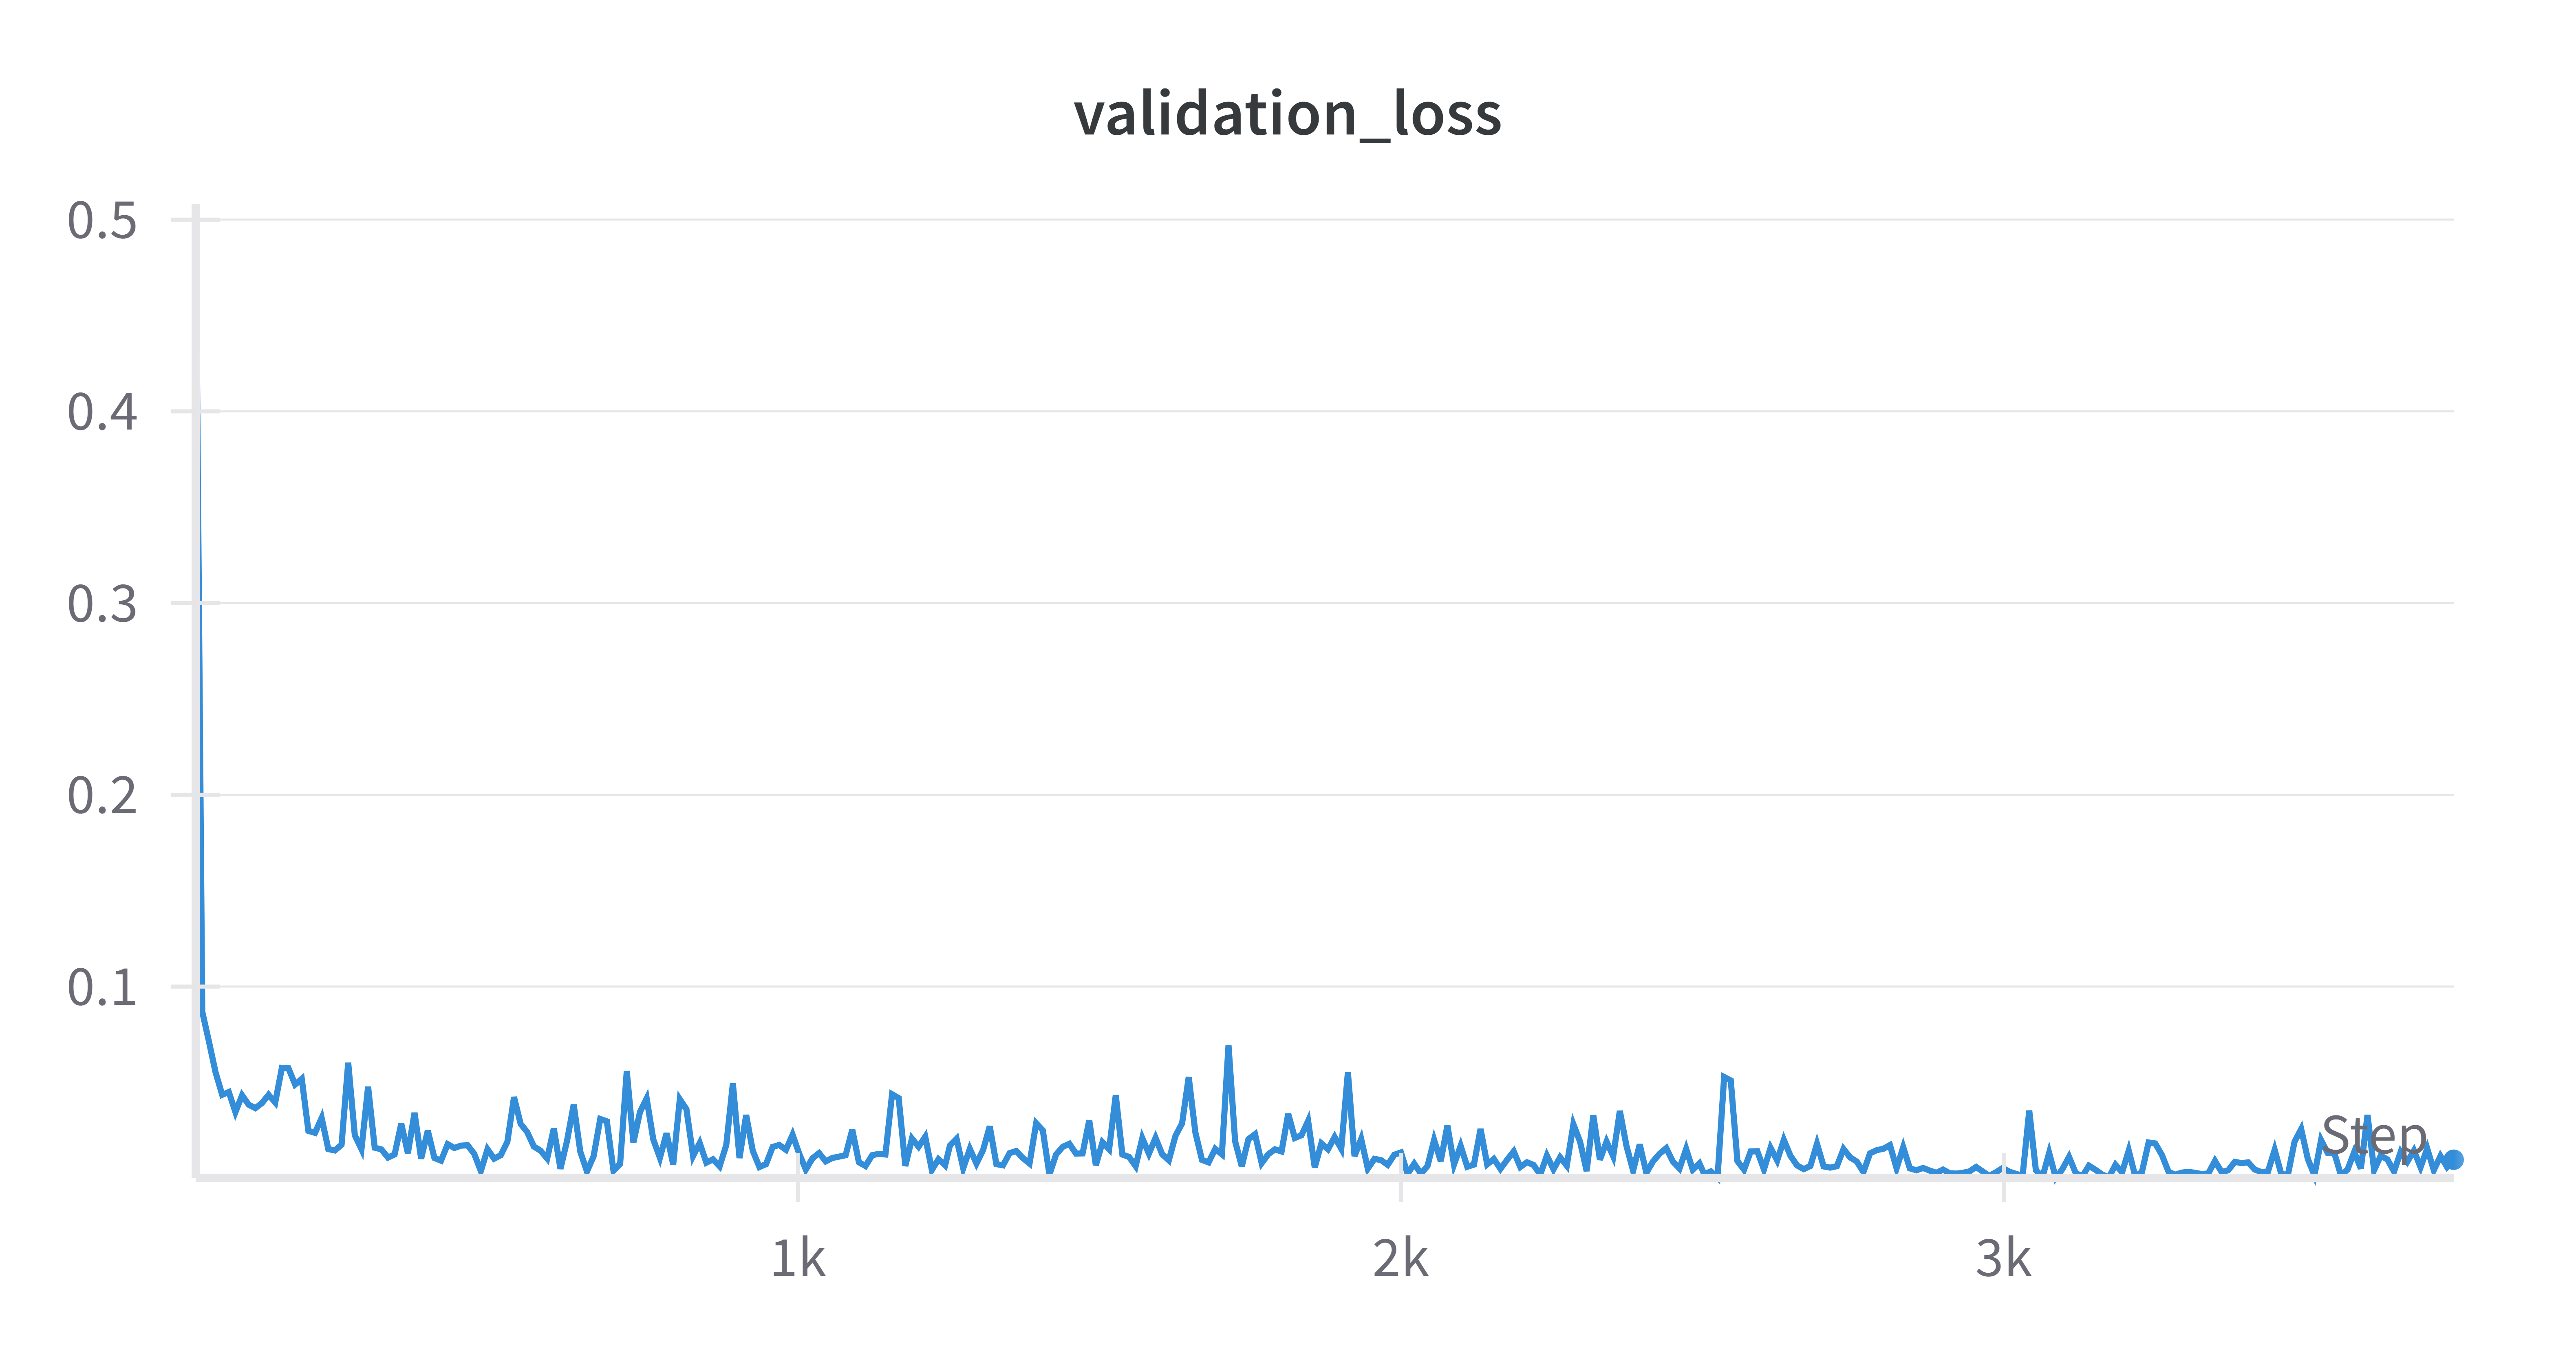

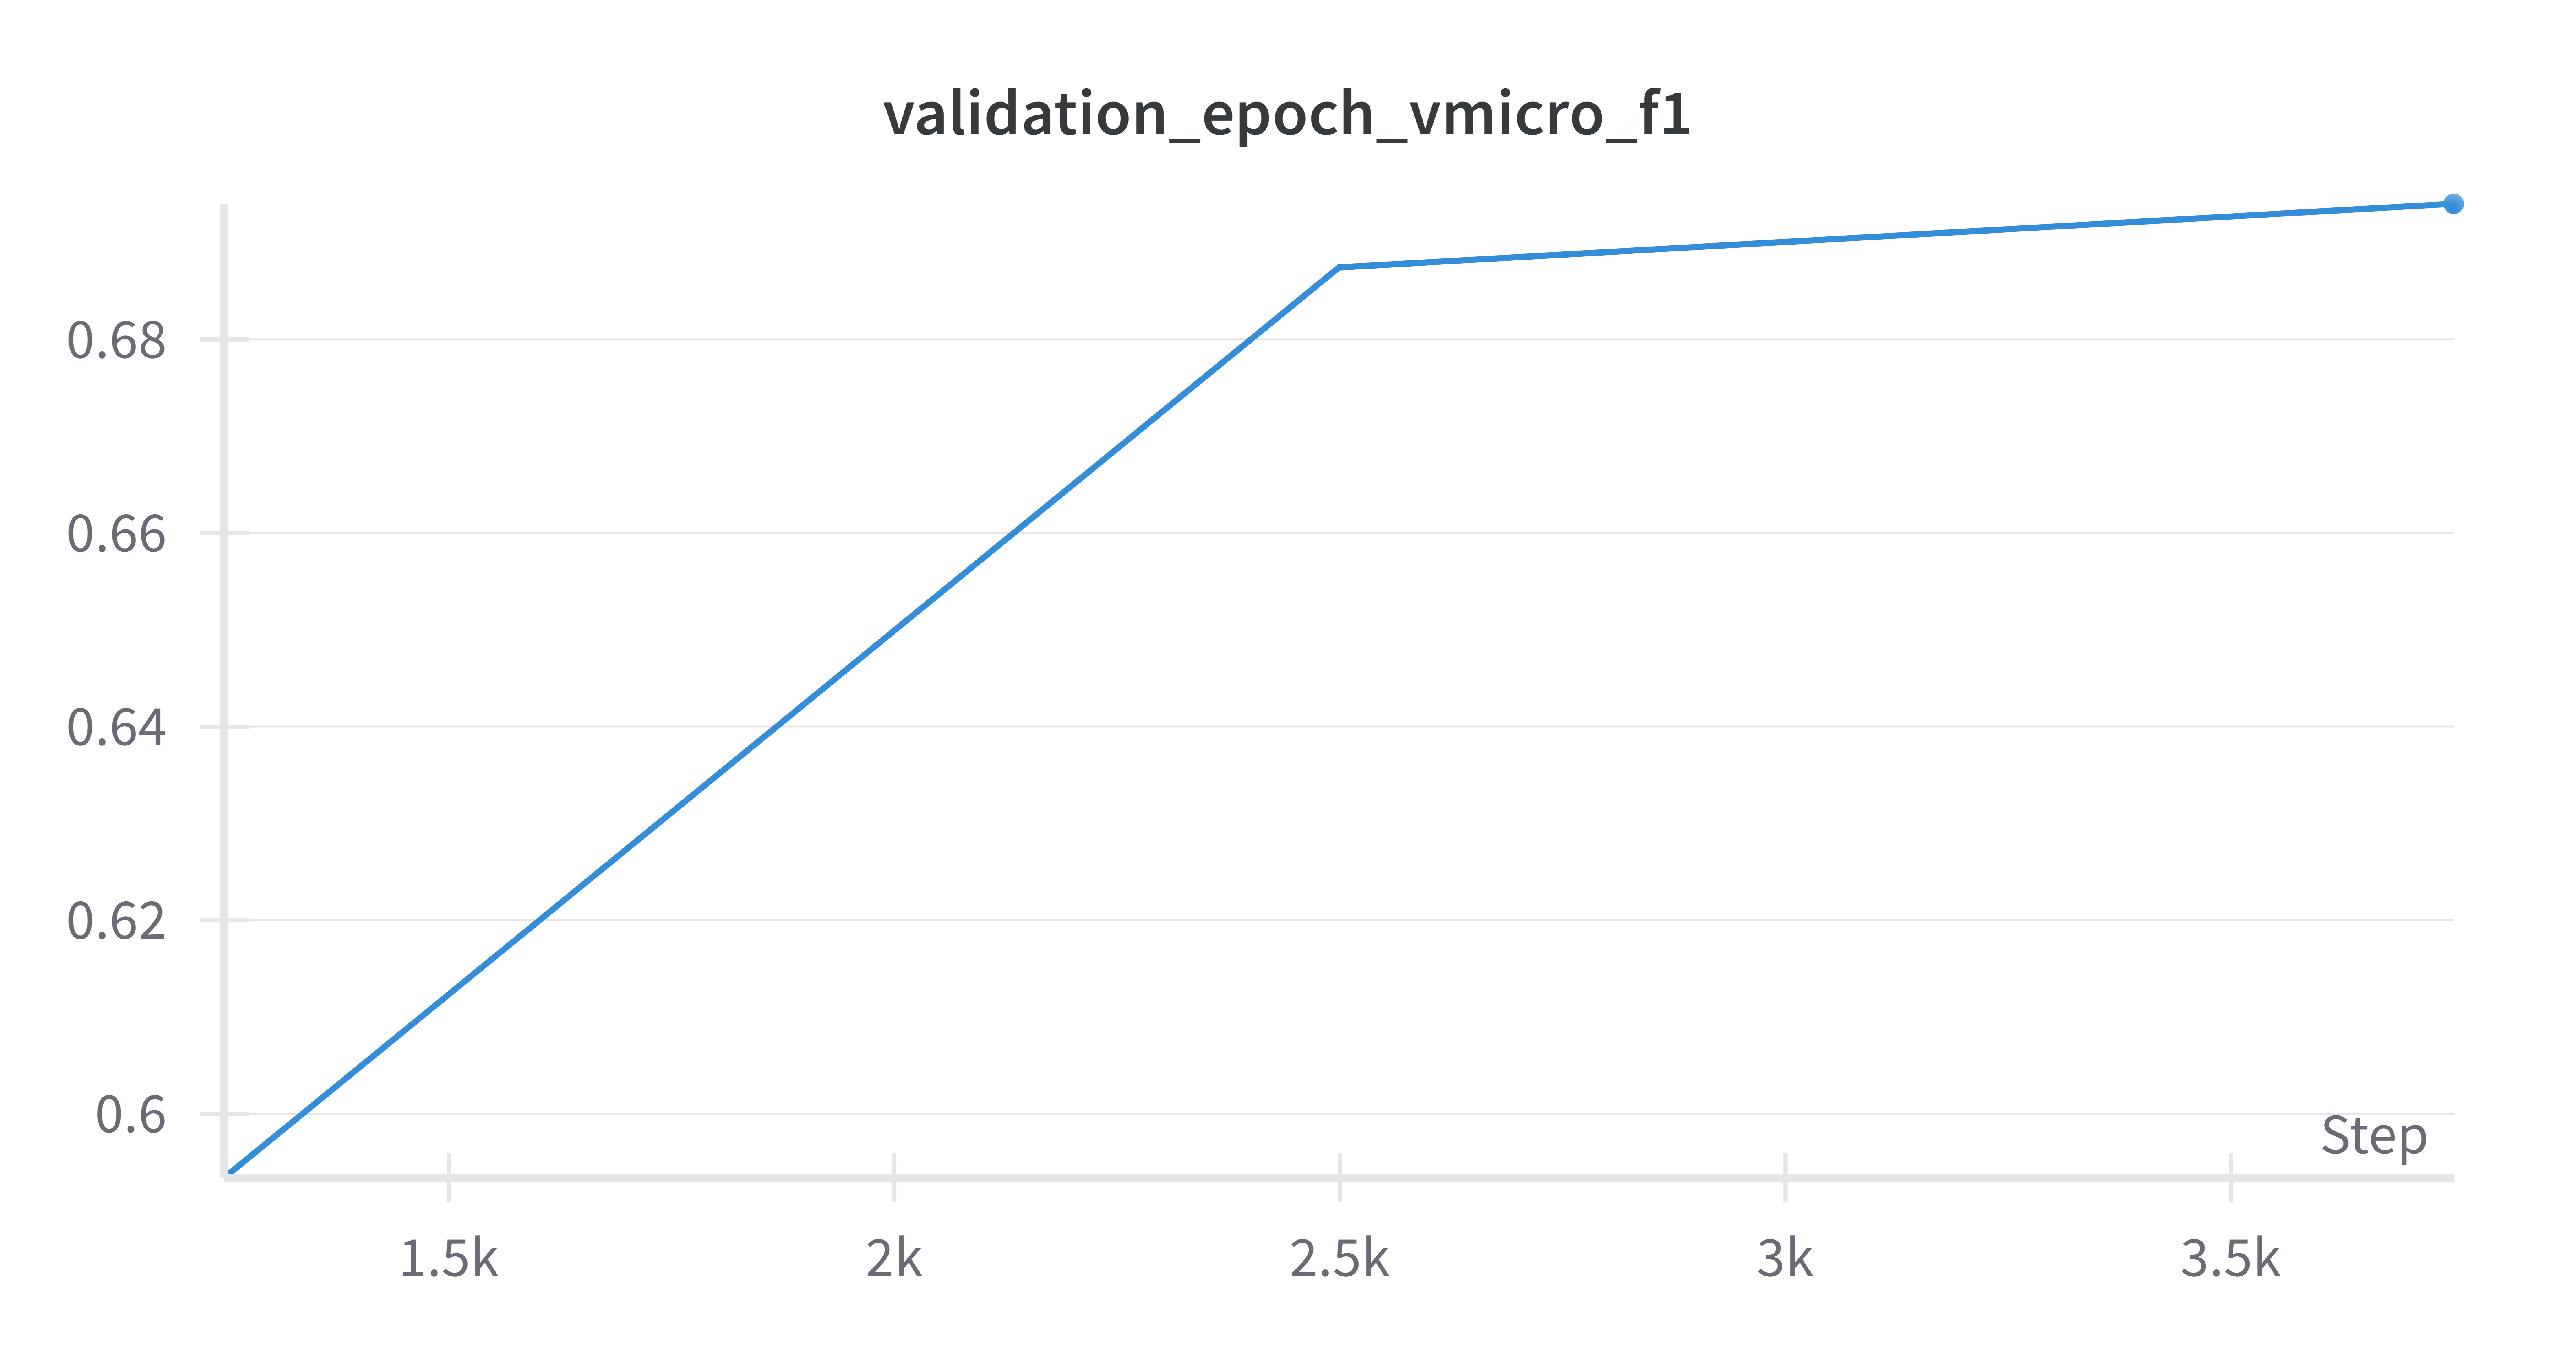

# 📑 **Conclusions**
## Results

<style>
  table {
    width: 100%;
    border-collapse: collapse;
    font-family: Arial, sans-serif;
    text-align: left;
  }
  th, td {
    border: 1px solid #ddd;
    padding: 10px;
  }
  th {
    background-color: #4CAF50;
    color: white;
    text-align: center;
  }
  td {
    vertical-align: top;
  }
  tr:nth-child(even) {
    background-color: #f2f2f2;
  }
  tr:hover {
    background-color: #ddd;
  }
  .description {
    width: 300px;
    word-wrap: break-word;
  }
</style>

<table>
  <tr>
    <th>Attempt Num</th>
    <th>Approach</th>
    <th class="description">Description</th>
    <th>F1-Score</th>
    <th>Precision</th>
    <th>Recall</th>
  </tr>
  <tr>
    <td>1</td>
    <td>Words Classification</td>
    <td class="description">
      Simple decision tree based on:<br>
      1. Is it/nearby words appear in feature text?<br>
      2. Case num<br>
      3. Feature num
    </td>
    <td>0.29</td>
    <td>0.74</td>
    <td>0.21</td>
  </tr>
  <tr>
    <td>2</td>
    <td>Words Classification</td>
    <td class="description">
      Same as previous attempt but added:<br>
      1. Is it/nearby words synonyms of feature words?<br>
      2. Is it a stop word?<br>
      3. Was it annotated in the training data?
    </td>
    <td>0.61</td>
    <td>0.65</td>
    <td>0.58</td>
  </tr>
  <tr>
    <td>3</td>
    <td>Token Classification</td>
    <td class="description">
      Logistic regression on PCA-reduced DeBERTa embeddings.<br>
      Used element-wise multiplication and similarity measures.
    </td>
    <td>0.193</td>
    <td>0.63</td>
    <td>0.15</td>
  </tr>
  <tr>
    <td>4</td>
    <td>Token Classification</td>
    <td class="description">
      Same as previous attempt, <br>
      but instead of passing feature text and patient notes <br>
      to DeBERTa seperately passing them as pairs.
    </td>
    <td>0.313</td>
    <td>0.65</td>
    <td>0.25</td>
  </tr>
  <tr>
    <td>5</td>
    <td>Token Classification</td>
    <td class="description">
      Added a classifier head to DeBERTa and fine-tuned the entire network.
    </td>
    <td><b>0.694</b></td>
    <td><b>0.858</b></td>
    <td><b>0.58</b></td>
  </tr>
</table>


- **Word Classification Based On Word Matching**
  - A straightforward approach that yielded surprisingly good results.
- **Logistic Regression over DeBERTa embeddings**
  - Performed poorly compared to other methods.
- **Fine Tuning DeBERTa**
  - Achieved the best results among all attempts.

The main weakness of all the classifiers is their low recall rate.

  ## Improvement ideas

# 🧑 **Self Reflection**